In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from scipy.sparse import rand
import random
import time
from sklearn.model_selection import train_test_split

# Implementing the screening rule

In [2]:
def compute_loss_gradient(u, mu):
    g = np.zeros(u.size)
    for i in range(u.size):
        if np.abs(u[i]) > mu:
            g[i] = 2 * (u[i] - np.sign(u[i]) * mu)
    return g

def compute_l1_subgradient(u):
    g = np.zeros(u.size)
    for i in range(u.size):
        if u[i] != 0:
            g[i] = np.sign(u[i])
        else:
            g[i] = 2 * np.random.rand(1)[0] - 1
    return g

def compute_subgradient(x, D, y, lmbda, mu):
    output = D.dot(x) - y
    g_1 = compute_loss_gradient(output, mu)
    #g_1 = np.transpose(D).dot(g_1)
    g_1 = (1 / (2 * D.shape[0])) * np.transpose(D).dot(g_1)
    g_2 = compute_l1_subgradient(x)
    g = g_1 + lmbda * g_2
    return g

def update_ellipsoid(z, A, g):
    p = z.size
    A_g = A.dot(g)
    den = np.sqrt(g.dot(A_g))
    g = (1 / den) * g
    A_g = A.dot(g)
    z = z - (1 / (p + 1)) * A_g
    A = (p ** 2 / (p ** 2 - 1)) * (A - (2 / (p + 1)) * np.outer(A_g, A_g))
    return z, A

def iterate_ellipsoids(D, y, z_init, A_init, lmbda, mu, n_steps=100):
    k = 0
    z = z_init
    A = A_init
    while k < n_steps:
        g = compute_subgradient(z, D, y, lmbda, mu)
        z, A = update_ellipsoid(z, A, g)
        k += 1 
    return z, A

def compute_A_g(scaling, L, I_k_vec, g):
    
    L_g = np.dot(np.transpose(L), g)
    I_k_L = np.multiply(I_k_vec, L_g)
    A_g = scaling * g - L.dot(I_k_L)
    return A_g

def iterate_ellipsoids_accelerated_(D, y, z_init, r_init, lmbda, mu, n_steps=100):
    start = time.time()
    k = 0
    z = z_init
    p = z_init.size
    s = p ** 2 / (p ** 2 - 1)
    scaling = r_init * (s ** (n_steps))
    I = np.diag(scaling * np.ones(p))
     
    while k < n_steps:
        g = compute_subgradient(z, D, y, lmbda, mu)
        if k == 0:
            A_g = r_init * g
            den = np.sqrt(g.dot(A_g))
            A_g = (1 / den) * A_g 
            z = z - (1 / (p + 1)) * A_g
            A_g = A_g.reshape(1,-1)
            L = A_g.T
            I_k_vec = s * (2 / (p + 1)) * np.ones(1)
        else:
            A_g = compute_A_g(r_init * (s ** k), L, I_k_vec, g)
            den = np.sqrt(g.dot(A_g))
            A_g = (1 / den) * A_g
            z = z - (1 / (p + 1)) * A_g
            A_g = A_g.reshape(1,-1)
            L = np.concatenate((L, A_g.T), axis=1)
            I_k_vec = np.insert(I_k_vec, 0, (s ** (k + 1)) * (2 / (p + 1)))
        k += 1
 
    end = time.time()
    print('Time to compute z and A:', end - start)
    return z, scaling, L, I_k_vec

def compute_test(D_i, y_i, z, A):
    test = D_i.dot(z) + np.sqrt( (D_i.dot(A.dot(D_i)))) - y_i
    return test

def compute_test_with_linear_ineq_accelerated(D_i, y_i, z, scaling, L, I_k_vec, g):
    A_g = compute_A_g(scaling, L, I_k_vec, g)
    A_D_i = compute_A_g(scaling, L, I_k_vec, D_i)
    nu = g.dot(A_D_i) / g.dot(A_g)
    if nu < 0:
        test = D_i.dot(z) + np.sqrt(D_i.dot(A_D_i)) - y_i
    else:
        new_D_i = D_i - nu * g
        A_new_D_i = compute_A_g(scaling, L, I_k_vec, new_D_i)
        mu = np.sqrt(new_D_i.dot(A_new_D_i)) / 2
        body = D_i.dot(A_new_D_i) / (2 * mu)
        test = D_i.dot(z) + body - y_i
    return test

def compute_test_with_linear_ineq(D_i, y_i, z, A, g):
    nu = g.dot(A.dot(D_i)) / g.dot(A.dot(g))
    if nu < 0:
        test = compute_test(D_i, y_i, z, A)
    else:
        new_D_i = D_i - nu * g
        mu = np.sqrt(new_D_i.dot(A.dot(new_D_i))) / 2
        body = D_i.dot(A.dot(new_D_i)) / (2 * mu)
        test = D_i.dot(z) + body - y_i
    return test

def test_dataset(D, y, z, A, lmbda, mu, linear_ineq=True):
    
    results = np.zeros(D.shape[0])
    g = compute_subgradient(z, D, y, lmbda, mu)
    for i in range(D.shape[0]):
        if linear_ineq:
            test_1 = compute_test_with_linear_ineq(D[i], y[i], z, A, g)
            test_2 = compute_test_with_linear_ineq(-D[i], -y[i], z, A, g)
        else:
            test_1 = compute_test(D[i], y[i], z, A)
            test_2 = compute_test(-D[i], -y[i], z, A)
        #print(test_1, test_2)
        if test_1 < mu and test_2 < mu:
            results[i] = 1
    return results

def test_dataset_accelerated(D, y, z, scaling, L, I_k_vec, lmbda, mu):
    results = np.zeros(D.shape[0])
    g = compute_subgradient(z, D, y, lmbda, mu)
    start = time.time()
    for i in range(D.shape[0]):
        test_1 = compute_test_with_linear_ineq_accelerated(D[i], y[i], z, scaling, L, I_k_vec, g)
        test_2 = compute_test_with_linear_ineq_accelerated(-D[i],-y[i],z,scaling, L, I_k_vec, g)
        if test_1 < mu and test_2 < mu:
            results[i] = 1
    end = time.time()
    print('Time to test the entire dataset:', end - start)
    return results

def rank_dataset(D, y, z, A, lmbda, mu, linear_ineq=True):
    scores = np.zeros(D.shape[0])
    g = compute_subgradient(z, D, y, lmbda, mu)
    start = time.time()
    for i in range(D.shape[0]):
        if linear_ineq:
            test_1 = compute_test_with_linear_ineq(D[i], y[i], z, A, g)
            test_2 = compute_test_with_linear_ineq(-D[i], -y[i], z, A, g)
        else:
            test_1 = compute_test(D[i], y[i], z, A)
            test_2 = compute_test(-D[i], -y[i], z, A)
        #print(test_1, test_2)
        scores[i] = np.maximum(test_1, test_2)
    end = time.time()
    print('Time to test the entire dataset:', end - start)
    return scores

def rank_dataset_accelerated(D, y, z, scaling, L, I_k_vec, lmbda, mu):
    scores = np.zeros(D.shape[0])
    g = compute_subgradient(z, D, y, lmbda, mu)
    start = time.time()
    for i in range(D.shape[0]):
        test_1 = compute_test_with_linear_ineq_accelerated(D[i], y[i], z, scaling, L, I_k_vec, g)
        test_2 = compute_test_with_linear_ineq_accelerated(-D[i],-y[i],z,scaling, L, I_k_vec, g)
        scores[i] = np.maximum(test_1, test_2)
    end = time.time()
    print('Time to rank the entire dataset:', end - start)
    return scores

### Tools to screen and fit models

In [3]:
from sklearn.linear_model import Lasso

def find_best_lasso(X, y, intercept=True):
    alpha = {'alpha':[0.001,0.01,0.1,1,10]}
    clf = sklearn.model_selection.GridSearchCV(estimator = Lasso(fit_intercept=intercept, 
                                                                 max_iter=10000),
                                               param_grid = alpha)
    clf.fit(X,y)
    best_lasso = clf.best_estimator_
    print(best_lasso)
    return best_lasso, clf.best_score_

In [4]:
from random import randint

def random_screening(X, y, nb_points_to_keep):
    X_screened = X
    y_screened = y
    while X_screened.shape[0] > nb_points_to_keep:
        i = randint(0,X_screened.shape[0]-1)
        X_screened = np.delete(X_screened, i, 0)
        y_screened = np.delete(y_screened, i, 0)
    return X_screened, y_screened

# Generating the data

In [5]:
#import data, real and synthetic

def make_data(param_set, noise=True):

    n = param_set[0]
    p = param_set[1]
    sparsity = param_set[2]
    X = np.zeros((n,p))
    y = np.zeros(n)
    true_params = rand(p, 1, density = sparsity).A.ravel()
    #print(np.linalg.norm(true_params, ord=1))
    sparse_ones = np.zeros(p)
    for i in range(p):
        if true_params[i] != 0:
            sparse_ones[i] = 1
    true_params = 2 * true_params - sparse_ones

    noise_norm = 0

    for i in range(n):
        # sample x in [-1,1]^p box
        x = 2 * np.random.rand(p) - np.ones(p) 
        X[i,:] = x
        y[i] = np.dot(true_params,x)
        if noise:
            w = np.random.randn(1) / 10
            y[i] += w
            noise_norm += (np.linalg.norm(w)) ** 2

    return X, y, true_params, np.sqrt(noise_norm)

param_set = (100, 10, 0.2)
X, y, true_params, _ = make_data(param_set)

# Testing the screening rule

## Synthetic dataset

In [40]:
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D 
nb_points = 100
dim = 10
sparsity = 0.5
# we generate the dataset, find the set X for x and execute the test.
param_set = (nb_points, dim, sparsity)
X, y, true_params, noise_norm = make_data(param_set)
print(find_best_lasso(X,y))
z_init = np.zeros(dim)
A_init = np.sqrt(dim) * np.identity(dim) #TODO: find rule for the radius

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
(Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False), 0.97499858065761158)


In [41]:
#lmbda = 0.01 * np.sqrt(np.log(2)) * noise_norm #0.001 #TODO: find rule for lmbda
#print(lmbda)
#mu = 0.1 #TODO: evaluate sensitivity in mu
start = time.time()
z, A = iterate_ellipsoids(X, y, z_init, A_init, lmbda=0.01, mu=0.01, n_steps=500)
print(true_params, z)

[ 0.          0.          0.         -0.87920984  0.44289446  0.
 -0.09195099  0.          0.19309559 -0.3796877 ] [ -2.74192831e-03   1.26624632e-03   6.03622404e-04  -8.31249988e-01
   3.84804590e-01  -8.71963008e-04  -2.20925041e-02  -2.11793735e-03
   1.53563667e-01  -3.45571315e-01]


[ 1.  1.  1.  0.  0.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.
  1.  0.  1.  1.  1.  1.  1.  0.  0.  1.  0.  1.  0.  1.  1.  1.  0.  1.
  0.  1.  0.  0.  1.  1.  0.  1.  1.  0.  0.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  0.  0.  1.  1.  1.  0.  0.  1.  1.  0.  1.  0.  1.  1.  0.  1.
  1.  1.  1.  1.  0.  1.  1.  0.  1.  1.  0.  1.  0.  0.  1.  1.  0.  1.
  1.  1.  1.  1.  1.  0.  1.  0.  1.  1.] 70


<IPython.core.display.Javascript object>


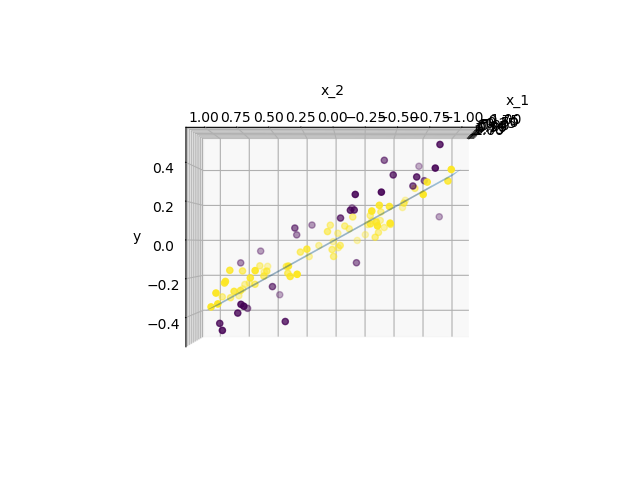

In [39]:
results = test_dataset(X, y, z, A, lmbda, mu, linear_ineq=True)
print(results, np.count_nonzero(results))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], y, c=results)

# we plot the plane from which the datapoints are generated
x_1_true = np.linspace(-1,1,10)
x_2_true = np.linspace(-1,1,10)
X_1_true, X_2_true = np.meshgrid(x_1_true, x_2_true)
y_real = true_params[0] * X_1_true + true_params[1] * X_2_true
ax.plot_surface(X_1_true, X_2_true, y_real, alpha=0.5)
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_zlabel('y')
plt.show()

The more we regularize, the lower the coefficient must be : the real model cannot be recovered and the screened points describe the plane that would be recovered using a Lasso with such lambda (to be verified). This probably explains why less datapoints are screened : since the solution that will be recovered by the Lasso with such lambda is less close to the ground truth, more points are going to pass the test (i.e prediction far from the ground truth) and not be discarded!

In [40]:
X_screened = []
y_screened = []
for i in range(X.shape[0]):
    if results[i] == 0:
        X_screened.append(X[i,:])
        y_screened.append(y[i])
X_screened = np.asarray(X_screened)
y_screened = np.asarray(y_screened)

X_r, y_r = random_screening(X, y, X_screened.shape[0])
print(X.shape, X_screened.shape, X_r.shape)

lasso, _ = find_best_lasso(X,y)
lasso_screened, _ = find_best_lasso(X_screened, y_screened)
lasso_r, _ = find_best_lasso(X_r, y_r)
print(lasso.score(X,y), lasso_screened.score(X,y), lasso_r.score(X,y))
print(lasso, lasso_screened, lasso_r)

(100, 2) (30, 2) (30, 2)
Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
0.835089536161 0.807008302363 0.813510544275
Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False) Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='c

Let us plot the result.

<IPython.core.display.Javascript object>


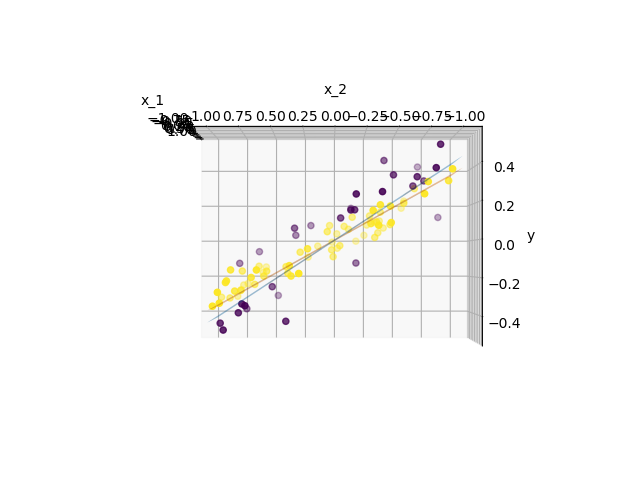

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], y, c=results)

# we plot the plane from which the datapoints are generated
x_1_true = np.linspace(-1,1,10)
x_2_true = np.linspace(-1,1,10)
X_1_true, X_2_true = np.meshgrid(x_1_true, x_2_true)
y_screened = lasso_screened.coef_[0] * X_1_true + lasso_screened.coef_[1] * X_2_true
ax.plot_surface(X_1_true, X_2_true, y_screened, alpha=0.5)
y_regular = lasso.coef_[0] * X_1_true + lasso.coef_[1] * X_2_true
ax.plot_surface(X_1_true, X_2_true, y_regular, alpha=0.5)
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_zlabel('y')
plt.show()

## Synthetic dataset with n < p

2.46937112438
Time to compute z and A: 9.392754554748535
Time to rank the entire dataset: 0.1483166217803955
(80, 1001) (79, 1001)
(79, 1001)
Lasso(alpha=0.01, copy_X=True, fit_intercept=False, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
Lasso(alpha=0.01, copy_X=True, fit_intercept=False, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
Lasso(alpha=0.01, copy_X=True, fit_intercept=False, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
Lasso(alpha=0.01, copy_X=True, fit_intercept=False, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
Lasso(alpha=0.01, copy_X=True, fit_intercept=False, max_iter=10000,
   normalize=F

Lasso(alpha=0.001, copy_X=True, fit_intercept=False, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
Lasso(alpha=0.01, copy_X=True, fit_intercept=False, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
Lasso(alpha=0.01, copy_X=True, fit_intercept=False, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
Lasso(alpha=0.001, copy_X=True, fit_intercept=False, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
(80, 1001) (61, 1001)
(61, 1001)
Lasso(alpha=0.01, copy_X=True, fit_intercept=False, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=Fa

Lasso(alpha=0.01, copy_X=True, fit_intercept=False, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
Lasso(alpha=0.01, copy_X=True, fit_intercept=False, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
Lasso(alpha=0.01, copy_X=True, fit_intercept=False, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
Lasso(alpha=0.1, copy_X=True, fi

Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
(80, 1001) (29, 1001)
(29, 1001)
Lasso(alpha=0.01, copy_X=True, fit_intercept=False, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
Lasso(alpha=1, copy_X=True, fit_intercept=False, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
Lasso(alpha=0.01, copy_X=True, fit_intercept=False, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
La

Lasso(alpha=1, copy_X=True, fit_intercept=False, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
Lasso(alpha=0.01, copy_X=True, fit_intercept=False, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
Lasso(alpha=1, copy_X=True, fit_intercept=False, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
Lasso(alpha=0.001, copy_X=True, fit_intercept=False, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
(80, 1001) (10, 1001)
(10, 1001)
Lasso(alpha=0.01, copy_X=True, fit_intercept=False, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
La

<IPython.core.display.Javascript object>


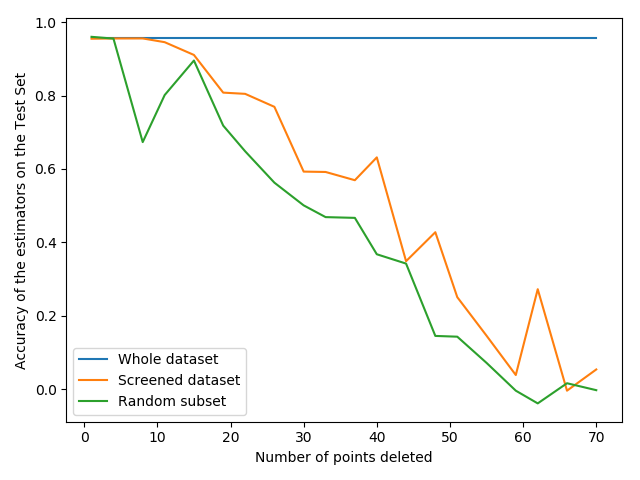

In [42]:
nb_datapoints = 100
dimension = 1000
sparsity = 10
print(np.sqrt(np.log(dimension)) * noise_norm)
param_set = (nb_datapoints, dimension, sparsity / dimension)
X, y, true_params, noise_norm = make_data(param_set)

experiment_real(X,y, nb_delete_steps=20, lmbda=np.sqrt(np.log(dimension)) * noise_norm, 
                intercept=False, n_ellipsoid_steps=1000, nb_test=3)

In [16]:
def screen(X, y, scores, nb_to_delete):
    X_screened = X
    y_screened = y
    idx_to_delete = np.argsort(scores)[0:nb_to_delete]
    X_screened = np.delete(X, idx_to_delete, 0)
    y_screened = np.delete(y, idx_to_delete, 0)
    return X_screened, y_screened

def experiment(nb_datapoints, nb_to_delete, dimension, sparsity, nb_exp, nb_iter):
    
    #print('More points in the dataset than the theoretical limit :', 
          #nb_datapoints > np.log(dimension) * sparsity,
         #'More points in the screened dataset than the theoretica limit :',
          #nb_datapoints - nb_to_delete > np.log(dimension) * sparsity)
    
    compt = 0
    score_regular = 0
    score_screened = 0
    score_r = 0
    dist_regular = 0
    dist_r = 0
    dist_screened = 0
    while compt< nb_exp:
        compt += 1
        X, y, true_params, noise_norm = make_data([2 * nb_datapoints, dimension, sparsity / dimension])
        X_train = X[0:nb_datapoints]
        X_test = X[nb_datapoints:]
        y_train = y[0:nb_datapoints]
        y_test = y[nb_datapoints:]
        z_init = np.zeros(dimension)
        A_init = np.sqrt(dimension) * np.identity(dimension)
        lmbda =  np.sqrt(np.log(dimension)) * noise_norm
        mu = 1 # mu seems not to have any effect on the scores.
        z, scaling, L, I_k_vec = iterate_ellipsoids_accelerated_(X_train, y_train, z_init, np.sqrt(dimension)
                                              , lmbda, mu, nb_iter)
        scores = rank_dataset_accelerated(X_train, y_train, z, scaling, L, I_k_vec, lmbda, mu)
        X_screened, y_screened = screen(X_train, y_train, scores, nb_to_delete)
        X_r, y_r = random_screening(X_train, y_train, X_screened.shape[0])
        
        if compt == 1:
            print(X_train.shape, X_screened.shape, X_r.shape)
            
        lasso_regular, _ = find_best_lasso(X_train,y_train)
        lasso_screened, _ = find_best_lasso(X_screened, y_screened)
        lasso_r, _ = find_best_lasso(X_r, y_r)
        
        score_regular += lasso_regular.score(X_test, y_test)
        score_screened += lasso_screened.score(X_test, y_test)
        score_r += lasso_r.score(X_test, y_test)
        dist_regular += np.linalg.norm(true_params - lasso_regular.coef_)
        dist_screened += np.linalg.norm(true_params - lasso_screened.coef_)
        dist_r += np.linalg.norm(true_params - lasso_r.coef_)
    
    return score_regular / nb_exp, score_screened / nb_exp, score_r / nb_exp

def experiment_old(nb_datapoints, nb_to_delete, dimension, sparsity, nb_exp, nb_iter):    
    compt = 0
    score_regular = 0
    score_screened = 0
    score_r = 0
    dist_regular = 0
    dist_r = 0
    dist_screened = 0
    while compt< nb_exp:
        compt += 1
        X, y, true_params, noise_norm = make_data([2 * nb_datapoints, dimension, sparsity / dimension])
        X_train = X[0:nb_datapoints]
        X_test = X[nb_datapoints:]
        y_train = y[0:nb_datapoints]
        y_test = y[nb_datapoints:]
        z_init = np.zeros(dimension)
        A_init = np.sqrt(dimension) * np.identity(dimension)
        lmbda =  np.sqrt(np.log(dimension)) * noise_norm
        mu = 1 # mu seems not to have any effect on the scores.
        z, A = iterate_ellipsoids(X_train, y_train, z_init, 
                    np.sqrt(dimension) * np.identity(dimension), lmbda, mu, nb_iter)
        scores = rank_dataset(X_train, y_train, z, A, lmbda, mu)
        X_screened, y_screened = screen(X_train, y_train, scores, nb_to_delete)
        X_r, y_r = random_screening(X_train, y_train, X_screened.shape[0])
        
        if compt == 1:
            print(X_train.shape, X_screened.shape, X_r.shape)
            
        lasso_regular, _ = find_best_lasso(X_train,y_train)
        lasso_screened, _ = find_best_lasso(X_screened, y_screened)
        lasso_r, _ = find_best_lasso(X_r, y_r)
        
        score_regular += lasso_regular.score(X_test, y_test)
        score_screened += lasso_screened.score(X_test, y_test)
        score_r += lasso_r.score(X_test, y_test)
        dist_regular += np.linalg.norm(true_params - lasso_regular.coef_)
        dist_screened += np.linalg.norm(true_params - lasso_screened.coef_)
        dist_r += np.linalg.norm(true_params - lasso_r.coef_)
    
    return score_regular / nb_exp, score_screened / nb_exp, score_r / nb_exp

Ecrire une fonction pour générer une expérience qui vérifie les hypothèses de Lasso. Important: on base le screening sur le lambda qui serait utilisé pour le Lasso global. Ensuite, on fitte un Lasso sur le dataset restant et lambda est alors cross-validé. Plot score = f(points enlevés ?)

Time to compute z and A: 4.210965156555176
Time to rank the entire dataset: 0.08553075790405273
(100, 500) (90, 500) (90, 500)
Time to compute z and A: 4.614780426025391
Time to rank the entire dataset: 0.08065605163574219
Time to compute z and A: 3.8198015689849854
Time to rank the entire dataset: 0.07103443145751953
Time to compute z and A: 3.652690887451172
Time to rank the entire dataset: 0.07242941856384277
(100, 500) (80, 500) (80, 500)
Time to compute z and A: 4.027817964553833
Time to rank the entire dataset: 0.07171869277954102
Time to compute z and A: 4.076409101486206
Time to rank the entire dataset: 0.07528471946716309
Time to compute z and A: 4.370235919952393
Time to rank the entire dataset: 0.08092021942138672
(100, 500) (70, 500) (70, 500)
Time to compute z and A: 4.363300800323486
Time to rank the entire dataset: 0.07393717765808105
Time to compute z and A: 4.15997314453125
Time to rank the entire dataset: 0.08113622665405273
Time to compute z and A: 4.25361967086792
T

<IPython.core.display.Javascript object>


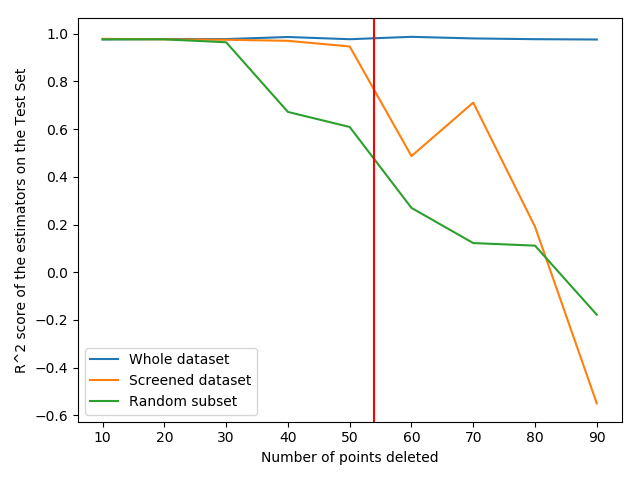

Time to test the entire dataset: 0.02802276611328125
(100, 500) (90, 500) (90, 500)
Time to test the entire dataset: 0.02897787094116211
Time to test the entire dataset: 0.029762744903564453
Time to test the entire dataset: 0.024423599243164062
(100, 500) (80, 500) (80, 500)
Time to test the entire dataset: 0.03456282615661621
Time to test the entire dataset: 0.03299546241760254
Time to test the entire dataset: 0.028026342391967773
(100, 500) (70, 500) (70, 500)
Time to test the entire dataset: 0.0363771915435791
Time to test the entire dataset: 0.024097919464111328
Time to test the entire dataset: 0.027211427688598633
(100, 500) (60, 500) (60, 500)
Time to test the entire dataset: 0.03025650978088379
Time to test the entire dataset: 0.0285491943359375
Time to test the entire dataset: 0.026109933853149414
(100, 500) (50, 500) (50, 500)
Time to test the entire dataset: 0.029895305633544922
Time to test the entire dataset: 0.022724151611328125
Time to test the entire dataset: 0.031523227

<IPython.core.display.Javascript object>


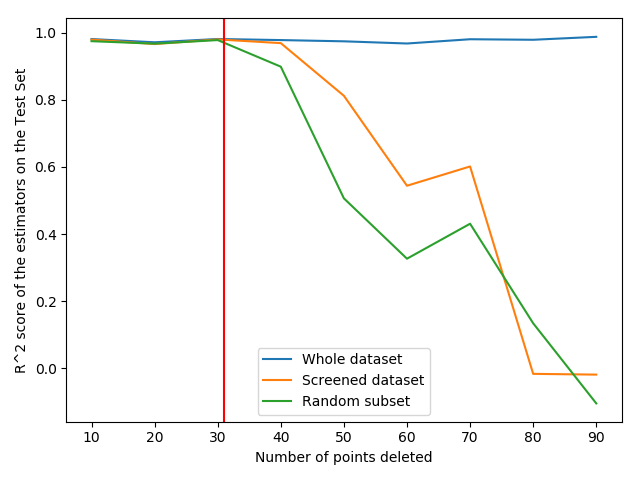

In [35]:
scores_regular = []
scores_screened = []
scores_r= []

nb_to_del_table = [10, 20, 30, 40, 50, 60, 70, 80, 90]

for i in nb_to_del_table:
    score_regular, score_screened, score_r = experiment(nb_datapoints=100,
                        nb_to_delete=i, dimension=500, sparsity=10, nb_exp=3, nb_iter=1000)
    scores_regular.append(score_regular)
    scores_screened.append(score_screened)
    scores_r.append(score_r)

fig, ax1 = plt.subplots()
ax1.plot(nb_to_del_table, scores_regular, label='Whole dataset')
ax1.plot(nb_to_del_table, scores_screened, label='Screened dataset')
ax1.plot(nb_to_del_table, scores_r, label='Random subset')
ax1.set_xlabel('Number of points deleted')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('R^2 score of the estimators on the Test Set')
ax1.tick_params('y')
plt.axvline(x= 100 - 10 * np.log(100), color='red')
fig.tight_layout()
ax1.legend()
plt.show()

scores_regular = []
scores_screened = []
scores_r= []

for i in nb_to_del_table:
    score_regular, score_screened, score_r = experiment_old(nb_datapoints=100,
                        nb_to_delete=i, dimension=500, sparsity=10, nb_exp=3, nb_iter=1000)
    scores_regular.append(score_regular)
    scores_screened.append(score_screened)
    scores_r.append(score_r)

fig, ax1 = plt.subplots()
ax1.plot(nb_to_del_table, scores_regular, label='Whole dataset')
ax1.plot(nb_to_del_table, scores_screened, label='Screened dataset')
ax1.plot(nb_to_del_table, scores_r, label='Random subset')
ax1.set_xlabel('Number of points deleted')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('R^2 score of the estimators on the Test Set')
ax1.tick_params('y')
plt.axvline(x= 100 - 10 * np.log(1000), color='red')
fig.tight_layout()
ax1.legend()
plt.show()

# Leukemia

In [7]:
import pandas as pd 

regular_path = '/nas/home2/g/gmialon/research/datasets/leukemia_big.csv'
laptop_path = '/Users/gregoire/Desktop/research/datasets/leukemia_big.csv'
l_data = pd.read_csv(regular_path)

def create_X_y(data):
    
    X = np.transpose(data.values)
    X = np.concatenate((X, np.ones(X.shape[0]).reshape(1,-1).T), axis=1)
    y_ = data.columns.values
    y = np.ones(len(y_))
    for i in range(len(y_)):
        if 'AML' in y_[i]:
            y[i] = -1
    return X, y

X, y = create_X_y(l_data)
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
lasso_regular, _ = find_best_lasso(X_train,y_train, intercept=False)
print(lasso_regular.score(X_test, y_test), lasso_regular.intercept_)

(72, 7129)
0.734745746044 0.0


In [14]:
def scoring_classif(estimator, X, y):
    
    score = 0
    
    for i in range(len(y)):
        if estimator.predict(X[i].reshape(1, -1))* y[i] > 0:
            score += 1

    return score / len(y)
    
def experiment_real(X, y, nb_delete_steps, lmbda, intercept, classification=False,
                    n_ellipsoid_steps=100, nb_test=3):
    
    if not(intercept):
        X = np.concatenate((X, np.ones(X.shape[0]).reshape(1,-1).T), axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        
    z_init = np.zeros(X_train.shape[1])
    A_init = np.sqrt(X_train.shape[1]) * np.identity(X_train.shape[1])
    #lmbda =  0.1 * np.sqrt(np.log(X_train.shape[1])) # is it ok ?
    mu = 1
    z, scaling, L, I_k_vec = iterate_ellipsoids_accelerated_(X_train, y_train, z_init,
                                              np.sqrt(X_train.shape[1]), 
                                              lmbda, mu, n_ellipsoid_steps)
    scores = rank_dataset_accelerated(X_train, y_train, z, scaling, L, I_k_vec,
                                         lmbda, mu)
      
    scores_regular = []
    scores_screened = []
    scores_r= []
    
    nb_to_del_table = np.linspace(1, X_train.shape[0] - 10, nb_delete_steps, dtype='int')
     
    for nb_to_delete in nb_to_del_table:
        score_regular = 0
        score_screened = 0
        score_r = 0
        compt = 0
        X_screened, y_screened = screen(X_train, y_train, scores, nb_to_delete)
        print(X_train.shape, X_screened.shape)
        while compt < nb_test:
            compt += 1
            random.seed(compt)
            np.random.seed(compt)
            X_r, y_r = random_screening(X_train, y_train, X_train.shape[0] - nb_to_delete)
            if compt == 1:
                print(X_r.shape)
            lasso_regular, _ = find_best_lasso(X_train,y_train, intercept=intercept)
            lasso_screened, _ = find_best_lasso(X_screened, y_screened, intercept=intercept)
            lasso_r, _ = find_best_lasso(X_r, y_r,  intercept=intercept)

            if classification:
                score_regular += scoring_classif(lasso_regular, X_test, y_test)
                score_screened += scoring_classif(lasso_screened, X_test, y_test)
                score_r += scoring_classif(lasso_r, X_test, y_test)
            else:
                score_regular += lasso_regular.score(X_test, y_test)
                score_screened += lasso_screened.score(X_test, y_test)
                score_r += lasso_r.score(X_test, y_test)
        
        scores_regular.append(score_regular / nb_test)
        scores_screened.append(score_screened / nb_test)
        scores_r.append(score_r / nb_test)

    fig, ax1 = plt.subplots()
    ax1.plot(nb_to_del_table, scores_regular, label='Whole dataset')
    ax1.plot(nb_to_del_table, scores_screened, label='Screened dataset')
    ax1.plot(nb_to_del_table, scores_r, label='Random subset')
    ax1.set_xlabel('Number of points deleted')
    ax1.set_ylabel('Accuracy of the estimators on the Test Set')
    ax1.tick_params('y')
    fig.tight_layout()
    ax1.legend()
    plt.show()
    
    return

Time to compute z and A: 61.15046286582947
Time to rank the entire dataset: 1.2756876945495605
(57, 7129) (56, 7129)
(56, 7129)
(57, 7129) (54, 7129)
(54, 7129)
(57, 7129) (52, 7129)
(52, 7129)
(57, 7129) (49, 7129)
(49, 7129)
(57, 7129) (47, 7129)
(47, 7129)
(57, 7129) (44, 7129)
(44, 7129)
(57, 7129) (42, 7129)
(42, 7129)
(57, 7129) (40, 7129)
(40, 7129)
(57, 7129) (37, 7129)
(37, 7129)
(57, 7129) (35, 7129)
(35, 7129)
(57, 7129) (32, 7129)
(32, 7129)
(57, 7129) (30, 7129)
(30, 7129)
(57, 7129) (27, 7129)
(27, 7129)
(57, 7129) (25, 7129)
(25, 7129)
(57, 7129) (23, 7129)
(23, 7129)
(57, 7129) (20, 7129)
(20, 7129)
(57, 7129) (18, 7129)
(18, 7129)
(57, 7129) (15, 7129)
(15, 7129)
(57, 7129) (13, 7129)
(13, 7129)
(57, 7129) (10, 7129)
(10, 7129)


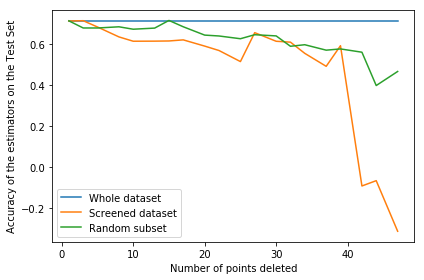

Intercept True lmbda 0.0001 Ellipsoid steps 1000 Leukemia
Time to compute z and A: 51.471821546554565
Time to rank the entire dataset: 1.1080975532531738
(57, 7129) (56, 7129)
(56, 7129)
(57, 7129) (54, 7129)
(54, 7129)
(57, 7129) (52, 7129)
(52, 7129)
(57, 7129) (49, 7129)
(49, 7129)
(57, 7129) (47, 7129)
(47, 7129)
(57, 7129) (44, 7129)
(44, 7129)
(57, 7129) (42, 7129)
(42, 7129)
(57, 7129) (40, 7129)
(40, 7129)
(57, 7129) (37, 7129)
(37, 7129)
(57, 7129) (35, 7129)
(35, 7129)
(57, 7129) (32, 7129)
(32, 7129)
(57, 7129) (30, 7129)
(30, 7129)
(57, 7129) (27, 7129)
(27, 7129)
(57, 7129) (25, 7129)
(25, 7129)
(57, 7129) (23, 7129)
(23, 7129)
(57, 7129) (20, 7129)
(20, 7129)
(57, 7129) (18, 7129)
(18, 7129)
(57, 7129) (15, 7129)
(15, 7129)
(57, 7129) (13, 7129)
(13, 7129)
(57, 7129) (10, 7129)
(10, 7129)


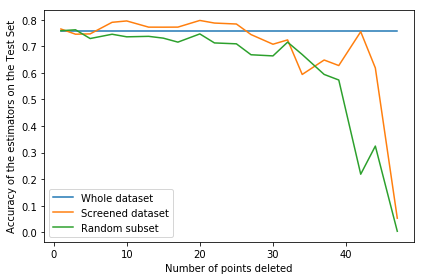

Intercept True lmbda 0.001 Ellipsoid steps 1000 Leukemia
Time to compute z and A: 50.74230456352234
Time to rank the entire dataset: 1.4184517860412598
(57, 7129) (56, 7129)
(56, 7129)
(57, 7129) (54, 7129)
(54, 7129)
(57, 7129) (52, 7129)
(52, 7129)
(57, 7129) (49, 7129)
(49, 7129)
(57, 7129) (47, 7129)
(47, 7129)
(57, 7129) (44, 7129)
(44, 7129)
(57, 7129) (42, 7129)
(42, 7129)
(57, 7129) (40, 7129)
(40, 7129)
(57, 7129) (37, 7129)
(37, 7129)
(57, 7129) (35, 7129)
(35, 7129)
(57, 7129) (32, 7129)
(32, 7129)
(57, 7129) (30, 7129)
(30, 7129)
(57, 7129) (27, 7129)
(27, 7129)
(57, 7129) (25, 7129)
(25, 7129)
(57, 7129) (23, 7129)
(23, 7129)
(57, 7129) (20, 7129)
(20, 7129)
(57, 7129) (18, 7129)
(18, 7129)
(57, 7129) (15, 7129)
(15, 7129)
(57, 7129) (13, 7129)
(13, 7129)
(57, 7129) (10, 7129)
(10, 7129)


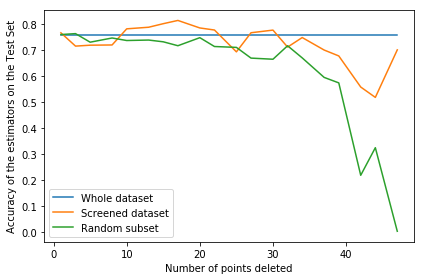

Intercept True lmbda 0.01 Ellipsoid steps 1000 Leukemia
Time to compute z and A: 52.50728464126587
Time to rank the entire dataset: 1.5501680374145508
(57, 7129) (56, 7129)
(56, 7129)
(57, 7129) (54, 7129)
(54, 7129)
(57, 7129) (52, 7129)
(52, 7129)
(57, 7129) (49, 7129)
(49, 7129)
(57, 7129) (47, 7129)
(47, 7129)
(57, 7129) (44, 7129)
(44, 7129)
(57, 7129) (42, 7129)
(42, 7129)
(57, 7129) (40, 7129)
(40, 7129)
(57, 7129) (37, 7129)
(37, 7129)
(57, 7129) (35, 7129)
(35, 7129)
(57, 7129) (32, 7129)
(32, 7129)
(57, 7129) (30, 7129)
(30, 7129)
(57, 7129) (27, 7129)
(27, 7129)
(57, 7129) (25, 7129)
(25, 7129)
(57, 7129) (23, 7129)
(23, 7129)
(57, 7129) (20, 7129)
(20, 7129)
(57, 7129) (18, 7129)
(18, 7129)
(57, 7129) (15, 7129)
(15, 7129)
(57, 7129) (13, 7129)
(13, 7129)
(57, 7129) (10, 7129)
(10, 7129)


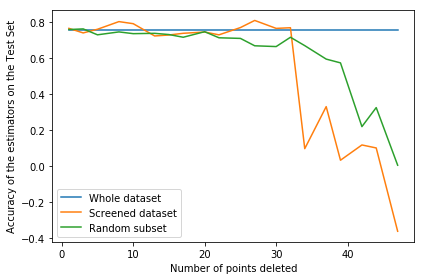

Intercept True lmbda 0.1 Ellipsoid steps 1000 Leukemia
Time to compute z and A: 55.03317451477051
Time to rank the entire dataset: 1.5450387001037598
(57, 7129) (56, 7129)
(56, 7129)
(57, 7129) (54, 7129)
(54, 7129)
(57, 7129) (52, 7129)
(52, 7129)
(57, 7129) (49, 7129)
(49, 7129)
(57, 7129) (47, 7129)
(47, 7129)
(57, 7129) (44, 7129)
(44, 7129)
(57, 7129) (42, 7129)
(42, 7129)
(57, 7129) (40, 7129)
(40, 7129)
(57, 7129) (37, 7129)
(37, 7129)
(57, 7129) (35, 7129)
(35, 7129)
(57, 7129) (32, 7129)
(32, 7129)
(57, 7129) (30, 7129)
(30, 7129)
(57, 7129) (27, 7129)
(27, 7129)
(57, 7129) (25, 7129)
(25, 7129)
(57, 7129) (23, 7129)
(23, 7129)
(57, 7129) (20, 7129)
(20, 7129)
(57, 7129) (18, 7129)
(18, 7129)
(57, 7129) (15, 7129)
(15, 7129)
(57, 7129) (13, 7129)
(13, 7129)
(57, 7129) (10, 7129)
(10, 7129)


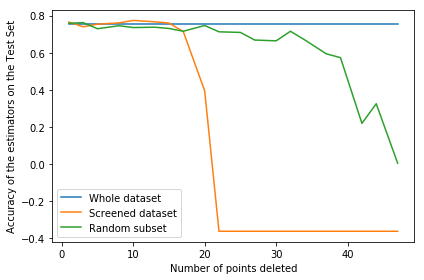

Intercept True lmbda 1.0 Ellipsoid steps 1000 Leukemia
Time to compute z and A: 51.87279391288757
Time to rank the entire dataset: 1.4786427021026611
(57, 7129) (56, 7129)
(56, 7129)
(57, 7129) (54, 7129)
(54, 7129)
(57, 7129) (52, 7129)
(52, 7129)
(57, 7129) (49, 7129)
(49, 7129)
(57, 7129) (47, 7129)
(47, 7129)
(57, 7129) (44, 7129)
(44, 7129)
(57, 7129) (42, 7129)
(42, 7129)
(57, 7129) (40, 7129)
(40, 7129)
(57, 7129) (37, 7129)
(37, 7129)
(57, 7129) (35, 7129)
(35, 7129)
(57, 7129) (32, 7129)
(32, 7129)
(57, 7129) (30, 7129)
(30, 7129)
(57, 7129) (27, 7129)
(27, 7129)
(57, 7129) (25, 7129)
(25, 7129)
(57, 7129) (23, 7129)
(23, 7129)
(57, 7129) (20, 7129)
(20, 7129)
(57, 7129) (18, 7129)
(18, 7129)
(57, 7129) (15, 7129)
(15, 7129)
(57, 7129) (13, 7129)
(13, 7129)
(57, 7129) (10, 7129)
(10, 7129)


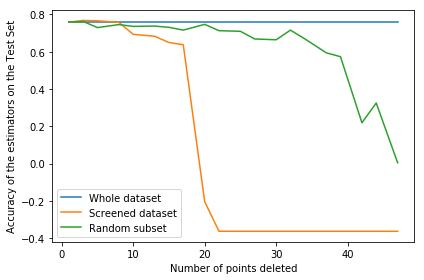

Intercept True lmbda 10.0 Ellipsoid steps 1000 Leukemia
Time to compute z and A: 48.868001222610474
Time to rank the entire dataset: 1.5333330631256104
(57, 7130) (56, 7130)
(56, 7130)
(57, 7130) (54, 7130)
(54, 7130)
(57, 7130) (52, 7130)
(52, 7130)
(57, 7130) (49, 7130)
(49, 7130)
(57, 7130) (47, 7130)
(47, 7130)
(57, 7130) (44, 7130)
(44, 7130)
(57, 7130) (42, 7130)
(42, 7130)
(57, 7130) (40, 7130)
(40, 7130)
(57, 7130) (37, 7130)
(37, 7130)
(57, 7130) (35, 7130)
(35, 7130)
(57, 7130) (32, 7130)
(32, 7130)
(57, 7130) (30, 7130)
(30, 7130)
(57, 7130) (27, 7130)
(27, 7130)
(57, 7130) (25, 7130)
(25, 7130)
(57, 7130) (23, 7130)
(23, 7130)
(57, 7130) (20, 7130)
(20, 7130)
(57, 7130) (18, 7130)
(18, 7130)
(57, 7130) (15, 7130)
(15, 7130)
(57, 7130) (13, 7130)
(13, 7130)
(57, 7130) (10, 7130)
(10, 7130)


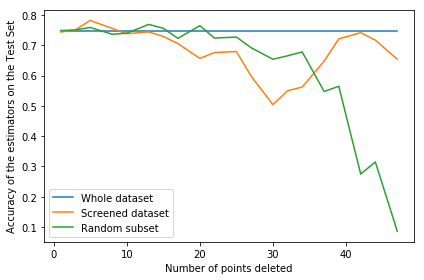

Intercept False lmbda 0.0001 Ellipsoid steps 1000 Leukemia
Time to compute z and A: 48.97686052322388
Time to rank the entire dataset: 1.4651646614074707
(57, 7130) (56, 7130)
(56, 7130)
(57, 7130) (54, 7130)
(54, 7130)
(57, 7130) (52, 7130)
(52, 7130)
(57, 7130) (49, 7130)
(49, 7130)
(57, 7130) (47, 7130)
(47, 7130)
(57, 7130) (44, 7130)
(44, 7130)
(57, 7130) (42, 7130)
(42, 7130)
(57, 7130) (40, 7130)
(40, 7130)
(57, 7130) (37, 7130)
(37, 7130)
(57, 7130) (35, 7130)
(35, 7130)
(57, 7130) (32, 7130)
(32, 7130)
(57, 7130) (30, 7130)
(30, 7130)
(57, 7130) (27, 7130)
(27, 7130)
(57, 7130) (25, 7130)
(25, 7130)
(57, 7130) (23, 7130)
(23, 7130)
(57, 7130) (20, 7130)
(20, 7130)
(57, 7130) (18, 7130)
(18, 7130)
(57, 7130) (15, 7130)
(15, 7130)
(57, 7130) (13, 7130)
(13, 7130)
(57, 7130) (10, 7130)
(10, 7130)


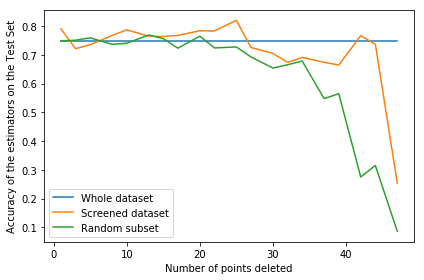

Intercept False lmbda 0.001 Ellipsoid steps 1000 Leukemia
Time to compute z and A: 50.04049849510193
Time to rank the entire dataset: 1.444812536239624
(57, 7130) (56, 7130)
(56, 7130)
(57, 7130) (54, 7130)
(54, 7130)
(57, 7130) (52, 7130)
(52, 7130)
(57, 7130) (49, 7130)
(49, 7130)
(57, 7130) (47, 7130)
(47, 7130)
(57, 7130) (44, 7130)
(44, 7130)
(57, 7130) (42, 7130)
(42, 7130)
(57, 7130) (40, 7130)
(40, 7130)
(57, 7130) (37, 7130)
(37, 7130)
(57, 7130) (35, 7130)
(35, 7130)
(57, 7130) (32, 7130)
(32, 7130)
(57, 7130) (30, 7130)
(30, 7130)
(57, 7130) (27, 7130)
(27, 7130)
(57, 7130) (25, 7130)
(25, 7130)
(57, 7130) (23, 7130)
(23, 7130)
(57, 7130) (20, 7130)
(20, 7130)
(57, 7130) (18, 7130)
(18, 7130)
(57, 7130) (15, 7130)
(15, 7130)
(57, 7130) (13, 7130)
(13, 7130)
(57, 7130) (10, 7130)
(10, 7130)


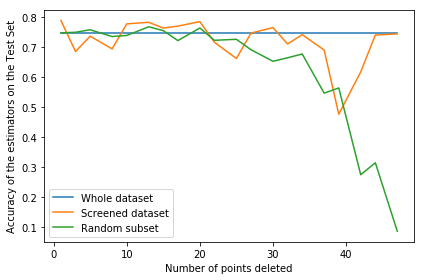

Intercept False lmbda 0.01 Ellipsoid steps 1000 Leukemia
Time to compute z and A: 49.2758092880249
Time to rank the entire dataset: 1.440539836883545
(57, 7130) (56, 7130)
(56, 7130)
(57, 7130) (54, 7130)
(54, 7130)
(57, 7130) (52, 7130)
(52, 7130)
(57, 7130) (49, 7130)
(49, 7130)
(57, 7130) (47, 7130)
(47, 7130)
(57, 7130) (44, 7130)
(44, 7130)
(57, 7130) (42, 7130)
(42, 7130)
(57, 7130) (40, 7130)
(40, 7130)
(57, 7130) (37, 7130)
(37, 7130)
(57, 7130) (35, 7130)
(35, 7130)
(57, 7130) (32, 7130)
(32, 7130)
(57, 7130) (30, 7130)
(30, 7130)
(57, 7130) (27, 7130)
(27, 7130)
(57, 7130) (25, 7130)
(25, 7130)
(57, 7130) (23, 7130)
(23, 7130)
(57, 7130) (20, 7130)
(20, 7130)
(57, 7130) (18, 7130)
(18, 7130)
(57, 7130) (15, 7130)
(15, 7130)
(57, 7130) (13, 7130)
(13, 7130)
(57, 7130) (10, 7130)
(10, 7130)


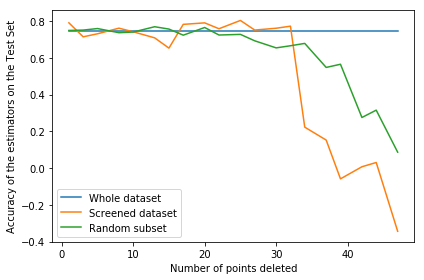

Intercept False lmbda 0.1 Ellipsoid steps 1000 Leukemia
Time to compute z and A: 49.61899971961975
Time to rank the entire dataset: 1.45455002784729
(57, 7130) (56, 7130)
(56, 7130)
(57, 7130) (54, 7130)
(54, 7130)
(57, 7130) (52, 7130)
(52, 7130)
(57, 7130) (49, 7130)
(49, 7130)
(57, 7130) (47, 7130)
(47, 7130)
(57, 7130) (44, 7130)
(44, 7130)
(57, 7130) (42, 7130)
(42, 7130)
(57, 7130) (40, 7130)
(40, 7130)
(57, 7130) (37, 7130)
(37, 7130)
(57, 7130) (35, 7130)
(35, 7130)
(57, 7130) (32, 7130)
(32, 7130)
(57, 7130) (30, 7130)
(30, 7130)
(57, 7130) (27, 7130)
(27, 7130)
(57, 7130) (25, 7130)
(25, 7130)
(57, 7130) (23, 7130)
(23, 7130)
(57, 7130) (20, 7130)
(20, 7130)
(57, 7130) (18, 7130)
(18, 7130)
(57, 7130) (15, 7130)
(15, 7130)
(57, 7130) (13, 7130)
(13, 7130)
(57, 7130) (10, 7130)
(10, 7130)


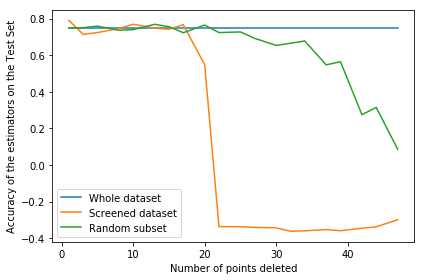

Intercept False lmbda 1.0 Ellipsoid steps 1000 Leukemia
Time to compute z and A: 49.78472924232483
Time to rank the entire dataset: 1.4544336795806885
(57, 7130) (56, 7130)
(56, 7130)
(57, 7130) (54, 7130)
(54, 7130)
(57, 7130) (52, 7130)
(52, 7130)
(57, 7130) (49, 7130)
(49, 7130)
(57, 7130) (47, 7130)
(47, 7130)
(57, 7130) (44, 7130)
(44, 7130)
(57, 7130) (42, 7130)
(42, 7130)
(57, 7130) (40, 7130)
(40, 7130)
(57, 7130) (37, 7130)
(37, 7130)
(57, 7130) (35, 7130)
(35, 7130)
(57, 7130) (32, 7130)
(32, 7130)
(57, 7130) (30, 7130)
(30, 7130)
(57, 7130) (27, 7130)
(27, 7130)
(57, 7130) (25, 7130)
(25, 7130)
(57, 7130) (23, 7130)
(23, 7130)
(57, 7130) (20, 7130)
(20, 7130)
(57, 7130) (18, 7130)
(18, 7130)
(57, 7130) (15, 7130)
(15, 7130)
(57, 7130) (13, 7130)
(13, 7130)
(57, 7130) (10, 7130)
(10, 7130)


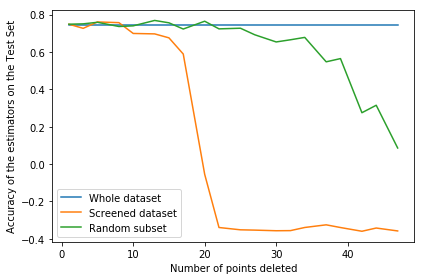

Intercept False lmbda 10.0 Ellipsoid steps 1000 Leukemia


In [9]:
X, y = create_X_y(l_data)

for intercept in [True, False]:
    for lmbda in [0.0001, 0.001, 0.01, 0.1, 1., 10.]:
        for n_ellipsoid_steps in [1000]:
            experiment_real(X, y, nb_delete_steps=20, lmbda=lmbda, intercept=intercept, 
                            n_ellipsoid_steps=n_ellipsoid_steps, nb_test=3)
            print('Intercept', intercept, 'lmbda', lmbda, 'Ellipsoid steps', n_ellipsoid_steps,
                   'Leukemia')

Time to compute z and A: 2619.4995822906494
Time to rank the entire dataset: 13.820235252380371
(57, 7129) (56, 7129)
(56, 7129)
(57, 7129) (54, 7129)
(54, 7129)
(57, 7129) (52, 7129)
(52, 7129)
(57, 7129) (49, 7129)
(49, 7129)
(57, 7129) (47, 7129)
(47, 7129)
(57, 7129) (44, 7129)
(44, 7129)
(57, 7129) (42, 7129)
(42, 7129)
(57, 7129) (40, 7129)
(40, 7129)
(57, 7129) (37, 7129)
(37, 7129)
(57, 7129) (35, 7129)
(35, 7129)
(57, 7129) (32, 7129)
(32, 7129)
(57, 7129) (30, 7129)
(30, 7129)
(57, 7129) (27, 7129)
(27, 7129)
(57, 7129) (25, 7129)
(25, 7129)
(57, 7129) (23, 7129)
(23, 7129)
(57, 7129) (20, 7129)
(20, 7129)
(57, 7129) (18, 7129)
(18, 7129)
(57, 7129) (15, 7129)
(15, 7129)
(57, 7129) (13, 7129)
(13, 7129)
(57, 7129) (10, 7129)
(10, 7129)


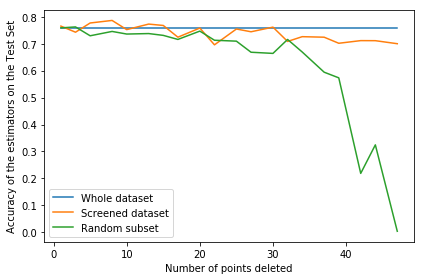

Intercept True lmbda 0.0001 Ellipsoid steps 10000 Leukemia
Time to compute z and A: 2628.748136281967
Time to rank the entire dataset: 12.496282815933228
(57, 7129) (56, 7129)
(56, 7129)
(57, 7129) (54, 7129)
(54, 7129)
(57, 7129) (52, 7129)
(52, 7129)
(57, 7129) (49, 7129)
(49, 7129)
(57, 7129) (47, 7129)
(47, 7129)
(57, 7129) (44, 7129)
(44, 7129)
(57, 7129) (42, 7129)
(42, 7129)
(57, 7129) (40, 7129)
(40, 7129)
(57, 7129) (37, 7129)
(37, 7129)
(57, 7129) (35, 7129)
(35, 7129)
(57, 7129) (32, 7129)
(32, 7129)
(57, 7129) (30, 7129)
(30, 7129)
(57, 7129) (27, 7129)
(27, 7129)
(57, 7129) (25, 7129)
(25, 7129)
(57, 7129) (23, 7129)
(23, 7129)
(57, 7129) (20, 7129)
(20, 7129)
(57, 7129) (18, 7129)
(18, 7129)
(57, 7129) (15, 7129)
(15, 7129)
(57, 7129) (13, 7129)
(13, 7129)
(57, 7129) (10, 7129)
(10, 7129)


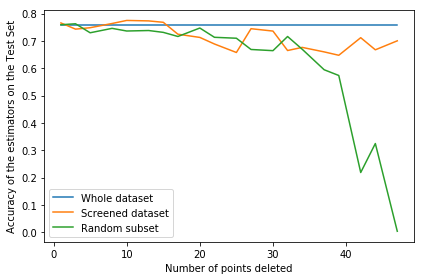

Intercept True lmbda 0.001 Ellipsoid steps 10000 Leukemia
Time to compute z and A: 2618.719184398651
Time to rank the entire dataset: 14.950537919998169
(57, 7129) (56, 7129)
(56, 7129)
(57, 7129) (54, 7129)
(54, 7129)
(57, 7129) (52, 7129)
(52, 7129)
(57, 7129) (49, 7129)
(49, 7129)
(57, 7129) (47, 7129)
(47, 7129)
(57, 7129) (44, 7129)
(44, 7129)
(57, 7129) (42, 7129)
(42, 7129)
(57, 7129) (40, 7129)
(40, 7129)
(57, 7129) (37, 7129)
(37, 7129)
(57, 7129) (35, 7129)
(35, 7129)
(57, 7129) (32, 7129)
(32, 7129)
(57, 7129) (30, 7129)
(30, 7129)
(57, 7129) (27, 7129)
(27, 7129)
(57, 7129) (25, 7129)
(25, 7129)
(57, 7129) (23, 7129)
(23, 7129)
(57, 7129) (20, 7129)
(20, 7129)
(57, 7129) (18, 7129)
(18, 7129)
(57, 7129) (15, 7129)
(15, 7129)
(57, 7129) (13, 7129)
(13, 7129)
(57, 7129) (10, 7129)
(10, 7129)


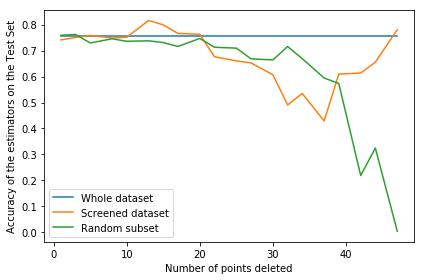

Intercept True lmbda 0.01 Ellipsoid steps 10000 Leukemia
Time to compute z and A: 2634.1260340213776
Time to rank the entire dataset: 14.51886534690857
(57, 7129) (56, 7129)
(56, 7129)
(57, 7129) (54, 7129)
(54, 7129)
(57, 7129) (52, 7129)
(52, 7129)
(57, 7129) (49, 7129)
(49, 7129)
(57, 7129) (47, 7129)
(47, 7129)
(57, 7129) (44, 7129)
(44, 7129)
(57, 7129) (42, 7129)
(42, 7129)
(57, 7129) (40, 7129)
(40, 7129)
(57, 7129) (37, 7129)
(37, 7129)
(57, 7129) (35, 7129)
(35, 7129)
(57, 7129) (32, 7129)
(32, 7129)
(57, 7129) (30, 7129)
(30, 7129)
(57, 7129) (27, 7129)
(27, 7129)
(57, 7129) (25, 7129)
(25, 7129)
(57, 7129) (23, 7129)
(23, 7129)
(57, 7129) (20, 7129)
(20, 7129)
(57, 7129) (18, 7129)
(18, 7129)
(57, 7129) (15, 7129)
(15, 7129)
(57, 7129) (13, 7129)
(13, 7129)
(57, 7129) (10, 7129)
(10, 7129)


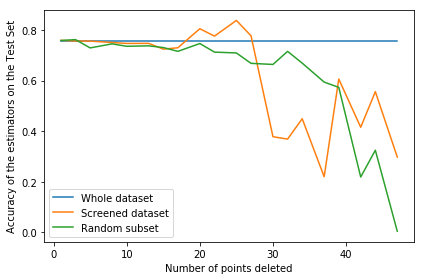

Intercept True lmbda 0.1 Ellipsoid steps 10000 Leukemia
Time to compute z and A: 2629.856597185135
Time to rank the entire dataset: 15.44927978515625
(57, 7129) (56, 7129)
(56, 7129)
(57, 7129) (54, 7129)
(54, 7129)
(57, 7129) (52, 7129)
(52, 7129)
(57, 7129) (49, 7129)
(49, 7129)
(57, 7129) (47, 7129)
(47, 7129)
(57, 7129) (44, 7129)
(44, 7129)
(57, 7129) (42, 7129)
(42, 7129)
(57, 7129) (40, 7129)
(40, 7129)
(57, 7129) (37, 7129)
(37, 7129)
(57, 7129) (35, 7129)
(35, 7129)
(57, 7129) (32, 7129)
(32, 7129)
(57, 7129) (30, 7129)
(30, 7129)
(57, 7129) (27, 7129)
(27, 7129)
(57, 7129) (25, 7129)
(25, 7129)
(57, 7129) (23, 7129)
(23, 7129)
(57, 7129) (20, 7129)
(20, 7129)
(57, 7129) (18, 7129)
(18, 7129)
(57, 7129) (15, 7129)
(15, 7129)
(57, 7129) (13, 7129)
(13, 7129)
(57, 7129) (10, 7129)
(10, 7129)


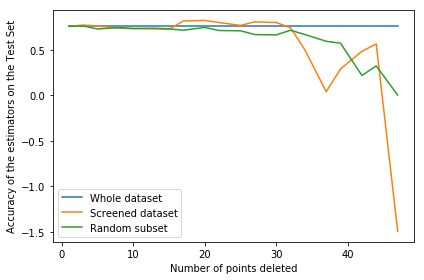

Intercept True lmbda 1.0 Ellipsoid steps 10000 Leukemia
Time to compute z and A: 2621.3244335651398
Time to rank the entire dataset: 15.241366863250732
(57, 7130) (56, 7130)
(56, 7130)
(57, 7130) (54, 7130)
(54, 7130)
(57, 7130) (52, 7130)
(52, 7130)
(57, 7130) (49, 7130)
(49, 7130)
(57, 7130) (47, 7130)
(47, 7130)
(57, 7130) (44, 7130)
(44, 7130)
(57, 7130) (42, 7130)
(42, 7130)
(57, 7130) (40, 7130)
(40, 7130)
(57, 7130) (37, 7130)
(37, 7130)
(57, 7130) (35, 7130)
(35, 7130)
(57, 7130) (32, 7130)
(32, 7130)
(57, 7130) (30, 7130)
(30, 7130)
(57, 7130) (27, 7130)
(27, 7130)
(57, 7130) (25, 7130)
(25, 7130)
(57, 7130) (23, 7130)
(23, 7130)
(57, 7130) (20, 7130)
(20, 7130)
(57, 7130) (18, 7130)
(18, 7130)
(57, 7130) (15, 7130)
(15, 7130)
(57, 7130) (13, 7130)
(13, 7130)
(57, 7130) (10, 7130)
(10, 7130)


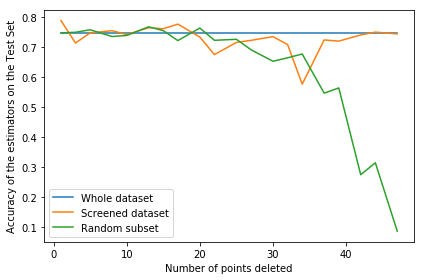

Intercept False lmbda 0.0001 Ellipsoid steps 10000 Leukemia
Time to compute z and A: 2629.5706408023834
Time to rank the entire dataset: 14.598247051239014
(57, 7130) (56, 7130)
(56, 7130)
(57, 7130) (54, 7130)
(54, 7130)
(57, 7130) (52, 7130)
(52, 7130)
(57, 7130) (49, 7130)
(49, 7130)
(57, 7130) (47, 7130)
(47, 7130)
(57, 7130) (44, 7130)
(44, 7130)
(57, 7130) (42, 7130)
(42, 7130)
(57, 7130) (40, 7130)
(40, 7130)
(57, 7130) (37, 7130)
(37, 7130)
(57, 7130) (35, 7130)
(35, 7130)
(57, 7130) (32, 7130)
(32, 7130)
(57, 7130) (30, 7130)
(30, 7130)
(57, 7130) (27, 7130)
(27, 7130)
(57, 7130) (25, 7130)
(25, 7130)
(57, 7130) (23, 7130)
(23, 7130)
(57, 7130) (20, 7130)
(20, 7130)
(57, 7130) (18, 7130)
(18, 7130)
(57, 7130) (15, 7130)
(15, 7130)
(57, 7130) (13, 7130)
(13, 7130)
(57, 7130) (10, 7130)
(10, 7130)


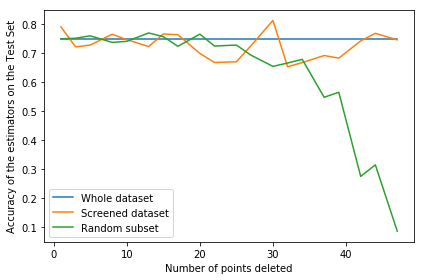

Intercept False lmbda 0.001 Ellipsoid steps 10000 Leukemia
Time to compute z and A: 2625.354402065277
Time to rank the entire dataset: 14.776669025421143
(57, 7130) (56, 7130)
(56, 7130)
(57, 7130) (54, 7130)
(54, 7130)
(57, 7130) (52, 7130)
(52, 7130)
(57, 7130) (49, 7130)
(49, 7130)
(57, 7130) (47, 7130)
(47, 7130)
(57, 7130) (44, 7130)
(44, 7130)
(57, 7130) (42, 7130)
(42, 7130)
(57, 7130) (40, 7130)
(40, 7130)
(57, 7130) (37, 7130)
(37, 7130)
(57, 7130) (35, 7130)
(35, 7130)
(57, 7130) (32, 7130)
(32, 7130)
(57, 7130) (30, 7130)
(30, 7130)
(57, 7130) (27, 7130)
(27, 7130)
(57, 7130) (25, 7130)
(25, 7130)
(57, 7130) (23, 7130)
(23, 7130)
(57, 7130) (20, 7130)
(20, 7130)
(57, 7130) (18, 7130)
(18, 7130)
(57, 7130) (15, 7130)
(15, 7130)
(57, 7130) (13, 7130)
(13, 7130)
(57, 7130) (10, 7130)
(10, 7130)


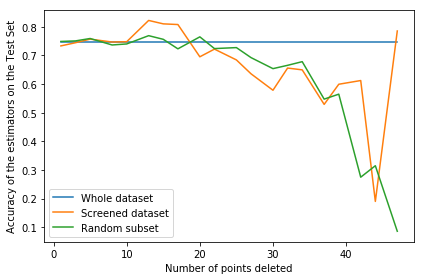

Intercept False lmbda 0.01 Ellipsoid steps 10000 Leukemia
Time to compute z and A: 2632.1742384433746
Time to rank the entire dataset: 15.155975580215454
(57, 7130) (56, 7130)
(56, 7130)
(57, 7130) (54, 7130)
(54, 7130)
(57, 7130) (52, 7130)
(52, 7130)
(57, 7130) (49, 7130)
(49, 7130)
(57, 7130) (47, 7130)
(47, 7130)
(57, 7130) (44, 7130)
(44, 7130)
(57, 7130) (42, 7130)
(42, 7130)
(57, 7130) (40, 7130)
(40, 7130)
(57, 7130) (37, 7130)
(37, 7130)
(57, 7130) (35, 7130)
(35, 7130)
(57, 7130) (32, 7130)
(32, 7130)
(57, 7130) (30, 7130)
(30, 7130)
(57, 7130) (27, 7130)
(27, 7130)
(57, 7130) (25, 7130)
(25, 7130)
(57, 7130) (23, 7130)
(23, 7130)
(57, 7130) (20, 7130)
(20, 7130)
(57, 7130) (18, 7130)
(18, 7130)
(57, 7130) (15, 7130)
(15, 7130)
(57, 7130) (13, 7130)
(13, 7130)
(57, 7130) (10, 7130)
(10, 7130)


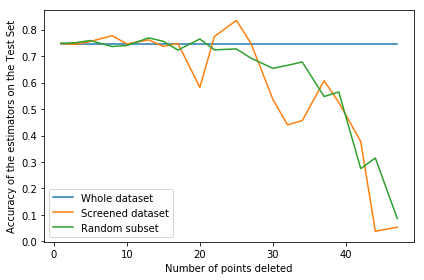

Intercept False lmbda 0.1 Ellipsoid steps 10000 Leukemia
Time to compute z and A: 2626.7256965637207
Time to rank the entire dataset: 12.369203567504883
(57, 7130) (56, 7130)
(56, 7130)
(57, 7130) (54, 7130)
(54, 7130)
(57, 7130) (52, 7130)
(52, 7130)
(57, 7130) (49, 7130)
(49, 7130)
(57, 7130) (47, 7130)
(47, 7130)
(57, 7130) (44, 7130)
(44, 7130)
(57, 7130) (42, 7130)
(42, 7130)
(57, 7130) (40, 7130)
(40, 7130)
(57, 7130) (37, 7130)
(37, 7130)
(57, 7130) (35, 7130)
(35, 7130)
(57, 7130) (32, 7130)
(32, 7130)
(57, 7130) (30, 7130)
(30, 7130)
(57, 7130) (27, 7130)
(27, 7130)
(57, 7130) (25, 7130)
(25, 7130)
(57, 7130) (23, 7130)
(23, 7130)
(57, 7130) (20, 7130)
(20, 7130)
(57, 7130) (18, 7130)
(18, 7130)
(57, 7130) (15, 7130)
(15, 7130)
(57, 7130) (13, 7130)
(13, 7130)
(57, 7130) (10, 7130)
(10, 7130)


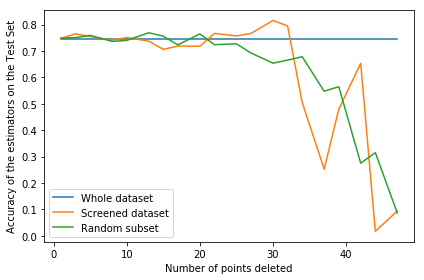

Intercept False lmbda 1.0 Ellipsoid steps 10000 Leukemia


In [10]:
X, y = create_X_y(l_data)

for intercept in [True, False]:
    for lmbda in [0.0001, 0.001, 0.01, 0.1, 1.]:
        for n_ellipsoid_steps in [10000]:
            experiment_real(X, y, nb_delete_steps=20, lmbda=lmbda, intercept=intercept, 
                            n_ellipsoid_steps=n_ellipsoid_steps, nb_test=3)
            print('Intercept', intercept, 'lmbda', lmbda, 'Ellipsoid steps', n_ellipsoid_steps,
                   'Leukemia')

Intercept?

TODO LIST

- Expérience avec meilleure initialisation.
- Screening de features avant?
- Print test value. Quelle est leur distribution ? => semble ne pas dépendre de n_steps

# Sklearn Datasets

In [38]:
from sklearn.datasets import load_diabetes, load_boston, fetch_rcv1

dataset = 'boston'

if dataset == 'diabetes':
    diabetes = load_diabetes(return_X_y=True)
    X = diabetes[0]
    y = diabetes[1]
elif dataset == 'boston':
    boston = load_boston(return_X_y=True)
    X = boston[0]
    y = boston[1]


Time to compute z and A: 3.534390926361084
Time to rank the entire dataset: 0.10109710693359375
(404, 13) (403, 13)
(403, 13)
(404, 13) (383, 13)
(383, 13)
(404, 13) (362, 13)
(362, 13)
(404, 13) (341, 13)
(341, 13)
(404, 13) (321, 13)
(321, 13)
(404, 13) (300, 13)
(300, 13)
(404, 13) (279, 13)
(279, 13)
(404, 13) (259, 13)
(259, 13)
(404, 13) (238, 13)
(238, 13)
(404, 13) (217, 13)
(217, 13)
(404, 13) (197, 13)
(197, 13)
(404, 13) (176, 13)
(176, 13)
(404, 13) (155, 13)
(155, 13)
(404, 13) (135, 13)
(135, 13)
(404, 13) (114, 13)
(114, 13)
(404, 13) (93, 13)
(93, 13)
(404, 13) (73, 13)
(73, 13)
(404, 13) (52, 13)
(52, 13)
(404, 13) (31, 13)
(31, 13)
(404, 13) (10, 13)
(10, 13)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

<IPython.core.display.Javascript object>


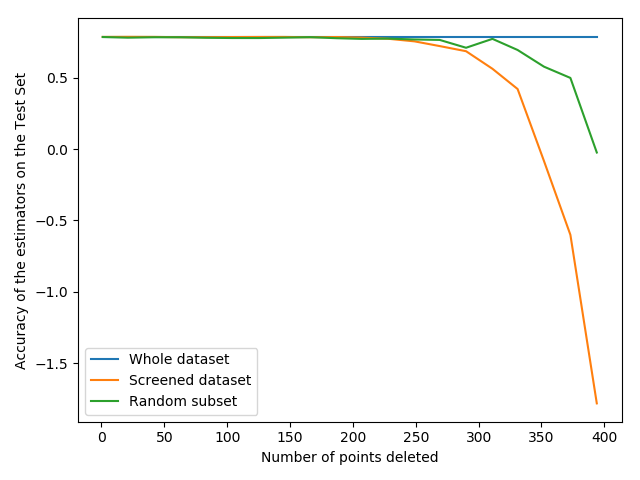

Intercept True lmbda 0.0001 Ellipsoid steps 1000 Boston


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in sqrt


Time to compute z and A: 24.650167226791382
Time to rank the entire dataset: 0.24795889854431152
(404, 13) (403, 13)
(403, 13)
(404, 13) (383, 13)
(383, 13)
(404, 13) (362, 13)
(362, 13)
(404, 13) (341, 13)
(341, 13)
(404, 13) (321, 13)
(321, 13)
(404, 13) (300, 13)
(300, 13)
(404, 13) (279, 13)
(279, 13)
(404, 13) (259, 13)
(259, 13)
(404, 13) (238, 13)
(238, 13)
(404, 13) (217, 13)
(217, 13)
(404, 13) (197, 13)
(197, 13)
(404, 13) (176, 13)
(176, 13)
(404, 13) (155, 13)
(155, 13)
(404, 13) (135, 13)
(135, 13)
(404, 13) (114, 13)
(114, 13)
(404, 13) (93, 13)
(93, 13)
(404, 13) (73, 13)
(73, 13)
(404, 13) (52, 13)
(52, 13)
(404, 13) (31, 13)
(31, 13)
(404, 13) (10, 13)
(10, 13)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

<IPython.core.display.Javascript object>


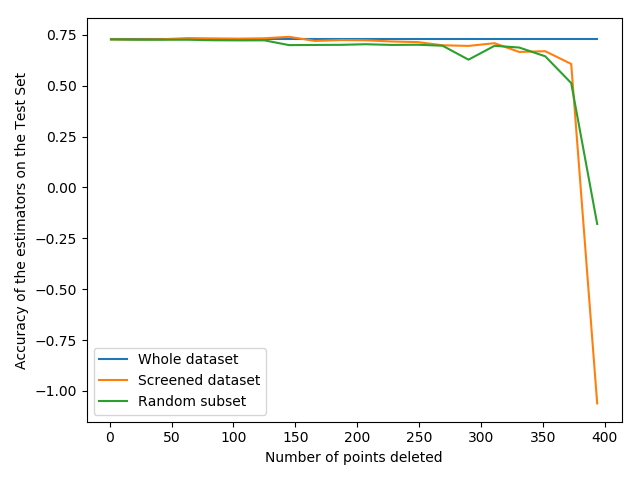

Intercept True lmbda 0.0001 Ellipsoid steps 10000 Boston
Time to compute z and A: 3.069997549057007
Time to rank the entire dataset: 0.08738970756530762
(404, 13) (403, 13)
(403, 13)
(404, 13) (383, 13)
(383, 13)
(404, 13) (362, 13)
(362, 13)
(404, 13) (341, 13)
(341, 13)
(404, 13) (321, 13)
(321, 13)
(404, 13) (300, 13)
(300, 13)
(404, 13) (279, 13)
(279, 13)
(404, 13) (259, 13)
(259, 13)
(404, 13) (238, 13)
(238, 13)
(404, 13) (217, 13)
(217, 13)
(404, 13) (197, 13)
(197, 13)
(404, 13) (176, 13)
(176, 13)
(404, 13) (155, 13)
(155, 13)
(404, 13) (135, 13)
(135, 13)
(404, 13) (114, 13)
(114, 13)
(404, 13) (93, 13)
(93, 13)
(404, 13) (73, 13)
(73, 13)
(404, 13) (52, 13)
(52, 13)
(404, 13) (31, 13)
(31, 13)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(404, 13) (10, 13)
(10, 13)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

<IPython.core.display.Javascript object>


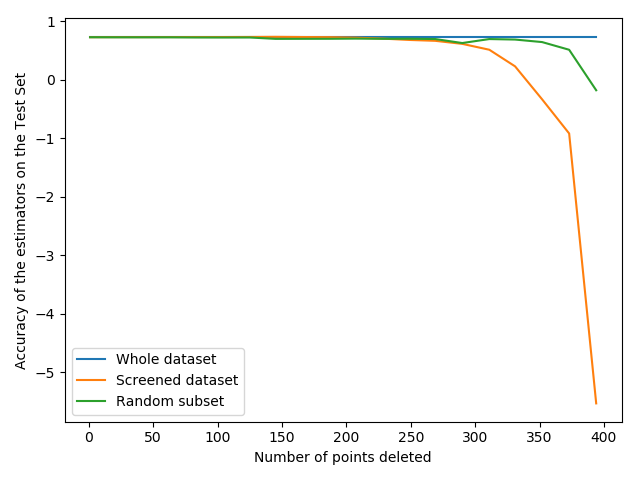

Intercept True lmbda 0.001 Ellipsoid steps 1000 Boston


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in sqrt


Time to compute z and A: 22.900826454162598
Time to rank the entire dataset: 0.25435757637023926
(404, 13) (403, 13)
(403, 13)
(404, 13) (383, 13)
(383, 13)
(404, 13) (362, 13)
(362, 13)
(404, 13) (341, 13)
(341, 13)
(404, 13) (321, 13)
(321, 13)
(404, 13) (300, 13)
(300, 13)
(404, 13) (279, 13)
(279, 13)
(404, 13) (259, 13)
(259, 13)
(404, 13) (238, 13)
(238, 13)
(404, 13) (217, 13)
(217, 13)
(404, 13) (197, 13)
(197, 13)
(404, 13) (176, 13)
(176, 13)
(404, 13) (155, 13)
(155, 13)
(404, 13) (135, 13)
(135, 13)
(404, 13) (114, 13)
(114, 13)
(404, 13) (93, 13)
(93, 13)
(404, 13) (73, 13)
(73, 13)
(404, 13) (52, 13)
(52, 13)
(404, 13) (31, 13)
(31, 13)
(404, 13) (10, 13)
(10, 13)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

<IPython.core.display.Javascript object>


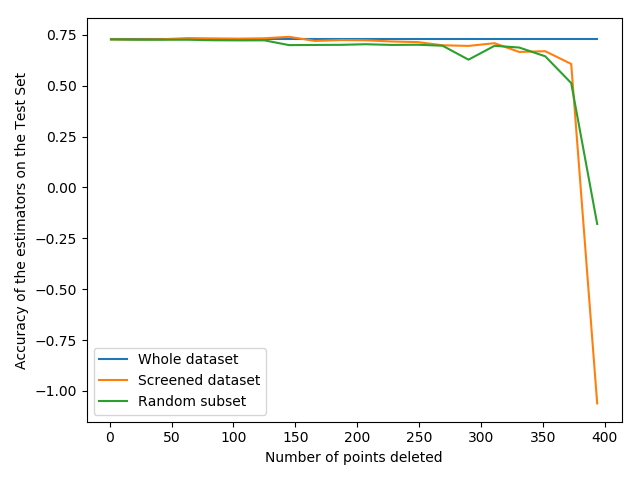

Intercept True lmbda 0.001 Ellipsoid steps 10000 Boston
Time to compute z and A: 3.2770540714263916
Time to rank the entire dataset: 0.12226009368896484
(404, 13) (403, 13)
(403, 13)
(404, 13) (383, 13)
(383, 13)
(404, 13) (362, 13)
(362, 13)
(404, 13) (341, 13)
(341, 13)
(404, 13) (321, 13)
(321, 13)
(404, 13) (300, 13)
(300, 13)
(404, 13) (279, 13)
(279, 13)
(404, 13) (259, 13)
(259, 13)
(404, 13) (238, 13)
(238, 13)
(404, 13) (217, 13)
(217, 13)
(404, 13) (197, 13)
(197, 13)
(404, 13) (176, 13)
(176, 13)
(404, 13) (155, 13)
(155, 13)
(404, 13) (135, 13)
(135, 13)
(404, 13) (114, 13)
(114, 13)
(404, 13) (93, 13)
(93, 13)
(404, 13) (73, 13)
(73, 13)
(404, 13) (52, 13)
(52, 13)
(404, 13) (31, 13)
(31, 13)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(404, 13) (10, 13)
(10, 13)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


<IPython.core.display.Javascript object>


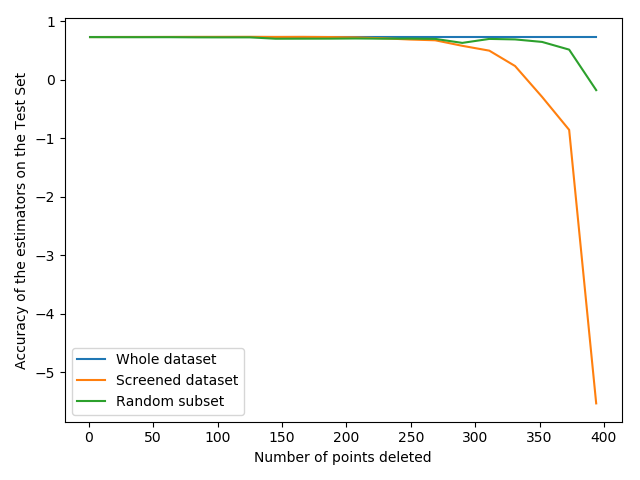

Intercept True lmbda 0.01 Ellipsoid steps 1000 Boston


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in sqrt


Time to compute z and A: 22.804357290267944
Time to rank the entire dataset: 0.2933504581451416
(404, 13) (403, 13)
(403, 13)
(404, 13) (383, 13)
(383, 13)
(404, 13) (362, 13)
(362, 13)
(404, 13) (341, 13)
(341, 13)
(404, 13) (321, 13)
(321, 13)
(404, 13) (300, 13)
(300, 13)
(404, 13) (279, 13)
(279, 13)
(404, 13) (259, 13)
(259, 13)
(404, 13) (238, 13)
(238, 13)
(404, 13) (217, 13)
(217, 13)
(404, 13) (197, 13)
(197, 13)
(404, 13) (176, 13)
(176, 13)
(404, 13) (155, 13)
(155, 13)
(404, 13) (135, 13)
(135, 13)
(404, 13) (114, 13)
(114, 13)
(404, 13) (93, 13)
(93, 13)
(404, 13) (73, 13)
(73, 13)
(404, 13) (52, 13)
(52, 13)
(404, 13) (31, 13)
(31, 13)
(404, 13) (10, 13)
(10, 13)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

<IPython.core.display.Javascript object>


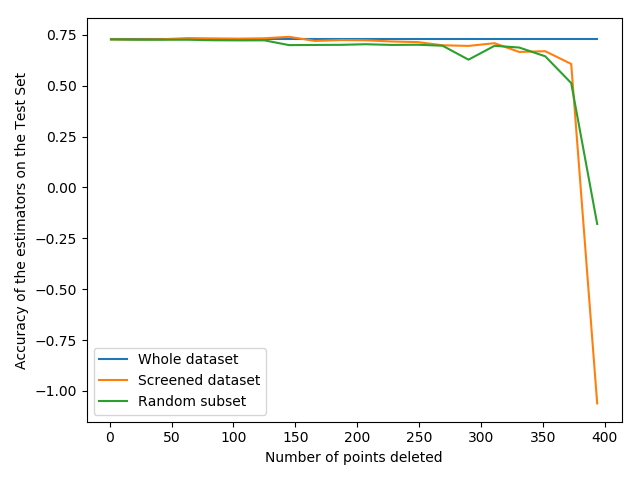

Intercept True lmbda 0.01 Ellipsoid steps 10000 Boston
Time to compute z and A: 3.093334913253784
Time to rank the entire dataset: 0.08743786811828613
(404, 13) (403, 13)
(403, 13)
(404, 13) (383, 13)
(383, 13)
(404, 13) (362, 13)
(362, 13)
(404, 13) (341, 13)
(341, 13)
(404, 13) (321, 13)
(321, 13)
(404, 13) (300, 13)
(300, 13)
(404, 13) (279, 13)
(279, 13)
(404, 13) (259, 13)
(259, 13)
(404, 13) (238, 13)
(238, 13)
(404, 13) (217, 13)
(217, 13)
(404, 13) (197, 13)
(197, 13)
(404, 13) (176, 13)
(176, 13)
(404, 13) (155, 13)
(155, 13)
(404, 13) (135, 13)
(135, 13)
(404, 13) (114, 13)
(114, 13)
(404, 13) (93, 13)
(93, 13)
(404, 13) (73, 13)
(73, 13)
(404, 13) (52, 13)
(52, 13)
(404, 13) (31, 13)
(31, 13)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(404, 13) (10, 13)
(10, 13)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


<IPython.core.display.Javascript object>


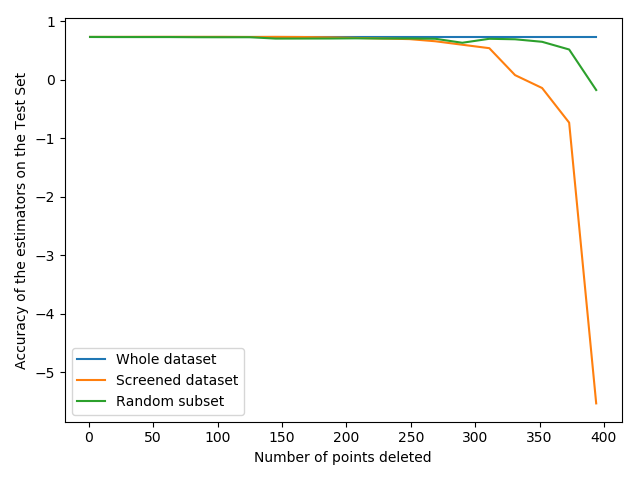

Intercept True lmbda 0.1 Ellipsoid steps 1000 Boston


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in sqrt


Time to compute z and A: 23.573455095291138
Time to rank the entire dataset: 0.23849892616271973
(404, 13) (403, 13)
(403, 13)
(404, 13) (383, 13)
(383, 13)
(404, 13) (362, 13)
(362, 13)
(404, 13) (341, 13)
(341, 13)
(404, 13) (321, 13)
(321, 13)
(404, 13) (300, 13)
(300, 13)
(404, 13) (279, 13)
(279, 13)
(404, 13) (259, 13)
(259, 13)
(404, 13) (238, 13)
(238, 13)
(404, 13) (217, 13)
(217, 13)
(404, 13) (197, 13)
(197, 13)
(404, 13) (176, 13)
(176, 13)
(404, 13) (155, 13)
(155, 13)
(404, 13) (135, 13)
(135, 13)
(404, 13) (114, 13)
(114, 13)
(404, 13) (93, 13)
(93, 13)
(404, 13) (73, 13)
(73, 13)
(404, 13) (52, 13)
(52, 13)
(404, 13) (31, 13)
(31, 13)
(404, 13) (10, 13)
(10, 13)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

<IPython.core.display.Javascript object>


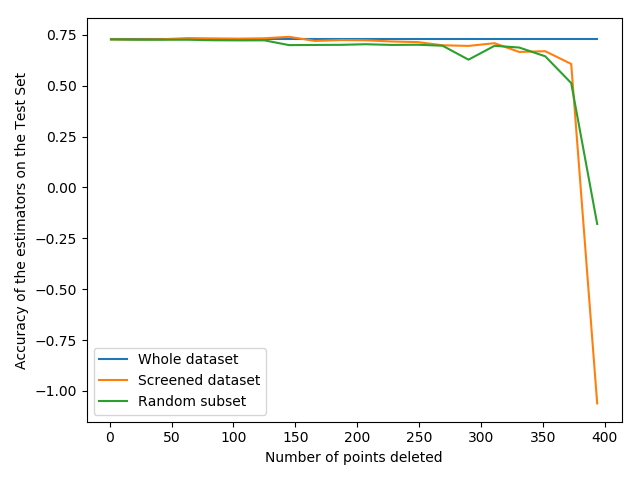

Intercept True lmbda 0.1 Ellipsoid steps 10000 Boston
Time to compute z and A: 3.6336829662323
Time to rank the entire dataset: 0.10196757316589355
(404, 13) (403, 13)
(403, 13)
(404, 13) (383, 13)
(383, 13)
(404, 13) (362, 13)
(362, 13)
(404, 13) (341, 13)
(341, 13)
(404, 13) (321, 13)
(321, 13)
(404, 13) (300, 13)
(300, 13)
(404, 13) (279, 13)
(279, 13)
(404, 13) (259, 13)
(259, 13)
(404, 13) (238, 13)
(238, 13)
(404, 13) (217, 13)
(217, 13)
(404, 13) (197, 13)
(197, 13)
(404, 13) (176, 13)
(176, 13)
(404, 13) (155, 13)
(155, 13)
(404, 13) (135, 13)
(135, 13)
(404, 13) (114, 13)
(114, 13)
(404, 13) (93, 13)
(93, 13)
(404, 13) (73, 13)
(73, 13)
(404, 13) (52, 13)
(52, 13)
(404, 13) (31, 13)
(31, 13)
(404, 13) (10, 13)
(10, 13)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

<IPython.core.display.Javascript object>


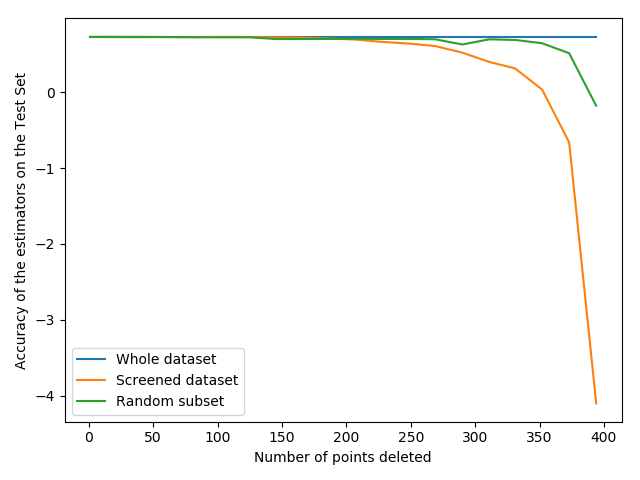

Intercept True lmbda 1.0 Ellipsoid steps 1000 Boston


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in sqrt


Time to compute z and A: 23.637989282608032
Time to rank the entire dataset: 0.26139235496520996
(404, 13) (403, 13)
(403, 13)
(404, 13) (383, 13)
(383, 13)
(404, 13) (362, 13)
(362, 13)
(404, 13) (341, 13)
(341, 13)
(404, 13) (321, 13)
(321, 13)
(404, 13) (300, 13)
(300, 13)
(404, 13) (279, 13)
(279, 13)
(404, 13) (259, 13)
(259, 13)
(404, 13) (238, 13)
(238, 13)
(404, 13) (217, 13)
(217, 13)
(404, 13) (197, 13)
(197, 13)
(404, 13) (176, 13)
(176, 13)
(404, 13) (155, 13)
(155, 13)
(404, 13) (135, 13)
(135, 13)
(404, 13) (114, 13)
(114, 13)
(404, 13) (93, 13)
(93, 13)
(404, 13) (73, 13)
(73, 13)
(404, 13) (52, 13)
(52, 13)
(404, 13) (31, 13)
(31, 13)
(404, 13) (10, 13)
(10, 13)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

<IPython.core.display.Javascript object>


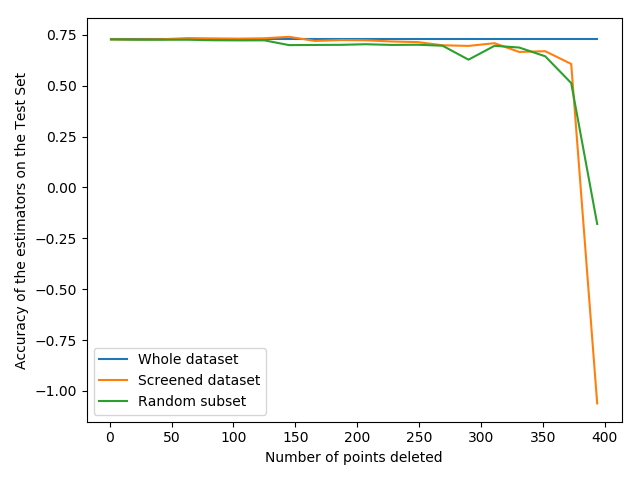

Intercept True lmbda 1.0 Ellipsoid steps 10000 Boston
Time to compute z and A: 3.2457845211029053
Time to rank the entire dataset: 0.08643770217895508
(404, 13) (403, 13)
(403, 13)
(404, 13) (383, 13)
(383, 13)
(404, 13) (362, 13)
(362, 13)
(404, 13) (341, 13)
(341, 13)
(404, 13) (321, 13)
(321, 13)
(404, 13) (300, 13)
(300, 13)
(404, 13) (279, 13)
(279, 13)
(404, 13) (259, 13)
(259, 13)
(404, 13) (238, 13)
(238, 13)
(404, 13) (217, 13)
(217, 13)
(404, 13) (197, 13)
(197, 13)
(404, 13) (176, 13)
(176, 13)
(404, 13) (155, 13)
(155, 13)
(404, 13) (135, 13)
(135, 13)
(404, 13) (114, 13)
(114, 13)
(404, 13) (93, 13)
(93, 13)
(404, 13) (73, 13)
(73, 13)
(404, 13) (52, 13)
(52, 13)
(404, 13) (31, 13)
(31, 13)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(404, 13) (10, 13)
(10, 13)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

<IPython.core.display.Javascript object>


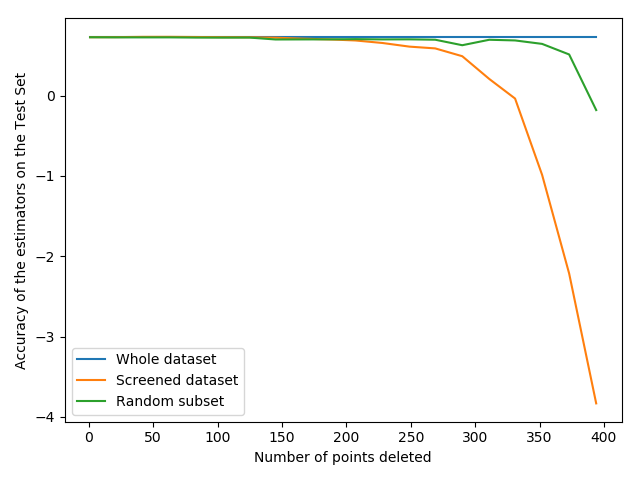

Intercept True lmbda 10.0 Ellipsoid steps 1000 Boston


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in sqrt


Time to compute z and A: 23.939297676086426
Time to rank the entire dataset: 0.25907373428344727
(404, 13) (403, 13)
(403, 13)
(404, 13) (383, 13)
(383, 13)
(404, 13) (362, 13)
(362, 13)
(404, 13) (341, 13)
(341, 13)
(404, 13) (321, 13)
(321, 13)
(404, 13) (300, 13)
(300, 13)
(404, 13) (279, 13)
(279, 13)
(404, 13) (259, 13)
(259, 13)
(404, 13) (238, 13)
(238, 13)
(404, 13) (217, 13)
(217, 13)
(404, 13) (197, 13)
(197, 13)
(404, 13) (176, 13)
(176, 13)
(404, 13) (155, 13)
(155, 13)
(404, 13) (135, 13)
(135, 13)
(404, 13) (114, 13)
(114, 13)
(404, 13) (93, 13)
(93, 13)
(404, 13) (73, 13)
(73, 13)
(404, 13) (52, 13)
(52, 13)
(404, 13) (31, 13)
(31, 13)
(404, 13) (10, 13)
(10, 13)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

<IPython.core.display.Javascript object>


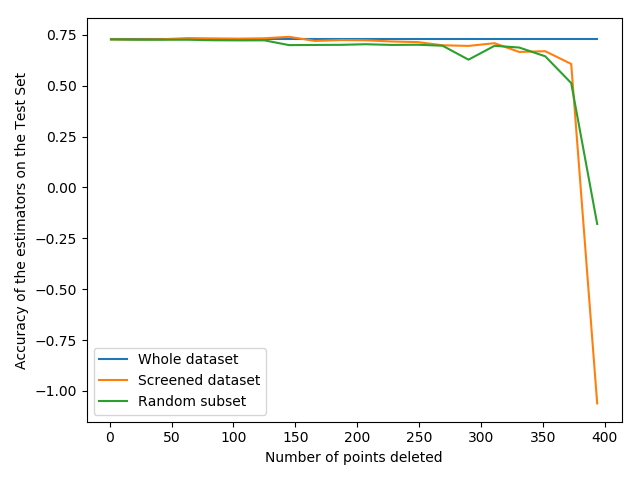

Intercept True lmbda 10.0 Ellipsoid steps 10000 Boston
Time to compute z and A: 3.0524277687072754
Time to rank the entire dataset: 0.08955192565917969
(404, 14) (403, 14)
(403, 14)
(404, 14) (383, 14)
(383, 14)
(404, 14) (362, 14)
(362, 14)
(404, 14) (341, 14)
(341, 14)
(404, 14) (321, 14)
(321, 14)
(404, 14) (300, 14)
(300, 14)
(404, 14) (279, 14)
(279, 14)
(404, 14) (259, 14)
(259, 14)
(404, 14) (238, 14)
(238, 14)
(404, 14) (217, 14)
(217, 14)
(404, 14) (197, 14)
(197, 14)
(404, 14) (176, 14)
(176, 14)
(404, 14) (155, 14)
(155, 14)
(404, 14) (135, 14)
(135, 14)
(404, 14) (114, 14)
(114, 14)
(404, 14) (93, 14)
(93, 14)
(404, 14) (73, 14)
(73, 14)
(404, 14) (52, 14)
(52, 14)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(404, 14) (31, 14)
(31, 14)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(404, 14) (10, 14)
(10, 14)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

<IPython.core.display.Javascript object>


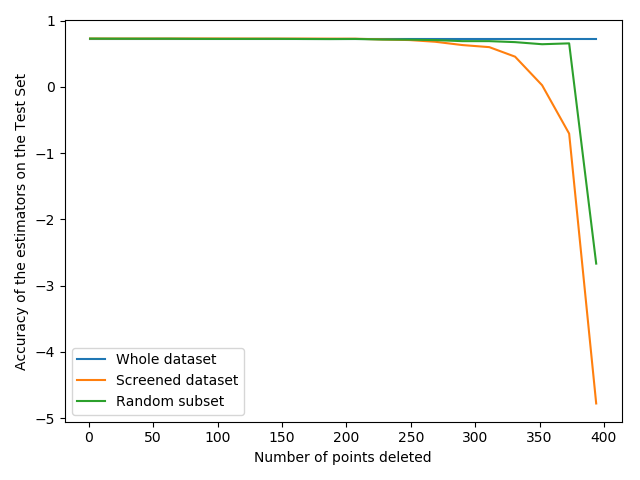

Intercept False lmbda 0.0001 Ellipsoid steps 1000 Boston


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in sqrt


Time to compute z and A: 24.172560453414917
Time to rank the entire dataset: 0.26692986488342285
(404, 14) (403, 14)
(403, 14)
(404, 14) (383, 14)
(383, 14)
(404, 14) (362, 14)
(362, 14)
(404, 14) (341, 14)
(341, 14)
(404, 14) (321, 14)
(321, 14)
(404, 14) (300, 14)
(300, 14)
(404, 14) (279, 14)
(279, 14)
(404, 14) (259, 14)
(259, 14)
(404, 14) (238, 14)
(238, 14)
(404, 14) (217, 14)
(217, 14)
(404, 14) (197, 14)
(197, 14)
(404, 14) (176, 14)
(176, 14)
(404, 14) (155, 14)
(155, 14)
(404, 14) (135, 14)
(135, 14)
(404, 14) (114, 14)
(114, 14)
(404, 14) (93, 14)
(93, 14)
(404, 14) (73, 14)
(73, 14)
(404, 14) (52, 14)
(52, 14)
(404, 14) (31, 14)
(31, 14)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(404, 14) (10, 14)
(10, 14)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

<IPython.core.display.Javascript object>


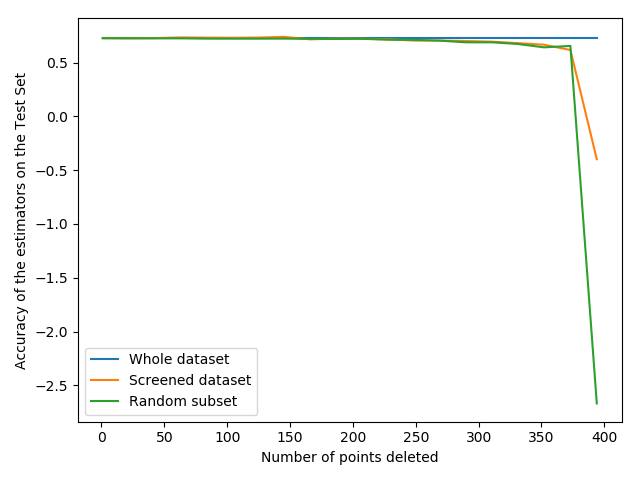

Intercept False lmbda 0.0001 Ellipsoid steps 10000 Boston
Time to compute z and A: 3.5935962200164795
Time to rank the entire dataset: 0.11974930763244629
(404, 14) (403, 14)
(403, 14)
(404, 14) (383, 14)
(383, 14)
(404, 14) (362, 14)
(362, 14)
(404, 14) (341, 14)
(341, 14)
(404, 14) (321, 14)
(321, 14)
(404, 14) (300, 14)
(300, 14)
(404, 14) (279, 14)
(279, 14)
(404, 14) (259, 14)
(259, 14)
(404, 14) (238, 14)
(238, 14)
(404, 14) (217, 14)
(217, 14)
(404, 14) (197, 14)
(197, 14)
(404, 14) (176, 14)
(176, 14)
(404, 14) (155, 14)
(155, 14)
(404, 14) (135, 14)
(135, 14)
(404, 14) (114, 14)
(114, 14)
(404, 14) (93, 14)
(93, 14)
(404, 14) (73, 14)
(73, 14)
(404, 14) (52, 14)
(52, 14)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(404, 14) (31, 14)
(31, 14)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(404, 14) (10, 14)
(10, 14)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

<IPython.core.display.Javascript object>


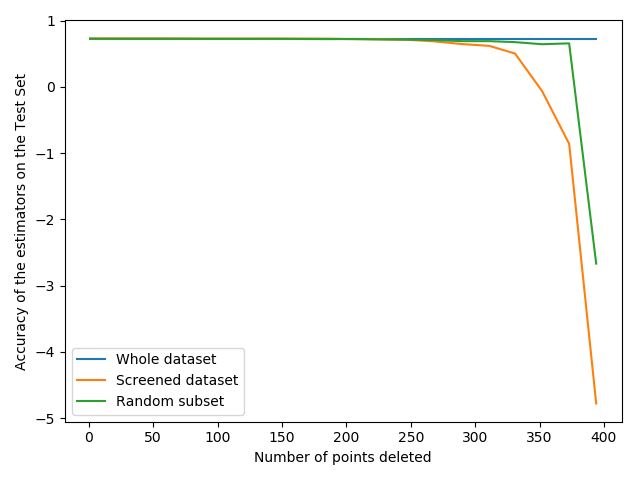

Intercept False lmbda 0.001 Ellipsoid steps 1000 Boston


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in sqrt


Time to compute z and A: 25.66312003135681
Time to rank the entire dataset: 0.24984073638916016
(404, 14) (403, 14)
(403, 14)
(404, 14) (383, 14)
(383, 14)
(404, 14) (362, 14)
(362, 14)
(404, 14) (341, 14)
(341, 14)
(404, 14) (321, 14)
(321, 14)
(404, 14) (300, 14)
(300, 14)
(404, 14) (279, 14)
(279, 14)
(404, 14) (259, 14)
(259, 14)
(404, 14) (238, 14)
(238, 14)
(404, 14) (217, 14)
(217, 14)
(404, 14) (197, 14)
(197, 14)
(404, 14) (176, 14)
(176, 14)
(404, 14) (155, 14)
(155, 14)
(404, 14) (135, 14)
(135, 14)
(404, 14) (114, 14)
(114, 14)
(404, 14) (93, 14)
(93, 14)
(404, 14) (73, 14)
(73, 14)
(404, 14) (52, 14)
(52, 14)
(404, 14) (31, 14)
(31, 14)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(404, 14) (10, 14)
(10, 14)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

<IPython.core.display.Javascript object>


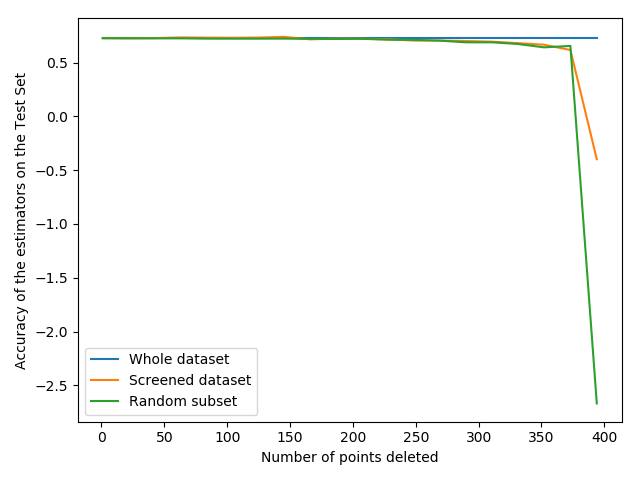

Intercept False lmbda 0.001 Ellipsoid steps 10000 Boston
Time to compute z and A: 3.0461487770080566
Time to rank the entire dataset: 0.08984780311584473
(404, 14) (403, 14)
(403, 14)
(404, 14) (383, 14)
(383, 14)
(404, 14) (362, 14)
(362, 14)
(404, 14) (341, 14)
(341, 14)
(404, 14) (321, 14)
(321, 14)
(404, 14) (300, 14)
(300, 14)
(404, 14) (279, 14)
(279, 14)
(404, 14) (259, 14)
(259, 14)
(404, 14) (238, 14)
(238, 14)
(404, 14) (217, 14)
(217, 14)
(404, 14) (197, 14)
(197, 14)
(404, 14) (176, 14)
(176, 14)
(404, 14) (155, 14)
(155, 14)
(404, 14) (135, 14)
(135, 14)
(404, 14) (114, 14)
(114, 14)
(404, 14) (93, 14)
(93, 14)
(404, 14) (73, 14)
(73, 14)
(404, 14) (52, 14)
(52, 14)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(404, 14) (31, 14)
(31, 14)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(404, 14) (10, 14)
(10, 14)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

<IPython.core.display.Javascript object>


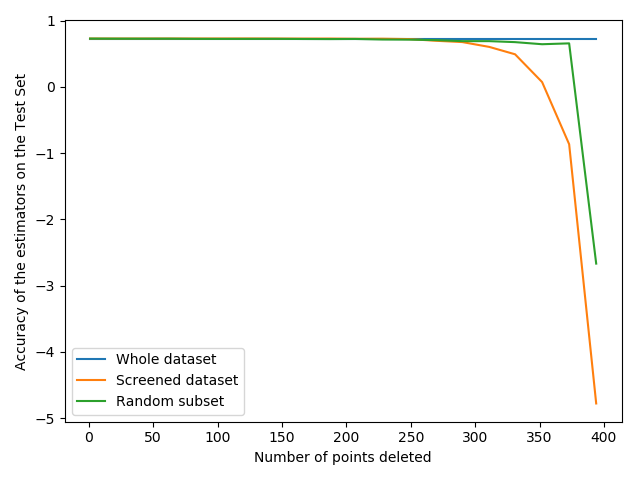

Intercept False lmbda 0.01 Ellipsoid steps 1000 Boston


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in sqrt


Time to compute z and A: 24.118685245513916
Time to rank the entire dataset: 0.25830864906311035
(404, 14) (403, 14)
(403, 14)
(404, 14) (383, 14)
(383, 14)
(404, 14) (362, 14)
(362, 14)
(404, 14) (341, 14)
(341, 14)
(404, 14) (321, 14)
(321, 14)
(404, 14) (300, 14)
(300, 14)
(404, 14) (279, 14)
(279, 14)
(404, 14) (259, 14)
(259, 14)
(404, 14) (238, 14)
(238, 14)
(404, 14) (217, 14)
(217, 14)
(404, 14) (197, 14)
(197, 14)
(404, 14) (176, 14)
(176, 14)
(404, 14) (155, 14)
(155, 14)
(404, 14) (135, 14)
(135, 14)
(404, 14) (114, 14)
(114, 14)
(404, 14) (93, 14)
(93, 14)
(404, 14) (73, 14)
(73, 14)
(404, 14) (52, 14)
(52, 14)
(404, 14) (31, 14)
(31, 14)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(404, 14) (10, 14)
(10, 14)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

<IPython.core.display.Javascript object>


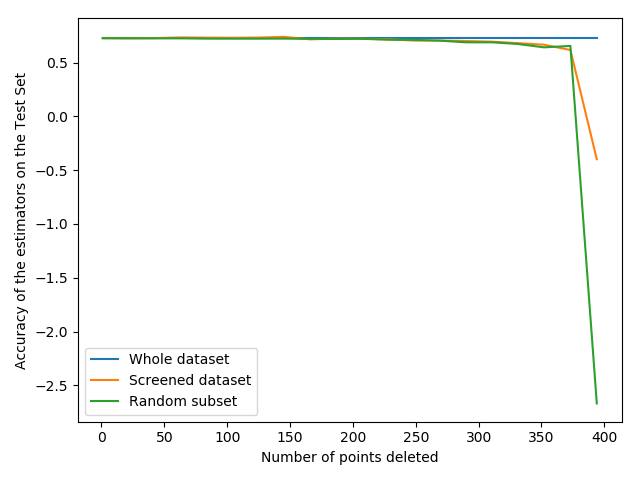

Intercept False lmbda 0.01 Ellipsoid steps 10000 Boston
Time to compute z and A: 3.1061789989471436
Time to rank the entire dataset: 0.08899235725402832
(404, 14) (403, 14)
(403, 14)
(404, 14) (383, 14)
(383, 14)
(404, 14) (362, 14)
(362, 14)
(404, 14) (341, 14)
(341, 14)
(404, 14) (321, 14)
(321, 14)
(404, 14) (300, 14)
(300, 14)
(404, 14) (279, 14)
(279, 14)
(404, 14) (259, 14)
(259, 14)
(404, 14) (238, 14)
(238, 14)
(404, 14) (217, 14)
(217, 14)
(404, 14) (197, 14)
(197, 14)
(404, 14) (176, 14)
(176, 14)
(404, 14) (155, 14)
(155, 14)
(404, 14) (135, 14)
(135, 14)
(404, 14) (114, 14)
(114, 14)
(404, 14) (93, 14)
(93, 14)
(404, 14) (73, 14)
(73, 14)
(404, 14) (52, 14)
(52, 14)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(404, 14) (31, 14)
(31, 14)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(404, 14) (10, 14)
(10, 14)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

<IPython.core.display.Javascript object>


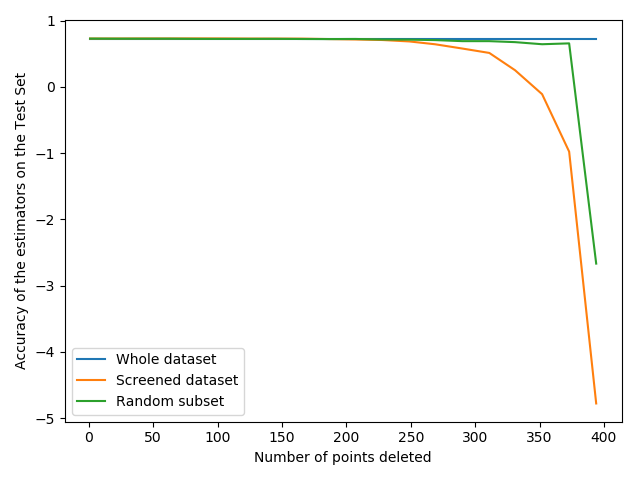

Intercept False lmbda 0.1 Ellipsoid steps 1000 Boston


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in sqrt


Time to compute z and A: 24.608516931533813
Time to rank the entire dataset: 0.2702958583831787
(404, 14) (403, 14)
(403, 14)
(404, 14) (383, 14)
(383, 14)
(404, 14) (362, 14)
(362, 14)
(404, 14) (341, 14)
(341, 14)
(404, 14) (321, 14)
(321, 14)
(404, 14) (300, 14)
(300, 14)
(404, 14) (279, 14)
(279, 14)
(404, 14) (259, 14)
(259, 14)
(404, 14) (238, 14)
(238, 14)
(404, 14) (217, 14)
(217, 14)
(404, 14) (197, 14)
(197, 14)
(404, 14) (176, 14)
(176, 14)
(404, 14) (155, 14)
(155, 14)
(404, 14) (135, 14)
(135, 14)
(404, 14) (114, 14)
(114, 14)
(404, 14) (93, 14)
(93, 14)
(404, 14) (73, 14)
(73, 14)
(404, 14) (52, 14)
(52, 14)
(404, 14) (31, 14)
(31, 14)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(404, 14) (10, 14)
(10, 14)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

<IPython.core.display.Javascript object>


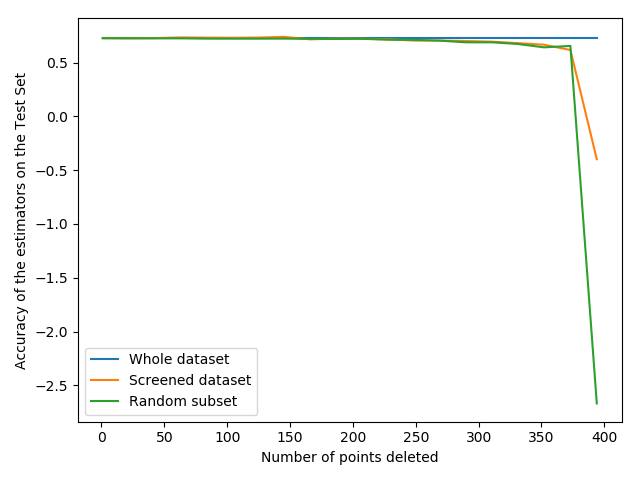

Intercept False lmbda 0.1 Ellipsoid steps 10000 Boston
Time to compute z and A: 3.130795478820801
Time to rank the entire dataset: 0.0903327465057373
(404, 14) (403, 14)
(403, 14)
(404, 14) (383, 14)
(383, 14)
(404, 14) (362, 14)
(362, 14)
(404, 14) (341, 14)
(341, 14)
(404, 14) (321, 14)
(321, 14)
(404, 14) (300, 14)
(300, 14)
(404, 14) (279, 14)
(279, 14)
(404, 14) (259, 14)
(259, 14)
(404, 14) (238, 14)
(238, 14)
(404, 14) (217, 14)
(217, 14)
(404, 14) (197, 14)
(197, 14)
(404, 14) (176, 14)
(176, 14)
(404, 14) (155, 14)
(155, 14)
(404, 14) (135, 14)
(135, 14)
(404, 14) (114, 14)
(114, 14)
(404, 14) (93, 14)
(93, 14)
(404, 14) (73, 14)
(73, 14)
(404, 14) (52, 14)
(52, 14)
(404, 14) (31, 14)
(31, 14)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(404, 14) (10, 14)
(10, 14)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

<IPython.core.display.Javascript object>


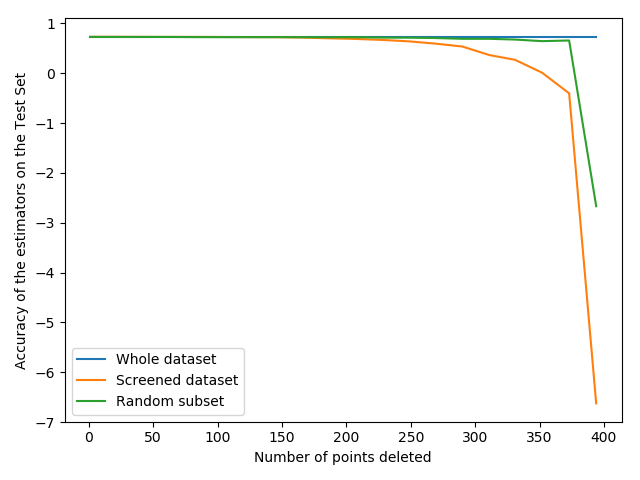

Intercept False lmbda 1.0 Ellipsoid steps 1000 Boston


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in sqrt


Time to compute z and A: 24.28824281692505
Time to rank the entire dataset: 0.2701151371002197
(404, 14) (403, 14)
(403, 14)
(404, 14) (383, 14)
(383, 14)
(404, 14) (362, 14)
(362, 14)
(404, 14) (341, 14)
(341, 14)
(404, 14) (321, 14)
(321, 14)
(404, 14) (300, 14)
(300, 14)
(404, 14) (279, 14)
(279, 14)
(404, 14) (259, 14)
(259, 14)
(404, 14) (238, 14)
(238, 14)
(404, 14) (217, 14)
(217, 14)
(404, 14) (197, 14)
(197, 14)
(404, 14) (176, 14)
(176, 14)
(404, 14) (155, 14)
(155, 14)
(404, 14) (135, 14)
(135, 14)
(404, 14) (114, 14)
(114, 14)
(404, 14) (93, 14)
(93, 14)
(404, 14) (73, 14)
(73, 14)
(404, 14) (52, 14)
(52, 14)
(404, 14) (31, 14)
(31, 14)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(404, 14) (10, 14)
(10, 14)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

<IPython.core.display.Javascript object>


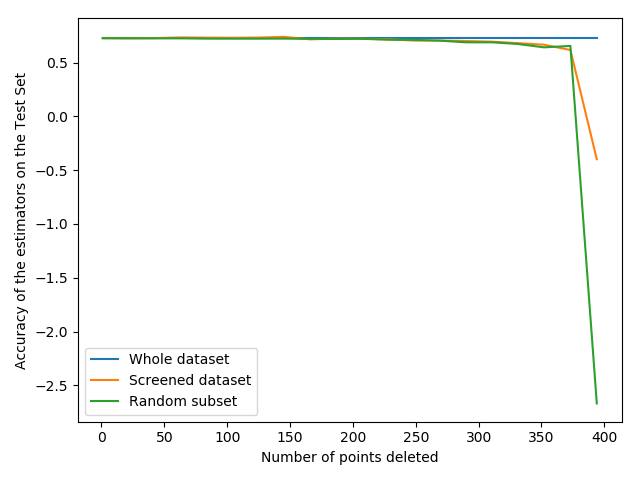

Intercept False lmbda 1.0 Ellipsoid steps 10000 Boston
Time to compute z and A: 3.8875789642333984
Time to rank the entire dataset: 0.10295724868774414
(404, 14) (403, 14)
(403, 14)
(404, 14) (383, 14)
(383, 14)
(404, 14) (362, 14)
(362, 14)
(404, 14) (341, 14)
(341, 14)
(404, 14) (321, 14)
(321, 14)
(404, 14) (300, 14)
(300, 14)
(404, 14) (279, 14)
(279, 14)
(404, 14) (259, 14)
(259, 14)
(404, 14) (238, 14)
(238, 14)
(404, 14) (217, 14)
(217, 14)
(404, 14) (197, 14)
(197, 14)
(404, 14) (176, 14)
(176, 14)
(404, 14) (155, 14)
(155, 14)
(404, 14) (135, 14)
(135, 14)
(404, 14) (114, 14)
(114, 14)
(404, 14) (93, 14)
(93, 14)
(404, 14) (73, 14)
(73, 14)
(404, 14) (52, 14)
(52, 14)
(404, 14) (31, 14)
(31, 14)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(404, 14) (10, 14)
(10, 14)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

<IPython.core.display.Javascript object>


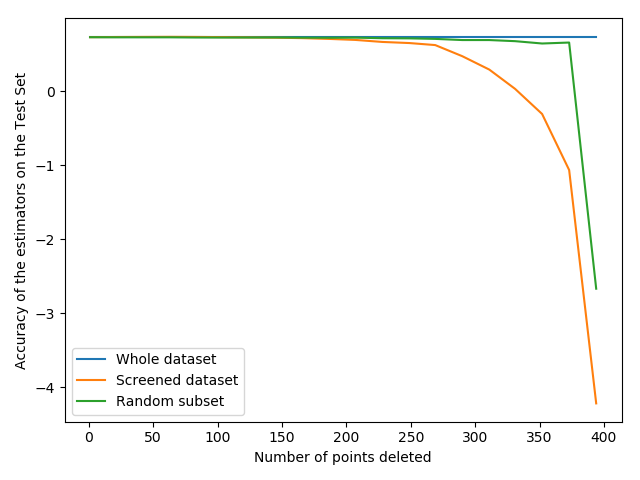

Intercept False lmbda 10.0 Ellipsoid steps 1000 Boston


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in sqrt


Time to compute z and A: 28.807651042938232
Time to rank the entire dataset: 0.2533740997314453
(404, 14) (403, 14)
(403, 14)
(404, 14) (383, 14)
(383, 14)
(404, 14) (362, 14)
(362, 14)
(404, 14) (341, 14)
(341, 14)
(404, 14) (321, 14)
(321, 14)
(404, 14) (300, 14)
(300, 14)
(404, 14) (279, 14)
(279, 14)
(404, 14) (259, 14)
(259, 14)
(404, 14) (238, 14)
(238, 14)
(404, 14) (217, 14)
(217, 14)
(404, 14) (197, 14)
(197, 14)
(404, 14) (176, 14)
(176, 14)
(404, 14) (155, 14)
(155, 14)
(404, 14) (135, 14)
(135, 14)
(404, 14) (114, 14)
(114, 14)
(404, 14) (93, 14)
(93, 14)
(404, 14) (73, 14)
(73, 14)
(404, 14) (52, 14)
(52, 14)
(404, 14) (31, 14)
(31, 14)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(404, 14) (10, 14)
(10, 14)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

<IPython.core.display.Javascript object>


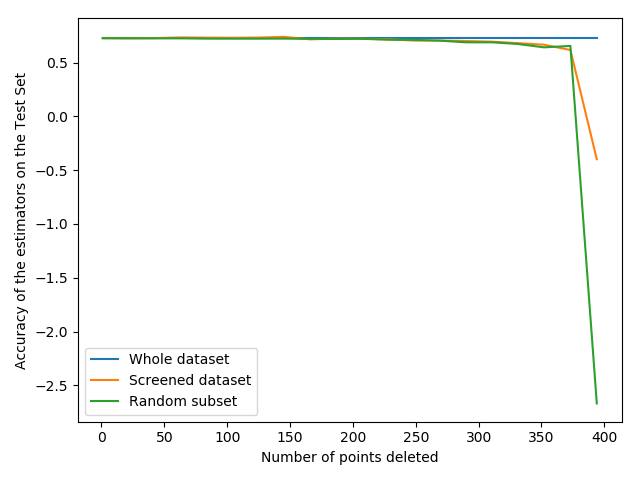

Intercept False lmbda 10.0 Ellipsoid steps 10000 Boston


In [40]:
boston = load_boston(return_X_y=True)
X = boston[0]
y = boston[1]
for intercept in [True, False]:
    for lmbda in [0.0001, 0.001, 0.01, 0.1, 1., 10.]:
        for n_ellipsoid_steps in [1000, 10000]:
            experiment_real(X, y, nb_delete_steps=20, lmbda=lmbda, intercept=intercept, 
                            n_ellipsoid_steps=n_ellipsoid_steps, nb_test=3)
            print('Intercept', intercept, 'lmbda', lmbda, 'Ellipsoid steps', n_ellipsoid_steps,
                   'Boston')

Time to compute z and A: 0.03614187240600586
Time to rank the entire dataset: 0.046730995178222656
(353, 10) (352, 10)
(352, 10)
(353, 10) (334, 10)
(334, 10)
(353, 10) (316, 10)
(316, 10)
(353, 10) (298, 10)
(298, 10)
(353, 10) (280, 10)
(280, 10)
(353, 10) (262, 10)
(262, 10)
(353, 10) (244, 10)
(244, 10)
(353, 10) (226, 10)
(226, 10)
(353, 10) (208, 10)
(208, 10)
(353, 10) (190, 10)
(190, 10)
(353, 10) (172, 10)
(172, 10)
(353, 10) (154, 10)
(154, 10)
(353, 10) (136, 10)
(136, 10)
(353, 10) (118, 10)
(118, 10)
(353, 10) (100, 10)
(100, 10)
(353, 10) (82, 10)
(82, 10)
(353, 10) (64, 10)
(64, 10)
(353, 10) (46, 10)
(46, 10)
(353, 10) (28, 10)
(28, 10)
(353, 10) (10, 10)
(10, 10)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


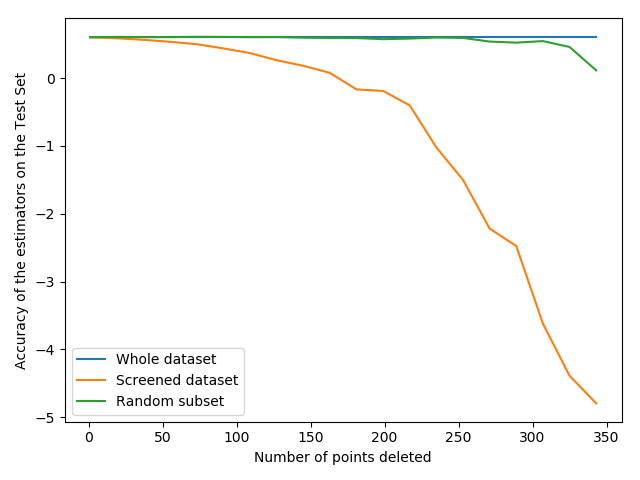

Intercept True lmbda 0.0001 Ellipsoid steps 10 Diabetes
Time to compute z and A: 0.36376261711120605
Time to rank the entire dataset: 0.05432248115539551
(353, 10) (352, 10)
(352, 10)
(353, 10) (334, 10)
(334, 10)
(353, 10) (316, 10)
(316, 10)
(353, 10) (298, 10)
(298, 10)
(353, 10) (280, 10)
(280, 10)
(353, 10) (262, 10)
(262, 10)
(353, 10) (244, 10)
(244, 10)
(353, 10) (226, 10)
(226, 10)
(353, 10) (208, 10)
(208, 10)
(353, 10) (190, 10)
(190, 10)
(353, 10) (172, 10)
(172, 10)
(353, 10) (154, 10)
(154, 10)
(353, 10) (136, 10)
(136, 10)
(353, 10) (118, 10)
(118, 10)
(353, 10) (100, 10)
(100, 10)
(353, 10) (82, 10)
(82, 10)
(353, 10) (64, 10)
(64, 10)
(353, 10) (46, 10)
(46, 10)
(353, 10) (28, 10)
(28, 10)
(353, 10) (10, 10)
(10, 10)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


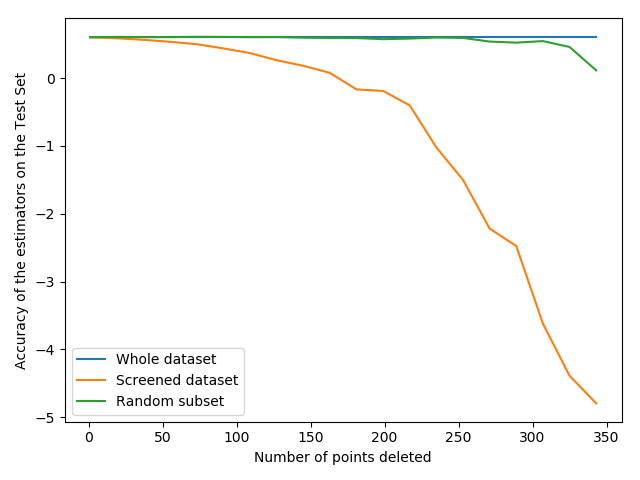

Intercept True lmbda 0.0001 Ellipsoid steps 100 Diabetes


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in sqrt


Time to compute z and A: 2.8680648803710938
Time to rank the entire dataset: 0.09832191467285156
(353, 10) (352, 10)
(352, 10)
(353, 10) (334, 10)
(334, 10)
(353, 10) (316, 10)
(316, 10)
(353, 10) (298, 10)
(298, 10)
(353, 10) (280, 10)
(280, 10)
(353, 10) (262, 10)
(262, 10)
(353, 10) (244, 10)
(244, 10)
(353, 10) (226, 10)
(226, 10)
(353, 10) (208, 10)
(208, 10)
(353, 10) (190, 10)
(190, 10)
(353, 10) (172, 10)
(172, 10)
(353, 10) (154, 10)
(154, 10)
(353, 10) (136, 10)
(136, 10)
(353, 10) (118, 10)
(118, 10)
(353, 10) (100, 10)
(100, 10)
(353, 10) (82, 10)
(82, 10)
(353, 10) (64, 10)
(64, 10)
(353, 10) (46, 10)
(46, 10)
(353, 10) (28, 10)
(28, 10)
(353, 10) (10, 10)
(10, 10)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


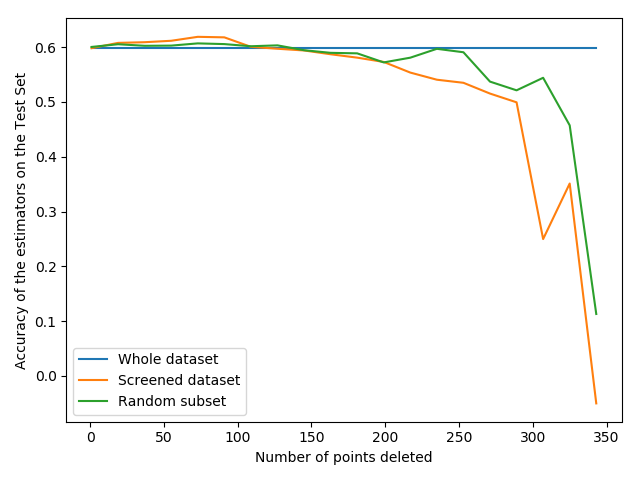

Intercept True lmbda 0.0001 Ellipsoid steps 1000 Diabetes


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in sqrt


Time to compute z and A: 20.16729497909546
Time to rank the entire dataset: 0.25208067893981934
(353, 10) (352, 10)
(352, 10)
(353, 10) (334, 10)
(334, 10)
(353, 10) (316, 10)
(316, 10)
(353, 10) (298, 10)
(298, 10)
(353, 10) (280, 10)
(280, 10)
(353, 10) (262, 10)
(262, 10)
(353, 10) (244, 10)
(244, 10)
(353, 10) (226, 10)
(226, 10)
(353, 10) (208, 10)
(208, 10)
(353, 10) (190, 10)
(190, 10)
(353, 10) (172, 10)
(172, 10)
(353, 10) (154, 10)
(154, 10)
(353, 10) (136, 10)
(136, 10)
(353, 10) (118, 10)
(118, 10)
(353, 10) (100, 10)
(100, 10)
(353, 10) (82, 10)
(82, 10)
(353, 10) (64, 10)
(64, 10)
(353, 10) (46, 10)
(46, 10)
(353, 10) (28, 10)
(28, 10)
(353, 10) (10, 10)
(10, 10)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


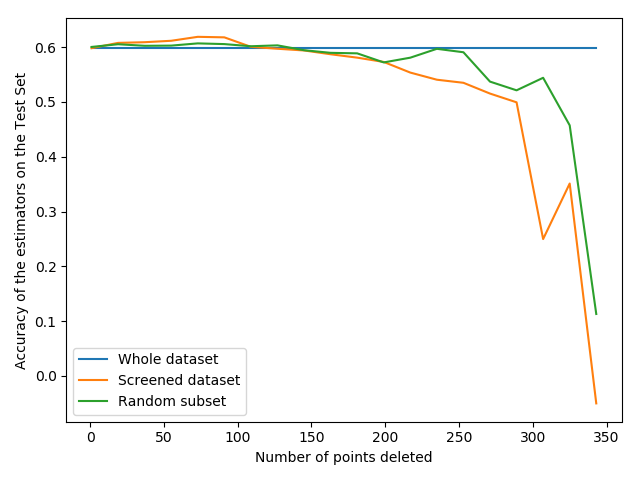

Intercept True lmbda 0.0001 Ellipsoid steps 10000 Diabetes
Time to compute z and A: 0.0318603515625
Time to rank the entire dataset: 0.04643416404724121
(353, 10) (352, 10)
(352, 10)
(353, 10) (334, 10)
(334, 10)
(353, 10) (316, 10)
(316, 10)
(353, 10) (298, 10)
(298, 10)
(353, 10) (280, 10)
(280, 10)
(353, 10) (262, 10)
(262, 10)
(353, 10) (244, 10)
(244, 10)
(353, 10) (226, 10)
(226, 10)
(353, 10) (208, 10)
(208, 10)
(353, 10) (190, 10)
(190, 10)
(353, 10) (172, 10)
(172, 10)
(353, 10) (154, 10)
(154, 10)
(353, 10) (136, 10)
(136, 10)
(353, 10) (118, 10)
(118, 10)
(353, 10) (100, 10)
(100, 10)
(353, 10) (82, 10)
(82, 10)
(353, 10) (64, 10)
(64, 10)
(353, 10) (46, 10)
(46, 10)
(353, 10) (28, 10)
(28, 10)
(353, 10) (10, 10)
(10, 10)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


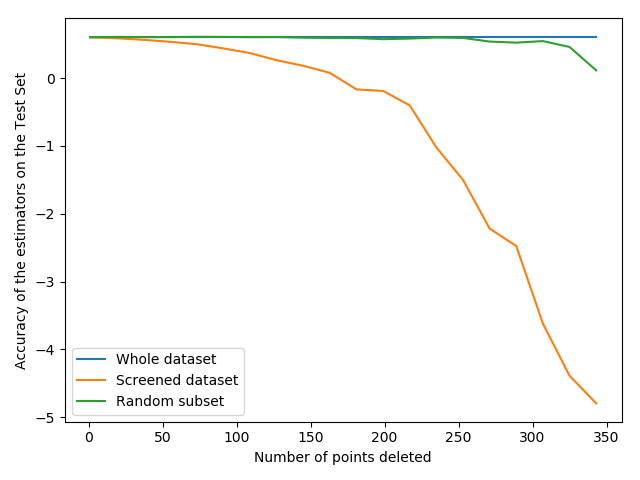

Intercept True lmbda 0.001 Ellipsoid steps 10 Diabetes
Time to compute z and A: 0.31232547760009766
Time to rank the entire dataset: 0.045427560806274414
(353, 10) (352, 10)
(352, 10)
(353, 10) (334, 10)
(334, 10)
(353, 10) (316, 10)
(316, 10)
(353, 10) (298, 10)
(298, 10)
(353, 10) (280, 10)
(280, 10)
(353, 10) (262, 10)
(262, 10)
(353, 10) (244, 10)
(244, 10)
(353, 10) (226, 10)
(226, 10)
(353, 10) (208, 10)
(208, 10)
(353, 10) (190, 10)
(190, 10)
(353, 10) (172, 10)
(172, 10)
(353, 10) (154, 10)
(154, 10)
(353, 10) (136, 10)
(136, 10)
(353, 10) (118, 10)
(118, 10)
(353, 10) (100, 10)
(100, 10)
(353, 10) (82, 10)
(82, 10)
(353, 10) (64, 10)
(64, 10)
(353, 10) (46, 10)
(46, 10)
(353, 10) (28, 10)
(28, 10)
(353, 10) (10, 10)
(10, 10)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


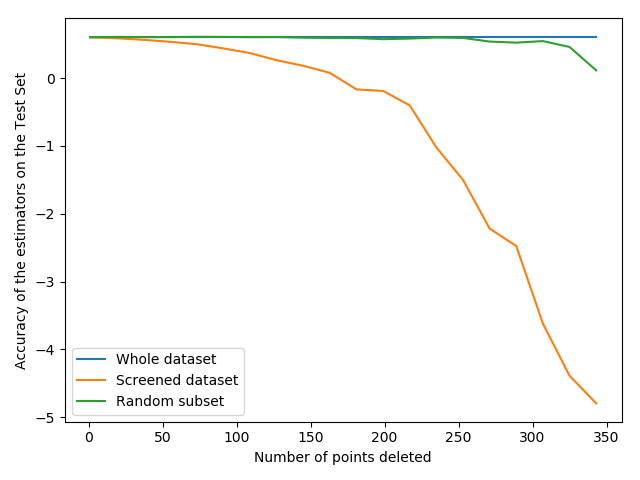

Intercept True lmbda 0.001 Ellipsoid steps 100 Diabetes


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in sqrt


Time to compute z and A: 2.442382574081421
Time to rank the entire dataset: 0.08523368835449219
(353, 10) (352, 10)
(352, 10)
(353, 10) (334, 10)
(334, 10)
(353, 10) (316, 10)
(316, 10)
(353, 10) (298, 10)
(298, 10)
(353, 10) (280, 10)
(280, 10)
(353, 10) (262, 10)
(262, 10)
(353, 10) (244, 10)
(244, 10)
(353, 10) (226, 10)
(226, 10)
(353, 10) (208, 10)
(208, 10)
(353, 10) (190, 10)
(190, 10)
(353, 10) (172, 10)
(172, 10)
(353, 10) (154, 10)
(154, 10)
(353, 10) (136, 10)
(136, 10)
(353, 10) (118, 10)
(118, 10)
(353, 10) (100, 10)
(100, 10)
(353, 10) (82, 10)
(82, 10)
(353, 10) (64, 10)
(64, 10)
(353, 10) (46, 10)
(46, 10)
(353, 10) (28, 10)
(28, 10)
(353, 10) (10, 10)
(10, 10)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


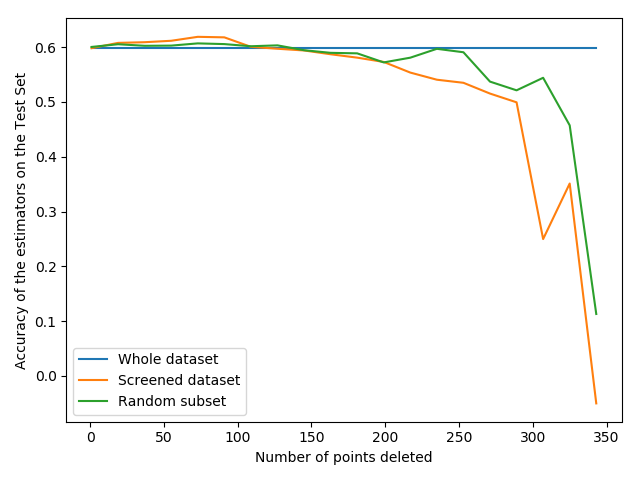

Intercept True lmbda 0.001 Ellipsoid steps 1000 Diabetes


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in sqrt


Time to compute z and A: 19.10889720916748
Time to rank the entire dataset: 0.2245016098022461
(353, 10) (352, 10)
(352, 10)
(353, 10) (334, 10)
(334, 10)
(353, 10) (316, 10)
(316, 10)
(353, 10) (298, 10)
(298, 10)
(353, 10) (280, 10)
(280, 10)
(353, 10) (262, 10)
(262, 10)
(353, 10) (244, 10)
(244, 10)
(353, 10) (226, 10)
(226, 10)
(353, 10) (208, 10)
(208, 10)
(353, 10) (190, 10)
(190, 10)
(353, 10) (172, 10)
(172, 10)
(353, 10) (154, 10)
(154, 10)
(353, 10) (136, 10)
(136, 10)
(353, 10) (118, 10)
(118, 10)
(353, 10) (100, 10)
(100, 10)
(353, 10) (82, 10)
(82, 10)
(353, 10) (64, 10)
(64, 10)
(353, 10) (46, 10)
(46, 10)
(353, 10) (28, 10)
(28, 10)
(353, 10) (10, 10)
(10, 10)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


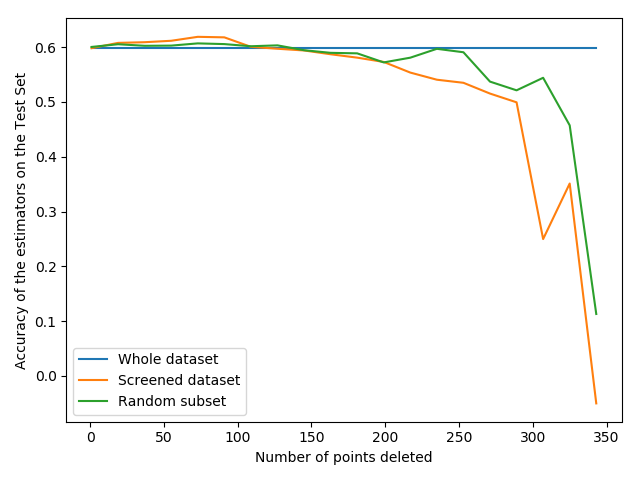

Intercept True lmbda 0.001 Ellipsoid steps 10000 Diabetes
Time to compute z and A: 0.03185915946960449
Time to rank the entire dataset: 0.04811286926269531
(353, 10) (352, 10)
(352, 10)
(353, 10) (334, 10)
(334, 10)
(353, 10) (316, 10)
(316, 10)
(353, 10) (298, 10)
(298, 10)
(353, 10) (280, 10)
(280, 10)
(353, 10) (262, 10)
(262, 10)
(353, 10) (244, 10)
(244, 10)
(353, 10) (226, 10)
(226, 10)
(353, 10) (208, 10)
(208, 10)
(353, 10) (190, 10)
(190, 10)
(353, 10) (172, 10)
(172, 10)
(353, 10) (154, 10)
(154, 10)
(353, 10) (136, 10)
(136, 10)
(353, 10) (118, 10)
(118, 10)
(353, 10) (100, 10)
(100, 10)
(353, 10) (82, 10)
(82, 10)
(353, 10) (64, 10)
(64, 10)
(353, 10) (46, 10)
(46, 10)
(353, 10) (28, 10)
(28, 10)
(353, 10) (10, 10)
(10, 10)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


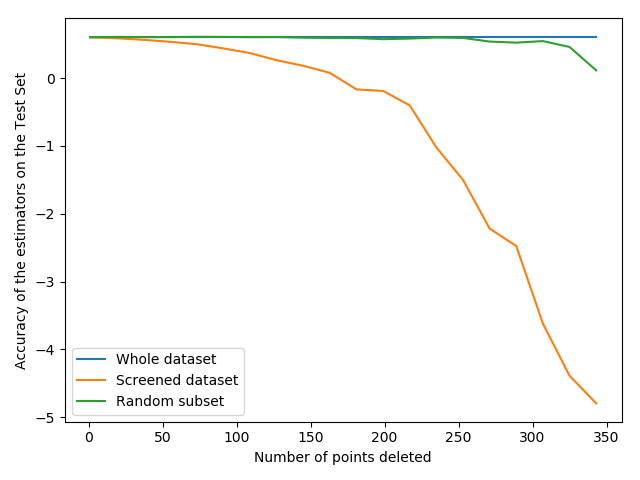

Intercept True lmbda 0.01 Ellipsoid steps 10 Diabetes
Time to compute z and A: 0.3578469753265381
Time to rank the entire dataset: 0.044648170471191406
(353, 10) (352, 10)
(352, 10)
(353, 10) (334, 10)
(334, 10)
(353, 10) (316, 10)
(316, 10)
(353, 10) (298, 10)
(298, 10)
(353, 10) (280, 10)
(280, 10)
(353, 10) (262, 10)
(262, 10)
(353, 10) (244, 10)
(244, 10)
(353, 10) (226, 10)
(226, 10)
(353, 10) (208, 10)
(208, 10)
(353, 10) (190, 10)
(190, 10)
(353, 10) (172, 10)
(172, 10)
(353, 10) (154, 10)
(154, 10)
(353, 10) (136, 10)
(136, 10)
(353, 10) (118, 10)
(118, 10)
(353, 10) (100, 10)
(100, 10)
(353, 10) (82, 10)
(82, 10)
(353, 10) (64, 10)
(64, 10)
(353, 10) (46, 10)
(46, 10)
(353, 10) (28, 10)
(28, 10)
(353, 10) (10, 10)
(10, 10)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


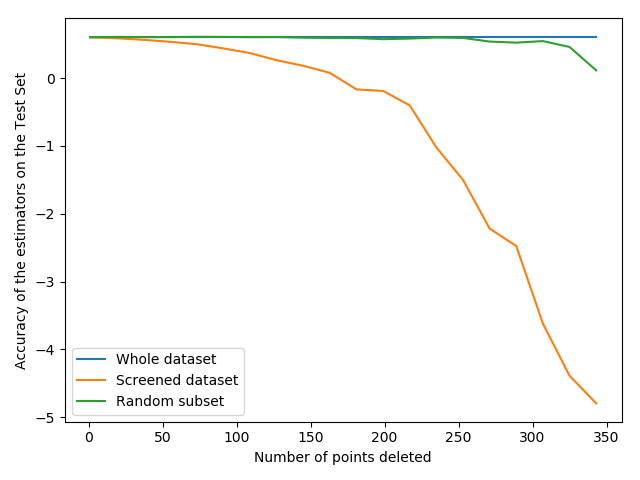

Intercept True lmbda 0.01 Ellipsoid steps 100 Diabetes


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in sqrt


Time to compute z and A: 2.431053876876831
Time to rank the entire dataset: 0.08344340324401855
(353, 10) (352, 10)
(352, 10)
(353, 10) (334, 10)
(334, 10)
(353, 10) (316, 10)
(316, 10)
(353, 10) (298, 10)
(298, 10)
(353, 10) (280, 10)
(280, 10)
(353, 10) (262, 10)
(262, 10)
(353, 10) (244, 10)
(244, 10)
(353, 10) (226, 10)
(226, 10)
(353, 10) (208, 10)
(208, 10)
(353, 10) (190, 10)
(190, 10)
(353, 10) (172, 10)
(172, 10)
(353, 10) (154, 10)
(154, 10)
(353, 10) (136, 10)
(136, 10)
(353, 10) (118, 10)
(118, 10)
(353, 10) (100, 10)
(100, 10)
(353, 10) (82, 10)
(82, 10)
(353, 10) (64, 10)
(64, 10)
(353, 10) (46, 10)
(46, 10)
(353, 10) (28, 10)
(28, 10)
(353, 10) (10, 10)
(10, 10)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


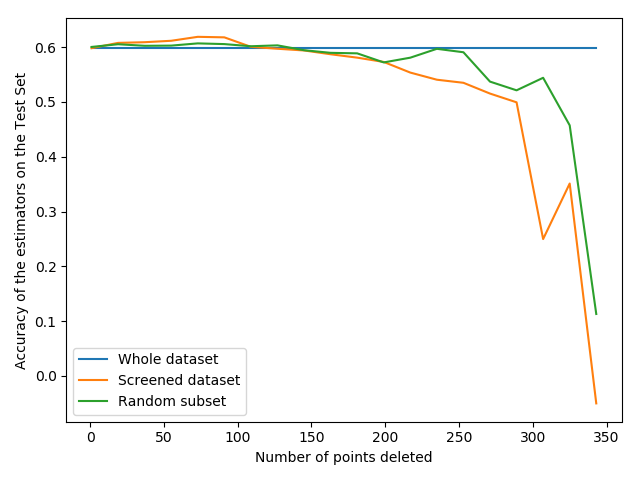

Intercept True lmbda 0.01 Ellipsoid steps 1000 Diabetes


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in sqrt


Time to compute z and A: 20.28852367401123
Time to rank the entire dataset: 0.22226881980895996
(353, 10) (352, 10)
(352, 10)
(353, 10) (334, 10)
(334, 10)
(353, 10) (316, 10)
(316, 10)
(353, 10) (298, 10)
(298, 10)
(353, 10) (280, 10)
(280, 10)
(353, 10) (262, 10)
(262, 10)
(353, 10) (244, 10)
(244, 10)
(353, 10) (226, 10)
(226, 10)
(353, 10) (208, 10)
(208, 10)
(353, 10) (190, 10)
(190, 10)
(353, 10) (172, 10)
(172, 10)
(353, 10) (154, 10)
(154, 10)
(353, 10) (136, 10)
(136, 10)
(353, 10) (118, 10)
(118, 10)
(353, 10) (100, 10)
(100, 10)
(353, 10) (82, 10)
(82, 10)
(353, 10) (64, 10)
(64, 10)
(353, 10) (46, 10)
(46, 10)
(353, 10) (28, 10)
(28, 10)
(353, 10) (10, 10)
(10, 10)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


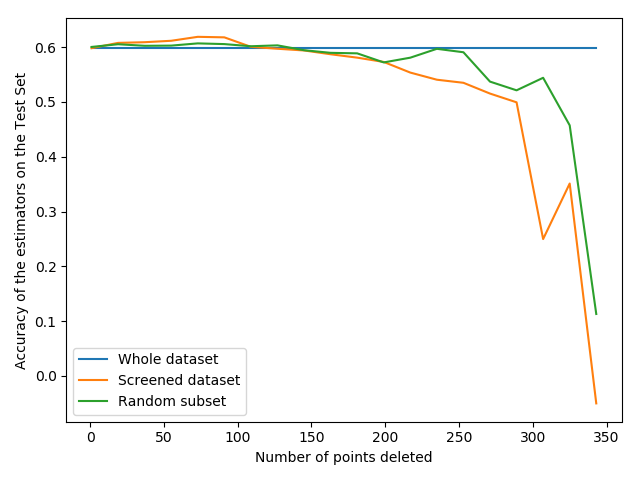

Intercept True lmbda 0.01 Ellipsoid steps 10000 Diabetes
Time to compute z and A: 0.03182578086853027
Time to rank the entire dataset: 0.04580354690551758
(353, 10) (352, 10)
(352, 10)
(353, 10) (334, 10)
(334, 10)
(353, 10) (316, 10)
(316, 10)
(353, 10) (298, 10)
(298, 10)
(353, 10) (280, 10)
(280, 10)
(353, 10) (262, 10)
(262, 10)
(353, 10) (244, 10)
(244, 10)
(353, 10) (226, 10)
(226, 10)
(353, 10) (208, 10)
(208, 10)
(353, 10) (190, 10)
(190, 10)
(353, 10) (172, 10)
(172, 10)
(353, 10) (154, 10)
(154, 10)
(353, 10) (136, 10)
(136, 10)
(353, 10) (118, 10)
(118, 10)
(353, 10) (100, 10)
(100, 10)
(353, 10) (82, 10)
(82, 10)
(353, 10) (64, 10)
(64, 10)
(353, 10) (46, 10)
(46, 10)
(353, 10) (28, 10)
(28, 10)
(353, 10) (10, 10)
(10, 10)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


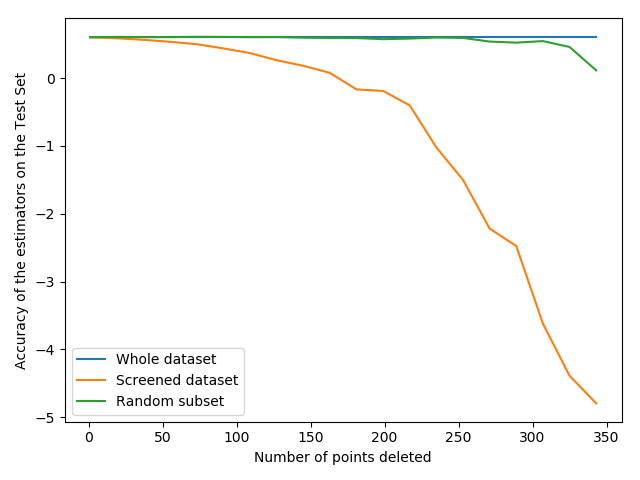

Intercept True lmbda 0.1 Ellipsoid steps 10 Diabetes
Time to compute z and A: 0.3097672462463379
Time to rank the entire dataset: 0.04466104507446289
(353, 10) (352, 10)
(352, 10)
(353, 10) (334, 10)
(334, 10)
(353, 10) (316, 10)
(316, 10)
(353, 10) (298, 10)
(298, 10)
(353, 10) (280, 10)
(280, 10)
(353, 10) (262, 10)
(262, 10)
(353, 10) (244, 10)
(244, 10)
(353, 10) (226, 10)
(226, 10)
(353, 10) (208, 10)
(208, 10)
(353, 10) (190, 10)
(190, 10)
(353, 10) (172, 10)
(172, 10)
(353, 10) (154, 10)
(154, 10)
(353, 10) (136, 10)
(136, 10)
(353, 10) (118, 10)
(118, 10)
(353, 10) (100, 10)
(100, 10)
(353, 10) (82, 10)
(82, 10)
(353, 10) (64, 10)
(64, 10)
(353, 10) (46, 10)
(46, 10)
(353, 10) (28, 10)
(28, 10)
(353, 10) (10, 10)
(10, 10)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


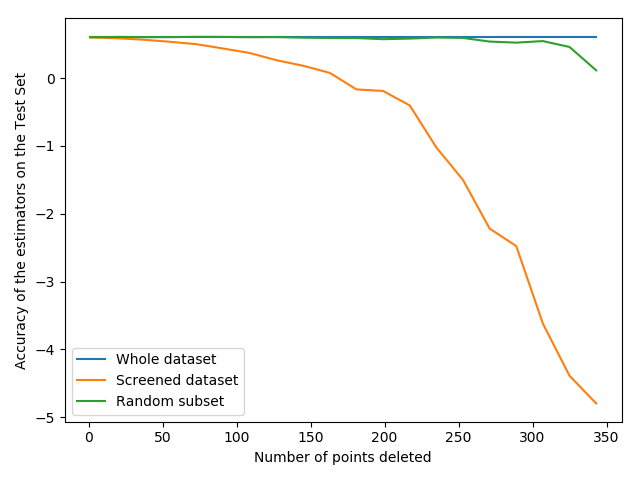

Intercept True lmbda 0.1 Ellipsoid steps 100 Diabetes


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in sqrt


Time to compute z and A: 2.3937618732452393
Time to rank the entire dataset: 0.08564591407775879
(353, 10) (352, 10)
(352, 10)
(353, 10) (334, 10)
(334, 10)
(353, 10) (316, 10)
(316, 10)
(353, 10) (298, 10)
(298, 10)
(353, 10) (280, 10)
(280, 10)
(353, 10) (262, 10)
(262, 10)
(353, 10) (244, 10)
(244, 10)
(353, 10) (226, 10)
(226, 10)
(353, 10) (208, 10)
(208, 10)
(353, 10) (190, 10)
(190, 10)
(353, 10) (172, 10)
(172, 10)
(353, 10) (154, 10)
(154, 10)
(353, 10) (136, 10)
(136, 10)
(353, 10) (118, 10)
(118, 10)
(353, 10) (100, 10)
(100, 10)
(353, 10) (82, 10)
(82, 10)
(353, 10) (64, 10)
(64, 10)
(353, 10) (46, 10)
(46, 10)
(353, 10) (28, 10)
(28, 10)
(353, 10) (10, 10)
(10, 10)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


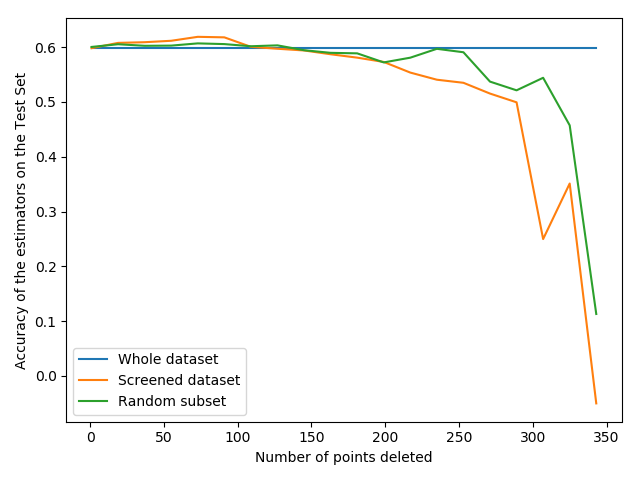

Intercept True lmbda 0.1 Ellipsoid steps 1000 Diabetes


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in sqrt


Time to compute z and A: 19.577343940734863
Time to rank the entire dataset: 0.24149680137634277
(353, 10) (352, 10)
(352, 10)
(353, 10) (334, 10)
(334, 10)
(353, 10) (316, 10)
(316, 10)
(353, 10) (298, 10)
(298, 10)
(353, 10) (280, 10)
(280, 10)
(353, 10) (262, 10)
(262, 10)
(353, 10) (244, 10)
(244, 10)
(353, 10) (226, 10)
(226, 10)
(353, 10) (208, 10)
(208, 10)
(353, 10) (190, 10)
(190, 10)
(353, 10) (172, 10)
(172, 10)
(353, 10) (154, 10)
(154, 10)
(353, 10) (136, 10)
(136, 10)
(353, 10) (118, 10)
(118, 10)
(353, 10) (100, 10)
(100, 10)
(353, 10) (82, 10)
(82, 10)
(353, 10) (64, 10)
(64, 10)
(353, 10) (46, 10)
(46, 10)
(353, 10) (28, 10)
(28, 10)
(353, 10) (10, 10)
(10, 10)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


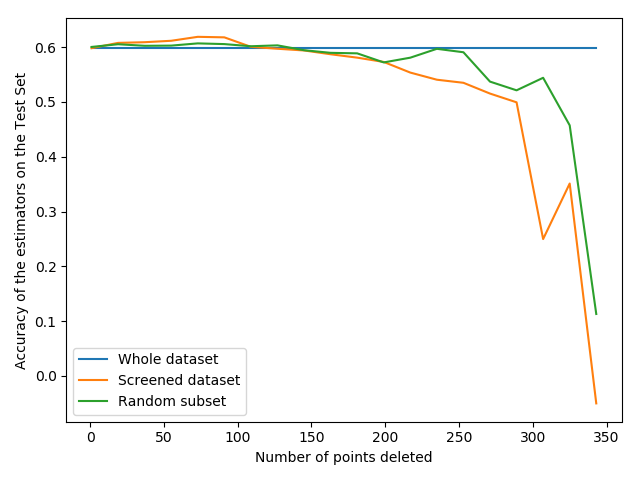

Intercept True lmbda 0.1 Ellipsoid steps 10000 Diabetes
Time to compute z and A: 0.03264617919921875
Time to rank the entire dataset: 0.05851435661315918
(353, 10) (352, 10)
(352, 10)
(353, 10) (334, 10)
(334, 10)
(353, 10) (316, 10)
(316, 10)
(353, 10) (298, 10)
(298, 10)
(353, 10) (280, 10)
(280, 10)
(353, 10) (262, 10)
(262, 10)
(353, 10) (244, 10)
(244, 10)
(353, 10) (226, 10)
(226, 10)
(353, 10) (208, 10)
(208, 10)
(353, 10) (190, 10)
(190, 10)
(353, 10) (172, 10)
(172, 10)
(353, 10) (154, 10)
(154, 10)
(353, 10) (136, 10)
(136, 10)
(353, 10) (118, 10)
(118, 10)
(353, 10) (100, 10)
(100, 10)
(353, 10) (82, 10)
(82, 10)
(353, 10) (64, 10)
(64, 10)
(353, 10) (46, 10)
(46, 10)
(353, 10) (28, 10)
(28, 10)
(353, 10) (10, 10)
(10, 10)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


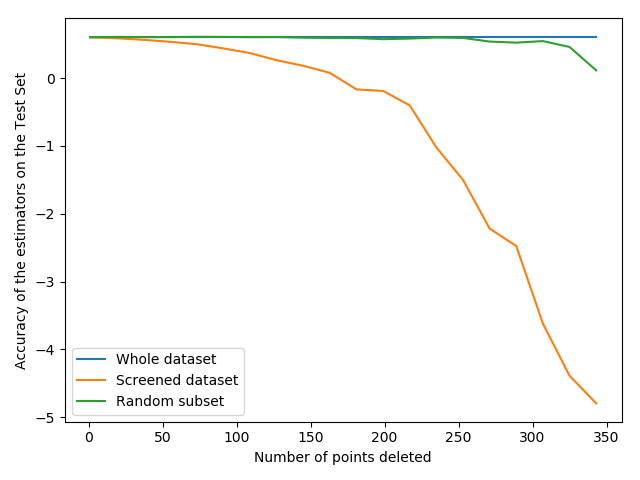

Intercept True lmbda 1.0 Ellipsoid steps 10 Diabetes
Time to compute z and A: 0.31423187255859375
Time to rank the entire dataset: 0.04357314109802246
(353, 10) (352, 10)
(352, 10)
(353, 10) (334, 10)
(334, 10)
(353, 10) (316, 10)
(316, 10)
(353, 10) (298, 10)
(298, 10)
(353, 10) (280, 10)
(280, 10)
(353, 10) (262, 10)
(262, 10)
(353, 10) (244, 10)
(244, 10)
(353, 10) (226, 10)
(226, 10)
(353, 10) (208, 10)
(208, 10)
(353, 10) (190, 10)
(190, 10)
(353, 10) (172, 10)
(172, 10)
(353, 10) (154, 10)
(154, 10)
(353, 10) (136, 10)
(136, 10)
(353, 10) (118, 10)
(118, 10)
(353, 10) (100, 10)
(100, 10)
(353, 10) (82, 10)
(82, 10)
(353, 10) (64, 10)
(64, 10)
(353, 10) (46, 10)
(46, 10)
(353, 10) (28, 10)
(28, 10)
(353, 10) (10, 10)
(10, 10)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


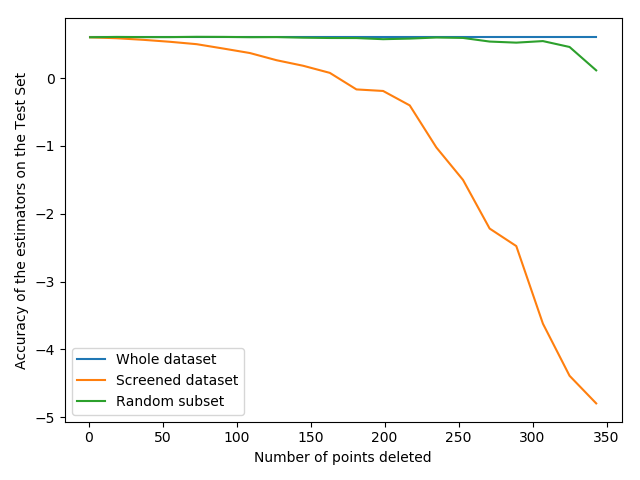

Intercept True lmbda 1.0 Ellipsoid steps 100 Diabetes


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in sqrt


Time to compute z and A: 2.6447603702545166
Time to rank the entire dataset: 0.09786725044250488
(353, 10) (352, 10)
(352, 10)
(353, 10) (334, 10)
(334, 10)
(353, 10) (316, 10)
(316, 10)
(353, 10) (298, 10)
(298, 10)
(353, 10) (280, 10)
(280, 10)
(353, 10) (262, 10)
(262, 10)
(353, 10) (244, 10)
(244, 10)
(353, 10) (226, 10)
(226, 10)
(353, 10) (208, 10)
(208, 10)
(353, 10) (190, 10)
(190, 10)
(353, 10) (172, 10)
(172, 10)
(353, 10) (154, 10)
(154, 10)
(353, 10) (136, 10)
(136, 10)
(353, 10) (118, 10)
(118, 10)
(353, 10) (100, 10)
(100, 10)
(353, 10) (82, 10)
(82, 10)
(353, 10) (64, 10)
(64, 10)
(353, 10) (46, 10)
(46, 10)
(353, 10) (28, 10)
(28, 10)
(353, 10) (10, 10)
(10, 10)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


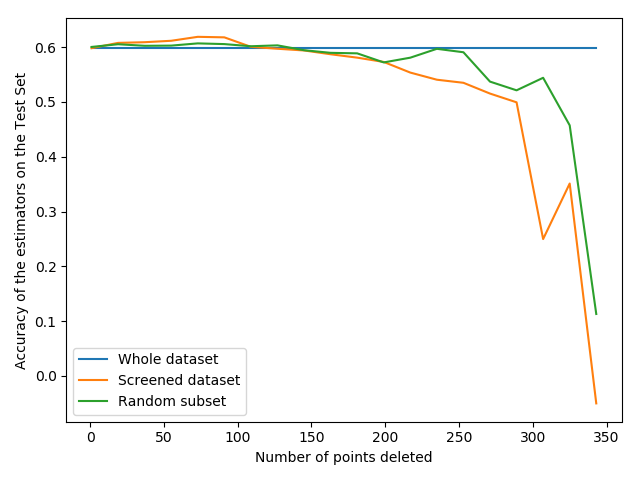

Intercept True lmbda 1.0 Ellipsoid steps 1000 Diabetes


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in sqrt


Time to compute z and A: 18.976754665374756
Time to rank the entire dataset: 0.22921514511108398
(353, 10) (352, 10)
(352, 10)
(353, 10) (334, 10)
(334, 10)
(353, 10) (316, 10)
(316, 10)
(353, 10) (298, 10)
(298, 10)
(353, 10) (280, 10)
(280, 10)
(353, 10) (262, 10)
(262, 10)
(353, 10) (244, 10)
(244, 10)
(353, 10) (226, 10)
(226, 10)
(353, 10) (208, 10)
(208, 10)
(353, 10) (190, 10)
(190, 10)
(353, 10) (172, 10)
(172, 10)
(353, 10) (154, 10)
(154, 10)
(353, 10) (136, 10)
(136, 10)
(353, 10) (118, 10)
(118, 10)
(353, 10) (100, 10)
(100, 10)
(353, 10) (82, 10)
(82, 10)
(353, 10) (64, 10)
(64, 10)
(353, 10) (46, 10)
(46, 10)
(353, 10) (28, 10)
(28, 10)
(353, 10) (10, 10)
(10, 10)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


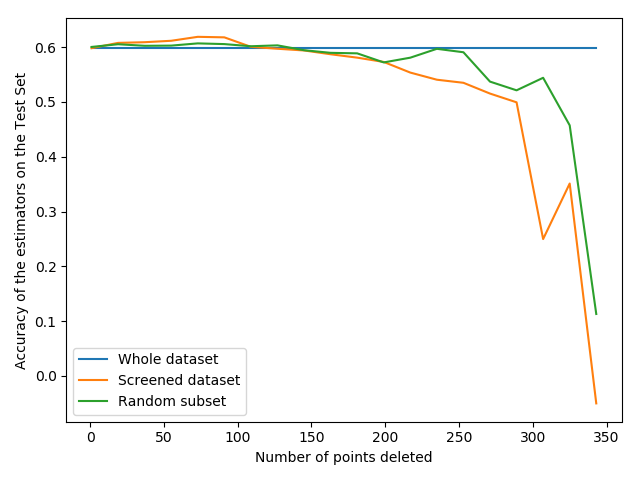

Intercept True lmbda 1.0 Ellipsoid steps 10000 Diabetes
Time to compute z and A: 0.0320432186126709
Time to rank the entire dataset: 0.05411124229431152
(353, 10) (352, 10)
(352, 10)
(353, 10) (334, 10)
(334, 10)
(353, 10) (316, 10)
(316, 10)
(353, 10) (298, 10)
(298, 10)
(353, 10) (280, 10)
(280, 10)
(353, 10) (262, 10)
(262, 10)
(353, 10) (244, 10)
(244, 10)
(353, 10) (226, 10)
(226, 10)
(353, 10) (208, 10)
(208, 10)
(353, 10) (190, 10)
(190, 10)
(353, 10) (172, 10)
(172, 10)
(353, 10) (154, 10)
(154, 10)
(353, 10) (136, 10)
(136, 10)
(353, 10) (118, 10)
(118, 10)
(353, 10) (100, 10)
(100, 10)
(353, 10) (82, 10)
(82, 10)
(353, 10) (64, 10)
(64, 10)
(353, 10) (46, 10)
(46, 10)
(353, 10) (28, 10)
(28, 10)
(353, 10) (10, 10)
(10, 10)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


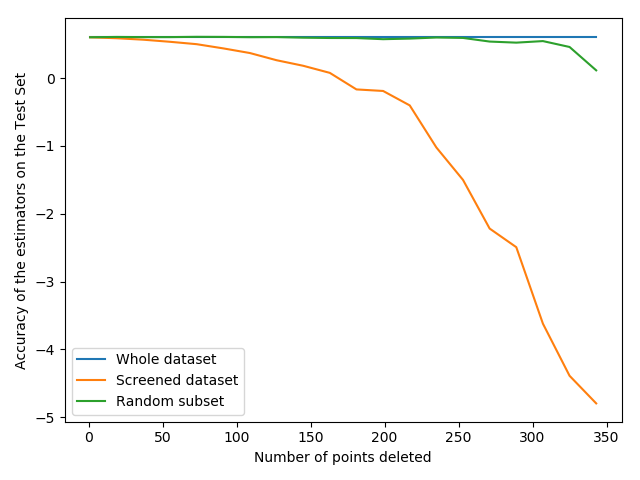

Intercept True lmbda 10.0 Ellipsoid steps 10 Diabetes
Time to compute z and A: 0.3472905158996582
Time to rank the entire dataset: 0.04770851135253906
(353, 10) (352, 10)
(352, 10)
(353, 10) (334, 10)
(334, 10)
(353, 10) (316, 10)
(316, 10)
(353, 10) (298, 10)
(298, 10)
(353, 10) (280, 10)
(280, 10)
(353, 10) (262, 10)
(262, 10)
(353, 10) (244, 10)
(244, 10)
(353, 10) (226, 10)
(226, 10)
(353, 10) (208, 10)
(208, 10)
(353, 10) (190, 10)
(190, 10)
(353, 10) (172, 10)
(172, 10)
(353, 10) (154, 10)
(154, 10)
(353, 10) (136, 10)
(136, 10)
(353, 10) (118, 10)
(118, 10)
(353, 10) (100, 10)
(100, 10)
(353, 10) (82, 10)
(82, 10)
(353, 10) (64, 10)
(64, 10)
(353, 10) (46, 10)
(46, 10)
(353, 10) (28, 10)
(28, 10)
(353, 10) (10, 10)
(10, 10)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


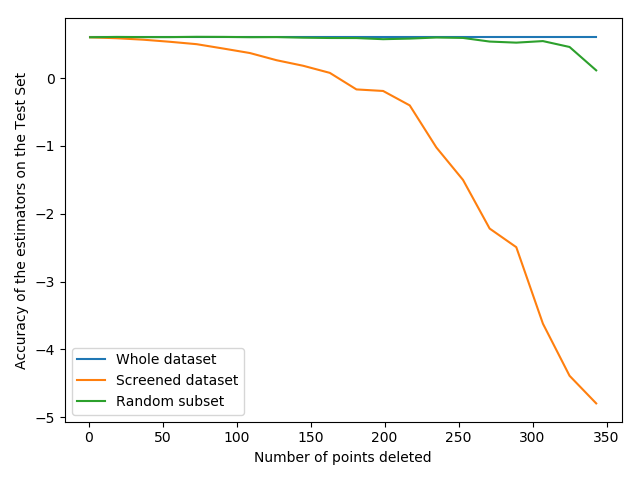

Intercept True lmbda 10.0 Ellipsoid steps 100 Diabetes
Time to compute z and A: 3.1281392574310303
Time to rank the entire dataset: 0.07094049453735352
(353, 10) (352, 10)
(352, 10)
(353, 10) (334, 10)
(334, 10)
(353, 10) (316, 10)
(316, 10)
(353, 10) (298, 10)
(298, 10)
(353, 10) (280, 10)
(280, 10)
(353, 10) (262, 10)
(262, 10)
(353, 10) (244, 10)
(244, 10)
(353, 10) (226, 10)
(226, 10)
(353, 10) (208, 10)
(208, 10)
(353, 10) (190, 10)
(190, 10)
(353, 10) (172, 10)
(172, 10)
(353, 10) (154, 10)
(154, 10)
(353, 10) (136, 10)
(136, 10)
(353, 10) (118, 10)
(118, 10)
(353, 10) (100, 10)
(100, 10)
(353, 10) (82, 10)
(82, 10)
(353, 10) (64, 10)
(64, 10)
(353, 10) (46, 10)
(46, 10)
(353, 10) (28, 10)
(28, 10)
(353, 10) (10, 10)
(10, 10)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


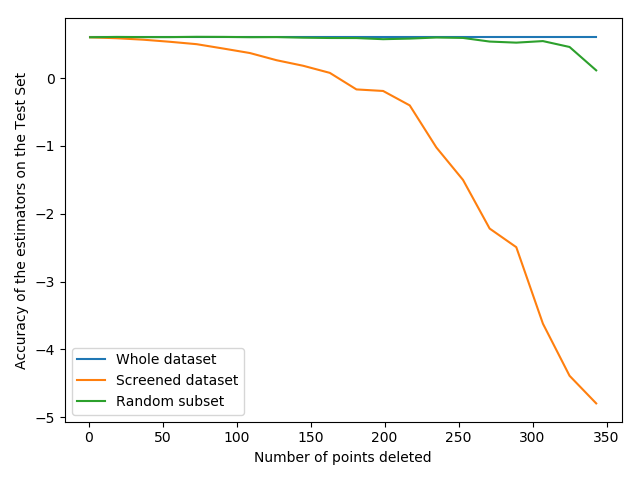

Intercept True lmbda 10.0 Ellipsoid steps 1000 Diabetes


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in sqrt


Time to compute z and A: 20.305793523788452
Time to rank the entire dataset: 0.22083568572998047
(353, 10) (352, 10)
(352, 10)
(353, 10) (334, 10)
(334, 10)
(353, 10) (316, 10)
(316, 10)
(353, 10) (298, 10)
(298, 10)
(353, 10) (280, 10)
(280, 10)
(353, 10) (262, 10)
(262, 10)
(353, 10) (244, 10)
(244, 10)
(353, 10) (226, 10)
(226, 10)
(353, 10) (208, 10)
(208, 10)
(353, 10) (190, 10)
(190, 10)
(353, 10) (172, 10)
(172, 10)
(353, 10) (154, 10)
(154, 10)
(353, 10) (136, 10)
(136, 10)
(353, 10) (118, 10)
(118, 10)
(353, 10) (100, 10)
(100, 10)
(353, 10) (82, 10)
(82, 10)
(353, 10) (64, 10)
(64, 10)
(353, 10) (46, 10)
(46, 10)
(353, 10) (28, 10)
(28, 10)
(353, 10) (10, 10)
(10, 10)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


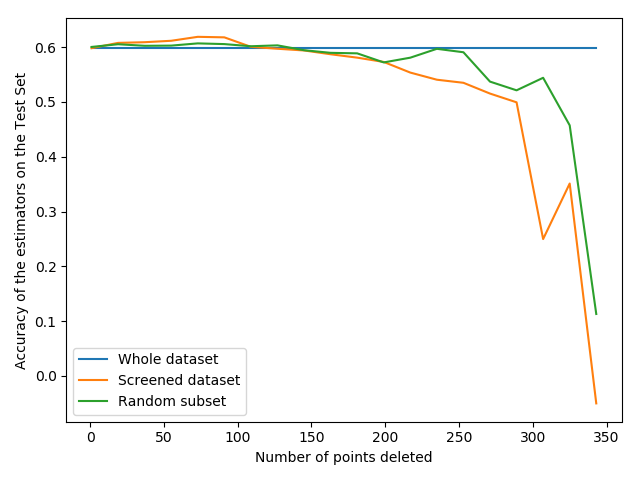

Intercept True lmbda 10.0 Ellipsoid steps 10000 Diabetes
Time to compute z and A: 0.03165721893310547
Time to rank the entire dataset: 0.052710771560668945
(353, 11) (352, 11)
(352, 11)
(353, 11) (334, 11)
(334, 11)
(353, 11) (316, 11)
(316, 11)
(353, 11) (298, 11)
(298, 11)
(353, 11) (280, 11)
(280, 11)
(353, 11) (262, 11)
(262, 11)
(353, 11) (244, 11)
(244, 11)
(353, 11) (226, 11)
(226, 11)
(353, 11) (208, 11)
(208, 11)
(353, 11) (190, 11)
(190, 11)
(353, 11) (172, 11)
(172, 11)
(353, 11) (154, 11)
(154, 11)
(353, 11) (136, 11)
(136, 11)
(353, 11) (118, 11)
(118, 11)
(353, 11) (100, 11)
(100, 11)
(353, 11) (82, 11)
(82, 11)
(353, 11) (64, 11)
(64, 11)
(353, 11) (46, 11)
(46, 11)
(353, 11) (28, 11)
(28, 11)
(353, 11) (10, 11)
(10, 11)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


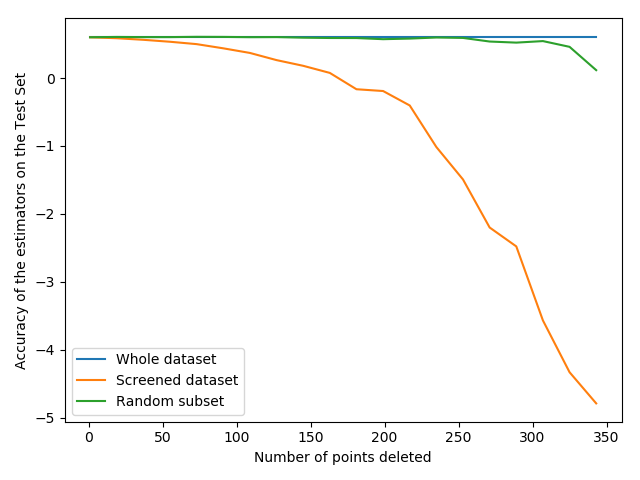

Intercept False lmbda 0.0001 Ellipsoid steps 10 Diabetes
Time to compute z and A: 0.32027626037597656
Time to rank the entire dataset: 0.04514169692993164
(353, 11) (352, 11)
(352, 11)
(353, 11) (334, 11)
(334, 11)
(353, 11) (316, 11)
(316, 11)
(353, 11) (298, 11)
(298, 11)
(353, 11) (280, 11)
(280, 11)
(353, 11) (262, 11)
(262, 11)
(353, 11) (244, 11)
(244, 11)
(353, 11) (226, 11)
(226, 11)
(353, 11) (208, 11)
(208, 11)
(353, 11) (190, 11)
(190, 11)
(353, 11) (172, 11)
(172, 11)
(353, 11) (154, 11)
(154, 11)
(353, 11) (136, 11)
(136, 11)
(353, 11) (118, 11)
(118, 11)
(353, 11) (100, 11)
(100, 11)
(353, 11) (82, 11)
(82, 11)
(353, 11) (64, 11)
(64, 11)
(353, 11) (46, 11)
(46, 11)
(353, 11) (28, 11)
(28, 11)
(353, 11) (10, 11)
(10, 11)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


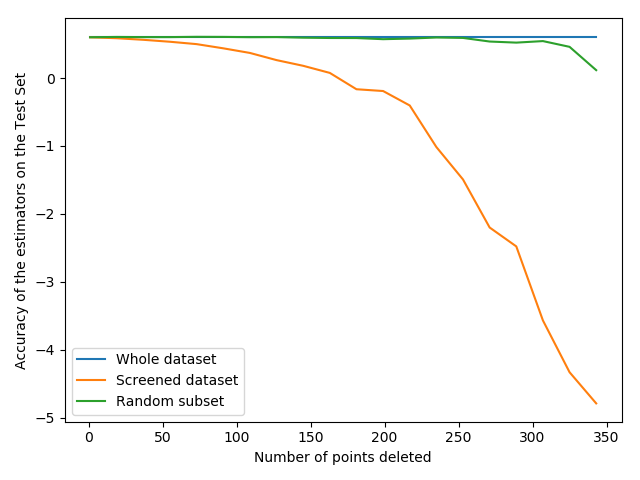

Intercept False lmbda 0.0001 Ellipsoid steps 100 Diabetes


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in sqrt


Time to compute z and A: 2.6769626140594482
Time to rank the entire dataset: 0.10384845733642578
(353, 11) (352, 11)
(352, 11)
(353, 11) (334, 11)
(334, 11)
(353, 11) (316, 11)
(316, 11)
(353, 11) (298, 11)
(298, 11)
(353, 11) (280, 11)
(280, 11)
(353, 11) (262, 11)
(262, 11)
(353, 11) (244, 11)
(244, 11)
(353, 11) (226, 11)
(226, 11)
(353, 11) (208, 11)
(208, 11)
(353, 11) (190, 11)
(190, 11)
(353, 11) (172, 11)
(172, 11)
(353, 11) (154, 11)
(154, 11)
(353, 11) (136, 11)
(136, 11)
(353, 11) (118, 11)
(118, 11)
(353, 11) (100, 11)
(100, 11)
(353, 11) (82, 11)
(82, 11)
(353, 11) (64, 11)
(64, 11)
(353, 11) (46, 11)
(46, 11)
(353, 11) (28, 11)
(28, 11)
(353, 11) (10, 11)
(10, 11)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


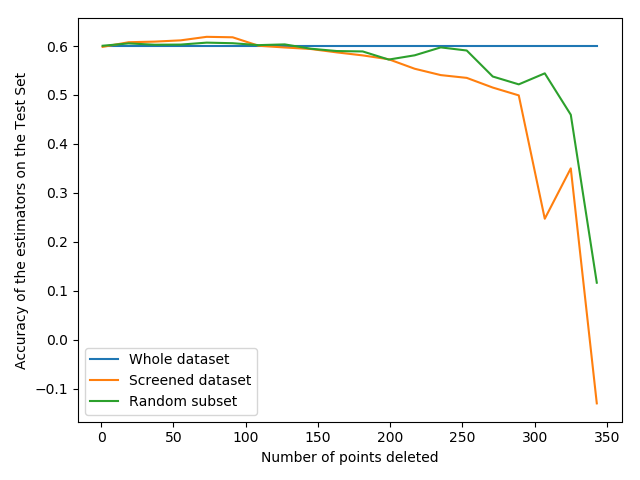

Intercept False lmbda 0.0001 Ellipsoid steps 1000 Diabetes


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in sqrt


Time to compute z and A: 19.472620487213135
Time to rank the entire dataset: 0.2160041332244873
(353, 11) (352, 11)
(352, 11)
(353, 11) (334, 11)
(334, 11)
(353, 11) (316, 11)
(316, 11)
(353, 11) (298, 11)
(298, 11)
(353, 11) (280, 11)
(280, 11)
(353, 11) (262, 11)
(262, 11)
(353, 11) (244, 11)
(244, 11)
(353, 11) (226, 11)
(226, 11)
(353, 11) (208, 11)
(208, 11)
(353, 11) (190, 11)
(190, 11)
(353, 11) (172, 11)
(172, 11)
(353, 11) (154, 11)
(154, 11)
(353, 11) (136, 11)
(136, 11)
(353, 11) (118, 11)
(118, 11)
(353, 11) (100, 11)
(100, 11)
(353, 11) (82, 11)
(82, 11)
(353, 11) (64, 11)
(64, 11)
(353, 11) (46, 11)
(46, 11)
(353, 11) (28, 11)
(28, 11)
(353, 11) (10, 11)
(10, 11)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


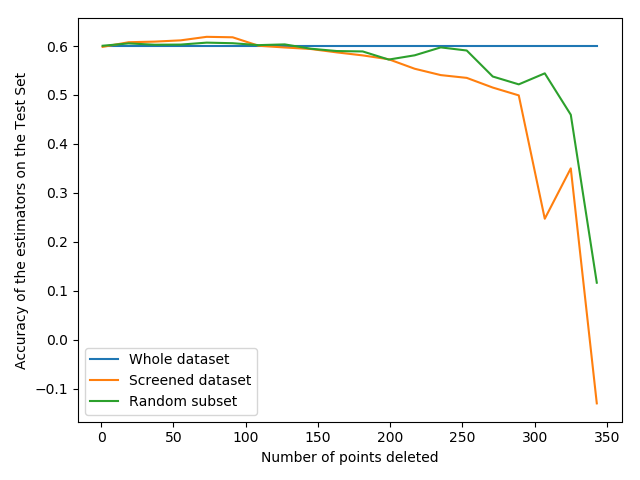

Intercept False lmbda 0.0001 Ellipsoid steps 10000 Diabetes
Time to compute z and A: 0.03863811492919922
Time to rank the entire dataset: 0.058927297592163086
(353, 11) (352, 11)
(352, 11)
(353, 11) (334, 11)
(334, 11)
(353, 11) (316, 11)
(316, 11)
(353, 11) (298, 11)
(298, 11)
(353, 11) (280, 11)
(280, 11)
(353, 11) (262, 11)
(262, 11)
(353, 11) (244, 11)
(244, 11)
(353, 11) (226, 11)
(226, 11)
(353, 11) (208, 11)
(208, 11)
(353, 11) (190, 11)
(190, 11)
(353, 11) (172, 11)
(172, 11)
(353, 11) (154, 11)
(154, 11)
(353, 11) (136, 11)
(136, 11)
(353, 11) (118, 11)
(118, 11)
(353, 11) (100, 11)
(100, 11)
(353, 11) (82, 11)
(82, 11)
(353, 11) (64, 11)
(64, 11)
(353, 11) (46, 11)
(46, 11)
(353, 11) (28, 11)
(28, 11)
(353, 11) (10, 11)
(10, 11)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


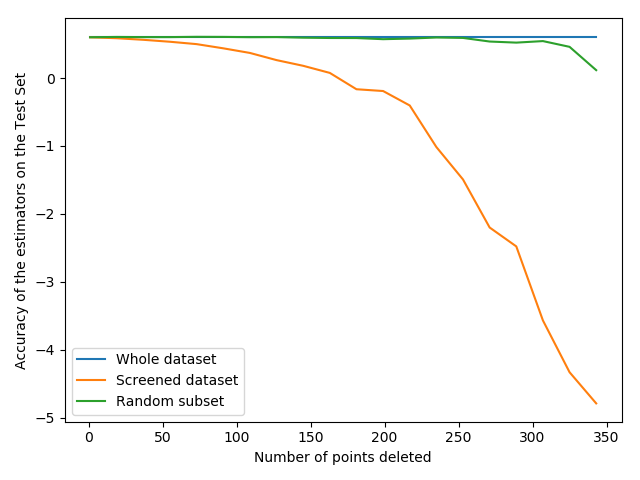

Intercept False lmbda 0.001 Ellipsoid steps 10 Diabetes
Time to compute z and A: 0.36182212829589844
Time to rank the entire dataset: 0.05358290672302246
(353, 11) (352, 11)
(352, 11)
(353, 11) (334, 11)
(334, 11)
(353, 11) (316, 11)
(316, 11)
(353, 11) (298, 11)
(298, 11)
(353, 11) (280, 11)
(280, 11)
(353, 11) (262, 11)
(262, 11)
(353, 11) (244, 11)
(244, 11)
(353, 11) (226, 11)
(226, 11)
(353, 11) (208, 11)
(208, 11)
(353, 11) (190, 11)
(190, 11)
(353, 11) (172, 11)
(172, 11)
(353, 11) (154, 11)
(154, 11)
(353, 11) (136, 11)
(136, 11)
(353, 11) (118, 11)
(118, 11)
(353, 11) (100, 11)
(100, 11)
(353, 11) (82, 11)
(82, 11)
(353, 11) (64, 11)
(64, 11)
(353, 11) (46, 11)
(46, 11)
(353, 11) (28, 11)
(28, 11)
(353, 11) (10, 11)
(10, 11)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


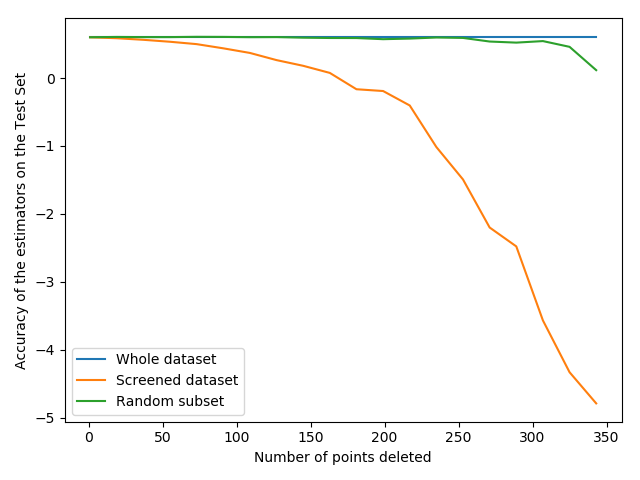

Intercept False lmbda 0.001 Ellipsoid steps 100 Diabetes


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in sqrt


Time to compute z and A: 2.645909070968628
Time to rank the entire dataset: 0.1022193431854248
(353, 11) (352, 11)
(352, 11)
(353, 11) (334, 11)
(334, 11)
(353, 11) (316, 11)
(316, 11)
(353, 11) (298, 11)
(298, 11)
(353, 11) (280, 11)
(280, 11)
(353, 11) (262, 11)
(262, 11)
(353, 11) (244, 11)
(244, 11)
(353, 11) (226, 11)
(226, 11)
(353, 11) (208, 11)
(208, 11)
(353, 11) (190, 11)
(190, 11)
(353, 11) (172, 11)
(172, 11)
(353, 11) (154, 11)
(154, 11)
(353, 11) (136, 11)
(136, 11)
(353, 11) (118, 11)
(118, 11)
(353, 11) (100, 11)
(100, 11)
(353, 11) (82, 11)
(82, 11)
(353, 11) (64, 11)
(64, 11)
(353, 11) (46, 11)
(46, 11)
(353, 11) (28, 11)
(28, 11)
(353, 11) (10, 11)
(10, 11)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


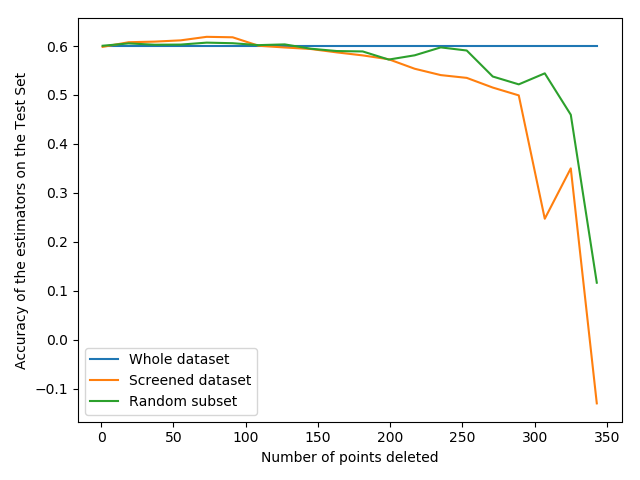

Intercept False lmbda 0.001 Ellipsoid steps 1000 Diabetes


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in sqrt


Time to compute z and A: 19.13267421722412
Time to rank the entire dataset: 0.20473575592041016
(353, 11) (352, 11)
(352, 11)
(353, 11) (334, 11)
(334, 11)
(353, 11) (316, 11)
(316, 11)
(353, 11) (298, 11)
(298, 11)
(353, 11) (280, 11)
(280, 11)
(353, 11) (262, 11)
(262, 11)
(353, 11) (244, 11)
(244, 11)
(353, 11) (226, 11)
(226, 11)
(353, 11) (208, 11)
(208, 11)
(353, 11) (190, 11)
(190, 11)
(353, 11) (172, 11)
(172, 11)
(353, 11) (154, 11)
(154, 11)
(353, 11) (136, 11)
(136, 11)
(353, 11) (118, 11)
(118, 11)
(353, 11) (100, 11)
(100, 11)
(353, 11) (82, 11)
(82, 11)
(353, 11) (64, 11)
(64, 11)
(353, 11) (46, 11)
(46, 11)
(353, 11) (28, 11)
(28, 11)
(353, 11) (10, 11)
(10, 11)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>

Intercept False lmbda 0.001 Ellipsoid steps 10000 Diabetes
Time to compute z and A: 0.032094717025756836
Time to rank the entire dataset: 0.0517878532409668
(353, 11) (352, 11)
(352, 11)
(353, 11) (334, 11)
(334, 11)
(353, 11) (316, 11)
(316, 11)
(353, 11) (298, 11)
(298, 11)
(353, 11) (280, 11)
(280, 11)
(353, 11) (262, 11)
(262, 11)
(353, 11) (244, 11)
(244, 11)
(353, 11) (226, 11)
(226, 11)
(353, 11) (208, 11)
(208, 11)
(353, 11) (190, 11)
(190, 11)
(353, 11) (172, 11)
(172, 11)
(353, 11) (154, 11)
(154, 11)
(353, 11) (136, 11)
(136, 11)
(353, 11) (118, 11)
(118, 11)
(353, 11) (100, 11)
(100, 11)
(353, 11) (82, 11)
(82, 11)
(353, 11) (64, 11)
(64, 11)
(353, 11) (46, 11)
(46, 11)
(353, 11) (28, 11)
(28, 11)
(353, 11) (10, 11)
(10, 11)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


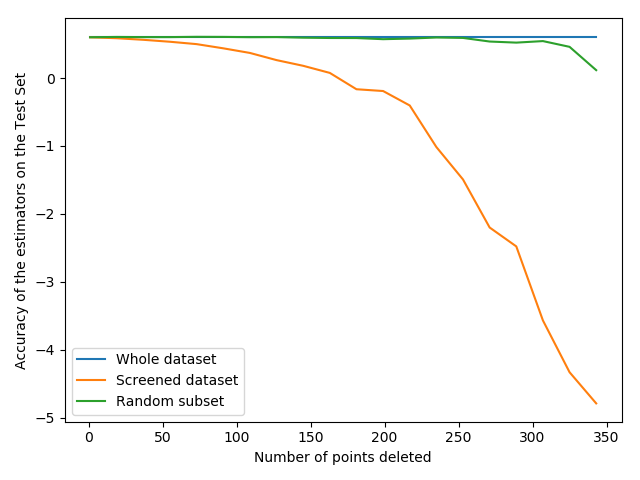

Intercept False lmbda 0.01 Ellipsoid steps 10 Diabetes
Time to compute z and A: 0.3722362518310547
Time to rank the entire dataset: 0.051296234130859375
(353, 11) (352, 11)
(352, 11)
(353, 11) (334, 11)
(334, 11)
(353, 11) (316, 11)
(316, 11)
(353, 11) (298, 11)
(298, 11)
(353, 11) (280, 11)
(280, 11)
(353, 11) (262, 11)
(262, 11)
(353, 11) (244, 11)
(244, 11)
(353, 11) (226, 11)
(226, 11)
(353, 11) (208, 11)
(208, 11)
(353, 11) (190, 11)
(190, 11)
(353, 11) (172, 11)
(172, 11)
(353, 11) (154, 11)
(154, 11)
(353, 11) (136, 11)
(136, 11)
(353, 11) (118, 11)
(118, 11)
(353, 11) (100, 11)
(100, 11)
(353, 11) (82, 11)
(82, 11)
(353, 11) (64, 11)
(64, 11)
(353, 11) (46, 11)
(46, 11)
(353, 11) (28, 11)
(28, 11)
(353, 11) (10, 11)
(10, 11)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


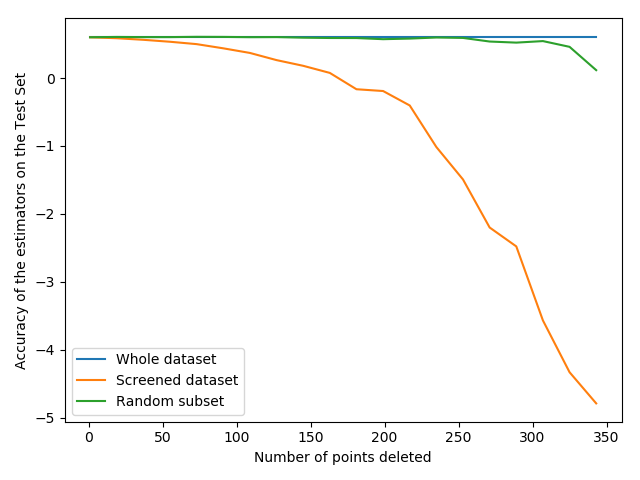

Intercept False lmbda 0.01 Ellipsoid steps 100 Diabetes


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in sqrt


Time to compute z and A: 2.554004669189453
Time to rank the entire dataset: 0.10274553298950195
(353, 11) (352, 11)
(352, 11)
(353, 11) (334, 11)
(334, 11)
(353, 11) (316, 11)
(316, 11)
(353, 11) (298, 11)
(298, 11)
(353, 11) (280, 11)
(280, 11)
(353, 11) (262, 11)
(262, 11)
(353, 11) (244, 11)
(244, 11)
(353, 11) (226, 11)
(226, 11)
(353, 11) (208, 11)
(208, 11)
(353, 11) (190, 11)
(190, 11)
(353, 11) (172, 11)
(172, 11)
(353, 11) (154, 11)
(154, 11)
(353, 11) (136, 11)
(136, 11)
(353, 11) (118, 11)
(118, 11)
(353, 11) (100, 11)
(100, 11)
(353, 11) (82, 11)
(82, 11)
(353, 11) (64, 11)
(64, 11)
(353, 11) (46, 11)
(46, 11)
(353, 11) (28, 11)
(28, 11)
(353, 11) (10, 11)
(10, 11)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


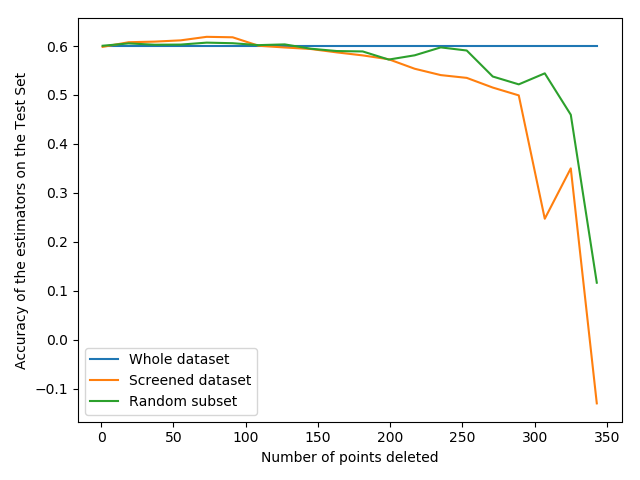

Intercept False lmbda 0.01 Ellipsoid steps 1000 Diabetes


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in sqrt


Time to compute z and A: 18.496824979782104
Time to rank the entire dataset: 0.22907519340515137
(353, 11) (352, 11)
(352, 11)
(353, 11) (334, 11)
(334, 11)
(353, 11) (316, 11)
(316, 11)
(353, 11) (298, 11)
(298, 11)
(353, 11) (280, 11)
(280, 11)
(353, 11) (262, 11)
(262, 11)
(353, 11) (244, 11)
(244, 11)
(353, 11) (226, 11)
(226, 11)
(353, 11) (208, 11)
(208, 11)
(353, 11) (190, 11)
(190, 11)
(353, 11) (172, 11)
(172, 11)
(353, 11) (154, 11)
(154, 11)
(353, 11) (136, 11)
(136, 11)
(353, 11) (118, 11)
(118, 11)
(353, 11) (100, 11)
(100, 11)
(353, 11) (82, 11)
(82, 11)
(353, 11) (64, 11)
(64, 11)
(353, 11) (46, 11)
(46, 11)
(353, 11) (28, 11)
(28, 11)
(353, 11) (10, 11)
(10, 11)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


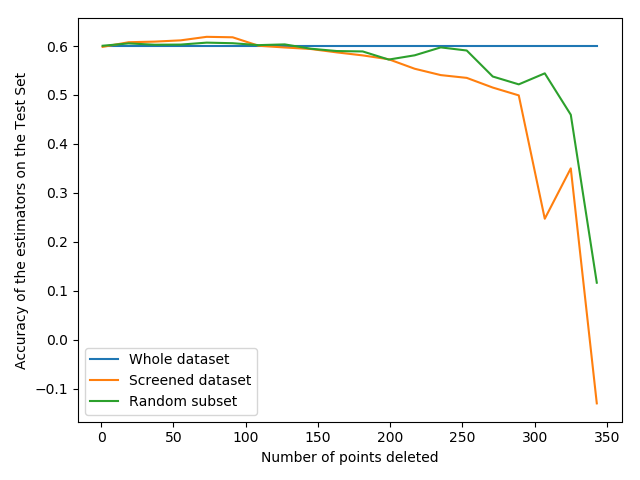

Intercept False lmbda 0.01 Ellipsoid steps 10000 Diabetes
Time to compute z and A: 0.032477378845214844
Time to rank the entire dataset: 0.055212974548339844
(353, 11) (352, 11)
(352, 11)
(353, 11) (334, 11)
(334, 11)
(353, 11) (316, 11)
(316, 11)
(353, 11) (298, 11)
(298, 11)
(353, 11) (280, 11)
(280, 11)
(353, 11) (262, 11)
(262, 11)
(353, 11) (244, 11)
(244, 11)
(353, 11) (226, 11)
(226, 11)
(353, 11) (208, 11)
(208, 11)
(353, 11) (190, 11)
(190, 11)
(353, 11) (172, 11)
(172, 11)
(353, 11) (154, 11)
(154, 11)
(353, 11) (136, 11)
(136, 11)
(353, 11) (118, 11)
(118, 11)
(353, 11) (100, 11)
(100, 11)
(353, 11) (82, 11)
(82, 11)
(353, 11) (64, 11)
(64, 11)
(353, 11) (46, 11)
(46, 11)
(353, 11) (28, 11)
(28, 11)
(353, 11) (10, 11)
(10, 11)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


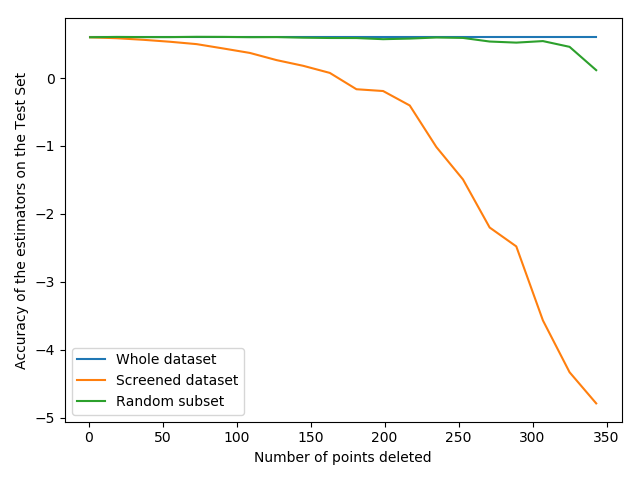

Intercept False lmbda 0.1 Ellipsoid steps 10 Diabetes
Time to compute z and A: 0.3296949863433838
Time to rank the entire dataset: 0.047833919525146484
(353, 11) (352, 11)
(352, 11)
(353, 11) (334, 11)
(334, 11)
(353, 11) (316, 11)
(316, 11)
(353, 11) (298, 11)
(298, 11)
(353, 11) (280, 11)
(280, 11)
(353, 11) (262, 11)
(262, 11)
(353, 11) (244, 11)
(244, 11)
(353, 11) (226, 11)
(226, 11)
(353, 11) (208, 11)
(208, 11)
(353, 11) (190, 11)
(190, 11)
(353, 11) (172, 11)
(172, 11)
(353, 11) (154, 11)
(154, 11)
(353, 11) (136, 11)
(136, 11)
(353, 11) (118, 11)
(118, 11)
(353, 11) (100, 11)
(100, 11)
(353, 11) (82, 11)
(82, 11)
(353, 11) (64, 11)
(64, 11)
(353, 11) (46, 11)
(46, 11)
(353, 11) (28, 11)
(28, 11)
(353, 11) (10, 11)
(10, 11)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>

Intercept False lmbda 0.1 Ellipsoid steps 100 Diabetes


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in sqrt


Time to compute z and A: 2.18863844871521
Time to rank the entire dataset: 0.08591723442077637
(353, 11) (352, 11)
(352, 11)
(353, 11) (334, 11)
(334, 11)
(353, 11) (316, 11)
(316, 11)
(353, 11) (298, 11)
(298, 11)
(353, 11) (280, 11)
(280, 11)
(353, 11) (262, 11)
(262, 11)
(353, 11) (244, 11)
(244, 11)
(353, 11) (226, 11)
(226, 11)
(353, 11) (208, 11)
(208, 11)
(353, 11) (190, 11)
(190, 11)
(353, 11) (172, 11)
(172, 11)
(353, 11) (154, 11)
(154, 11)
(353, 11) (136, 11)
(136, 11)
(353, 11) (118, 11)
(118, 11)
(353, 11) (100, 11)
(100, 11)
(353, 11) (82, 11)
(82, 11)
(353, 11) (64, 11)
(64, 11)
(353, 11) (46, 11)
(46, 11)
(353, 11) (28, 11)
(28, 11)
(353, 11) (10, 11)
(10, 11)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


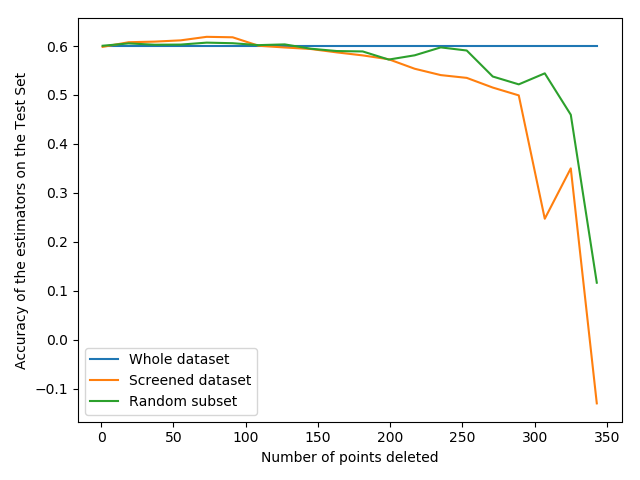

Intercept False lmbda 0.1 Ellipsoid steps 1000 Diabetes


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in sqrt


Time to compute z and A: 17.561545610427856
Time to rank the entire dataset: 0.24614810943603516
(353, 11) (352, 11)
(352, 11)
(353, 11) (334, 11)
(334, 11)
(353, 11) (316, 11)
(316, 11)
(353, 11) (298, 11)
(298, 11)
(353, 11) (280, 11)
(280, 11)
(353, 11) (262, 11)
(262, 11)
(353, 11) (244, 11)
(244, 11)
(353, 11) (226, 11)
(226, 11)
(353, 11) (208, 11)
(208, 11)
(353, 11) (190, 11)
(190, 11)
(353, 11) (172, 11)
(172, 11)
(353, 11) (154, 11)
(154, 11)
(353, 11) (136, 11)
(136, 11)
(353, 11) (118, 11)
(118, 11)
(353, 11) (100, 11)
(100, 11)
(353, 11) (82, 11)
(82, 11)
(353, 11) (64, 11)
(64, 11)
(353, 11) (46, 11)
(46, 11)
(353, 11) (28, 11)
(28, 11)
(353, 11) (10, 11)
(10, 11)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


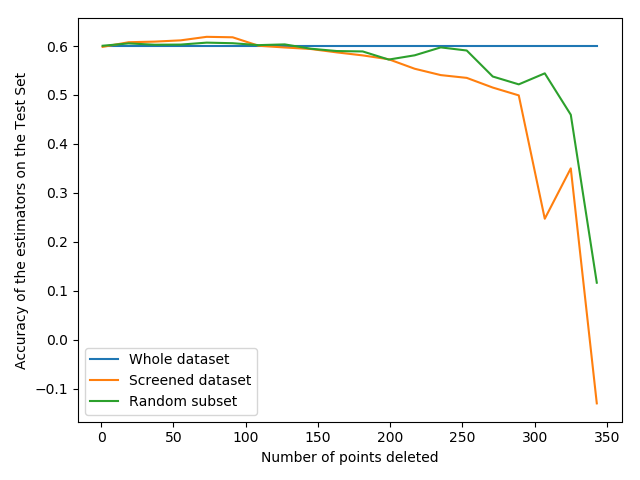

Intercept False lmbda 0.1 Ellipsoid steps 10000 Diabetes
Time to compute z and A: 0.035895586013793945
Time to rank the entire dataset: 0.04952406883239746
(353, 11) (352, 11)
(352, 11)
(353, 11) (334, 11)
(334, 11)
(353, 11) (316, 11)
(316, 11)
(353, 11) (298, 11)
(298, 11)
(353, 11) (280, 11)
(280, 11)
(353, 11) (262, 11)
(262, 11)
(353, 11) (244, 11)
(244, 11)
(353, 11) (226, 11)
(226, 11)
(353, 11) (208, 11)
(208, 11)
(353, 11) (190, 11)
(190, 11)
(353, 11) (172, 11)
(172, 11)
(353, 11) (154, 11)
(154, 11)
(353, 11) (136, 11)
(136, 11)
(353, 11) (118, 11)
(118, 11)
(353, 11) (100, 11)
(100, 11)
(353, 11) (82, 11)
(82, 11)
(353, 11) (64, 11)
(64, 11)
(353, 11) (46, 11)
(46, 11)
(353, 11) (28, 11)
(28, 11)
(353, 11) (10, 11)
(10, 11)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


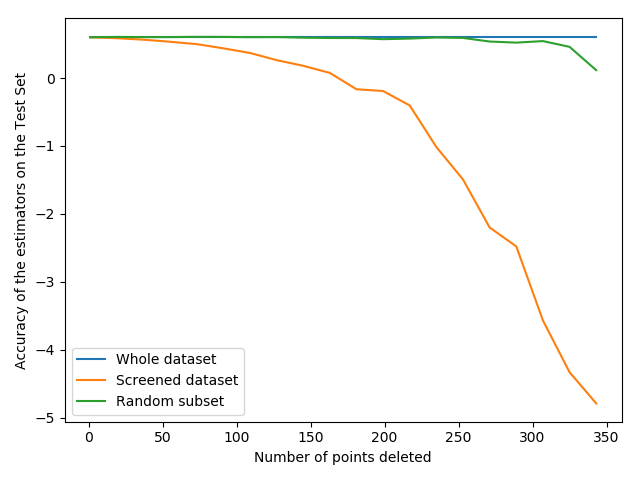

Intercept False lmbda 1.0 Ellipsoid steps 10 Diabetes
Time to compute z and A: 0.3283505439758301
Time to rank the entire dataset: 0.05030989646911621
(353, 11) (352, 11)
(352, 11)
(353, 11) (334, 11)
(334, 11)
(353, 11) (316, 11)
(316, 11)
(353, 11) (298, 11)
(298, 11)
(353, 11) (280, 11)
(280, 11)
(353, 11) (262, 11)
(262, 11)
(353, 11) (244, 11)
(244, 11)
(353, 11) (226, 11)
(226, 11)
(353, 11) (208, 11)
(208, 11)
(353, 11) (190, 11)
(190, 11)
(353, 11) (172, 11)
(172, 11)
(353, 11) (154, 11)
(154, 11)
(353, 11) (136, 11)
(136, 11)
(353, 11) (118, 11)
(118, 11)
(353, 11) (100, 11)
(100, 11)
(353, 11) (82, 11)
(82, 11)
(353, 11) (64, 11)
(64, 11)
(353, 11) (46, 11)
(46, 11)
(353, 11) (28, 11)
(28, 11)
(353, 11) (10, 11)
(10, 11)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


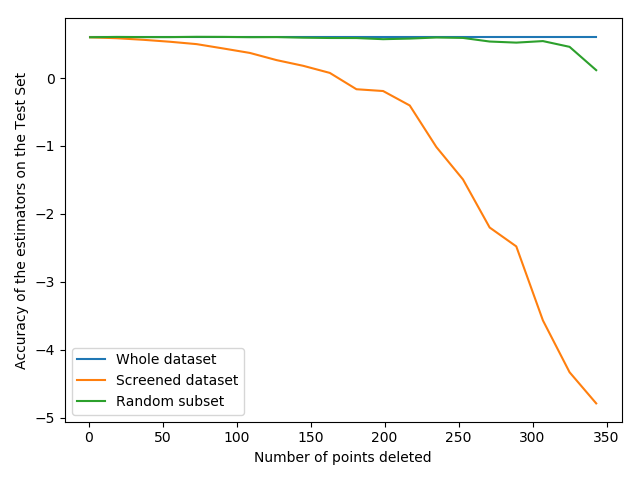

Intercept False lmbda 1.0 Ellipsoid steps 100 Diabetes


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in sqrt


Time to compute z and A: 2.212188959121704
Time to rank the entire dataset: 0.08425593376159668
(353, 11) (352, 11)
(352, 11)
(353, 11) (334, 11)
(334, 11)
(353, 11) (316, 11)
(316, 11)
(353, 11) (298, 11)
(298, 11)
(353, 11) (280, 11)
(280, 11)
(353, 11) (262, 11)
(262, 11)
(353, 11) (244, 11)
(244, 11)
(353, 11) (226, 11)
(226, 11)
(353, 11) (208, 11)
(208, 11)
(353, 11) (190, 11)
(190, 11)
(353, 11) (172, 11)
(172, 11)
(353, 11) (154, 11)
(154, 11)
(353, 11) (136, 11)
(136, 11)
(353, 11) (118, 11)
(118, 11)
(353, 11) (100, 11)
(100, 11)
(353, 11) (82, 11)
(82, 11)
(353, 11) (64, 11)
(64, 11)
(353, 11) (46, 11)
(46, 11)
(353, 11) (28, 11)
(28, 11)
(353, 11) (10, 11)
(10, 11)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


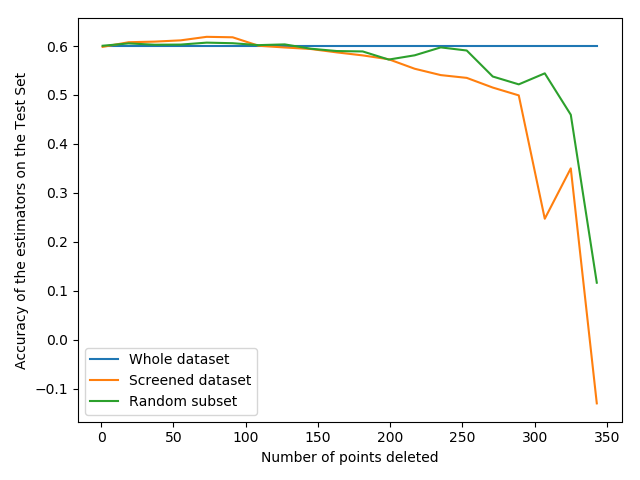

Intercept False lmbda 1.0 Ellipsoid steps 1000 Diabetes


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in sqrt


Time to compute z and A: 18.18099355697632
Time to rank the entire dataset: 0.22494888305664062
(353, 11) (352, 11)
(352, 11)
(353, 11) (334, 11)
(334, 11)
(353, 11) (316, 11)
(316, 11)
(353, 11) (298, 11)
(298, 11)
(353, 11) (280, 11)
(280, 11)
(353, 11) (262, 11)
(262, 11)
(353, 11) (244, 11)
(244, 11)
(353, 11) (226, 11)
(226, 11)
(353, 11) (208, 11)
(208, 11)
(353, 11) (190, 11)
(190, 11)
(353, 11) (172, 11)
(172, 11)
(353, 11) (154, 11)
(154, 11)
(353, 11) (136, 11)
(136, 11)
(353, 11) (118, 11)
(118, 11)
(353, 11) (100, 11)
(100, 11)
(353, 11) (82, 11)
(82, 11)
(353, 11) (64, 11)
(64, 11)
(353, 11) (46, 11)
(46, 11)
(353, 11) (28, 11)
(28, 11)
(353, 11) (10, 11)
(10, 11)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


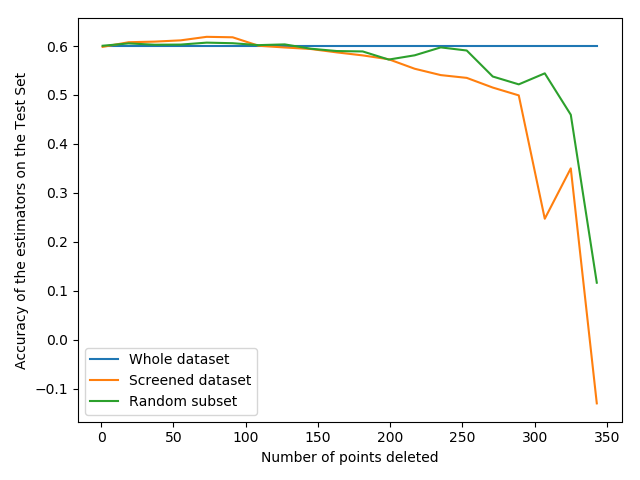

Intercept False lmbda 1.0 Ellipsoid steps 10000 Diabetes
Time to compute z and A: 0.034388065338134766
Time to rank the entire dataset: 0.06689047813415527
(353, 11) (352, 11)
(352, 11)
(353, 11) (334, 11)
(334, 11)
(353, 11) (316, 11)
(316, 11)
(353, 11) (298, 11)
(298, 11)
(353, 11) (280, 11)
(280, 11)
(353, 11) (262, 11)
(262, 11)
(353, 11) (244, 11)
(244, 11)
(353, 11) (226, 11)
(226, 11)
(353, 11) (208, 11)
(208, 11)
(353, 11) (190, 11)
(190, 11)
(353, 11) (172, 11)
(172, 11)
(353, 11) (154, 11)
(154, 11)
(353, 11) (136, 11)
(136, 11)
(353, 11) (118, 11)
(118, 11)
(353, 11) (100, 11)
(100, 11)
(353, 11) (82, 11)
(82, 11)
(353, 11) (64, 11)
(64, 11)
(353, 11) (46, 11)
(46, 11)
(353, 11) (28, 11)
(28, 11)
(353, 11) (10, 11)
(10, 11)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


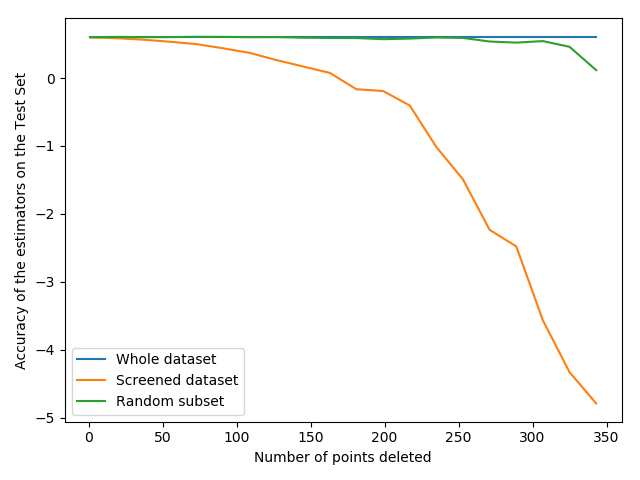

Intercept False lmbda 10.0 Ellipsoid steps 10 Diabetes
Time to compute z and A: 0.321150541305542
Time to rank the entire dataset: 0.049295663833618164
(353, 11) (352, 11)
(352, 11)
(353, 11) (334, 11)
(334, 11)
(353, 11) (316, 11)
(316, 11)
(353, 11) (298, 11)
(298, 11)
(353, 11) (280, 11)
(280, 11)
(353, 11) (262, 11)
(262, 11)
(353, 11) (244, 11)
(244, 11)
(353, 11) (226, 11)
(226, 11)
(353, 11) (208, 11)
(208, 11)
(353, 11) (190, 11)
(190, 11)
(353, 11) (172, 11)
(172, 11)
(353, 11) (154, 11)
(154, 11)
(353, 11) (136, 11)
(136, 11)
(353, 11) (118, 11)
(118, 11)
(353, 11) (100, 11)
(100, 11)
(353, 11) (82, 11)
(82, 11)
(353, 11) (64, 11)
(64, 11)
(353, 11) (46, 11)
(46, 11)
(353, 11) (28, 11)
(28, 11)
(353, 11) (10, 11)
(10, 11)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


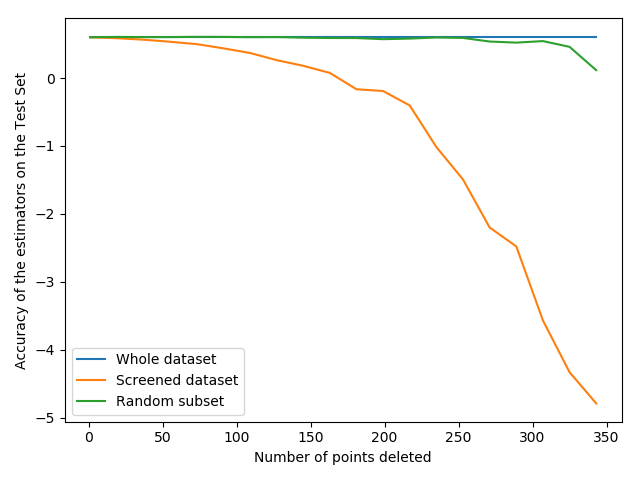

Intercept False lmbda 10.0 Ellipsoid steps 100 Diabetes
Time to compute z and A: 3.1065590381622314
Time to rank the entire dataset: 0.07261991500854492
(353, 11) (352, 11)
(352, 11)
(353, 11) (334, 11)
(334, 11)
(353, 11) (316, 11)
(316, 11)
(353, 11) (298, 11)
(298, 11)
(353, 11) (280, 11)
(280, 11)
(353, 11) (262, 11)
(262, 11)
(353, 11) (244, 11)
(244, 11)
(353, 11) (226, 11)
(226, 11)
(353, 11) (208, 11)
(208, 11)
(353, 11) (190, 11)
(190, 11)
(353, 11) (172, 11)
(172, 11)
(353, 11) (154, 11)
(154, 11)
(353, 11) (136, 11)
(136, 11)
(353, 11) (118, 11)
(118, 11)
(353, 11) (100, 11)
(100, 11)
(353, 11) (82, 11)
(82, 11)
(353, 11) (64, 11)
(64, 11)
(353, 11) (46, 11)
(46, 11)
(353, 11) (28, 11)
(28, 11)
(353, 11) (10, 11)
(10, 11)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


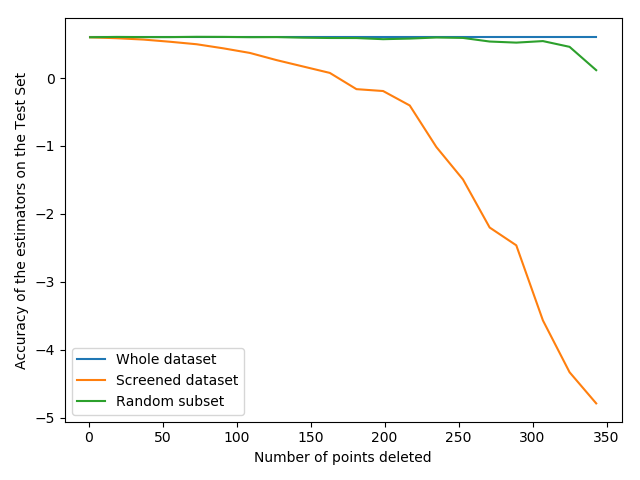

Intercept False lmbda 10.0 Ellipsoid steps 1000 Diabetes


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in sqrt


Time to compute z and A: 20.91593861579895
Time to rank the entire dataset: 0.24084091186523438
(353, 11) (352, 11)
(352, 11)
(353, 11) (334, 11)
(334, 11)
(353, 11) (316, 11)
(316, 11)
(353, 11) (298, 11)
(298, 11)
(353, 11) (280, 11)
(280, 11)
(353, 11) (262, 11)
(262, 11)
(353, 11) (244, 11)
(244, 11)
(353, 11) (226, 11)
(226, 11)
(353, 11) (208, 11)
(208, 11)
(353, 11) (190, 11)
(190, 11)
(353, 11) (172, 11)
(172, 11)
(353, 11) (154, 11)
(154, 11)
(353, 11) (136, 11)
(136, 11)
(353, 11) (118, 11)
(118, 11)
(353, 11) (100, 11)
(100, 11)
(353, 11) (82, 11)
(82, 11)
(353, 11) (64, 11)
(64, 11)
(353, 11) (46, 11)
(46, 11)
(353, 11) (28, 11)
(28, 11)
(353, 11) (10, 11)
(10, 11)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


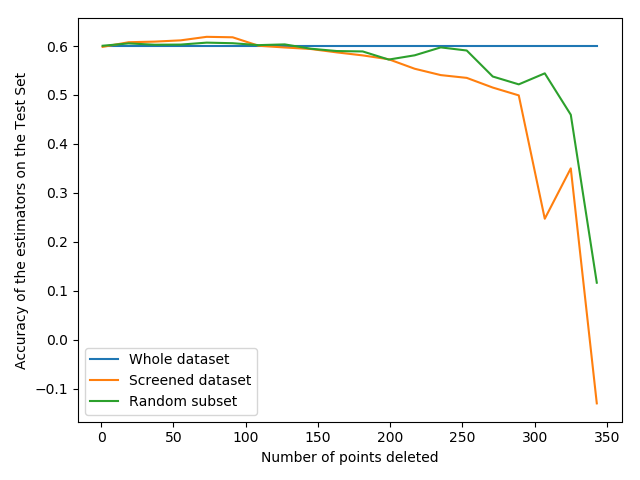

Intercept False lmbda 10.0 Ellipsoid steps 10000 Diabetes


In [41]:
diabetes = load_diabetes(return_X_y=True)
X = diabetes[0]
y = diabetes[1]
for intercept in [True, False]:
    for lmbda in [0.0001, 0.001, 0.01, 0.1, 1., 10.]:
        for n_ellipsoid_steps in [10, 100, 1000, 10000]:
            experiment_real(X, y, nb_delete_steps=20, lmbda=lmbda, intercept=intercept,
                            n_ellipsoid_steps=n_ellipsoid_steps, nb_test=3)
            print('Intercept', intercept, 'lmbda', lmbda, 'Ellipsoid steps',
                  n_ellipsoid_steps, 'Diabetes')

# 20newsgroup dataset

In [1]:
from sklearn.datasets import fetch_20newsgroups
cats = ['comp.graphics','talk.religion.misc']
newsgroups_train = fetch_20newsgroups(subset='train', categories=cats)

from pprint import pprint
pprint(list(newsgroups_train.target_names))

['comp.graphics', 'talk.religion.misc']


In [2]:
X = newsgroups_train.data
y = newsgroups_train.target

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)
X = vectorizer.fit_transform(X).toarray()
y = 2 * y - np.ones(len(y))

experiment_real(X, y, nb_delete_steps=20, lmbda=0.01, intercept=False, classification=True,
                n_ellipsoid_steps=1000, nb_test=3)

NameError: name 'np' is not defined

# Plots

<IPython.core.display.Javascript object>


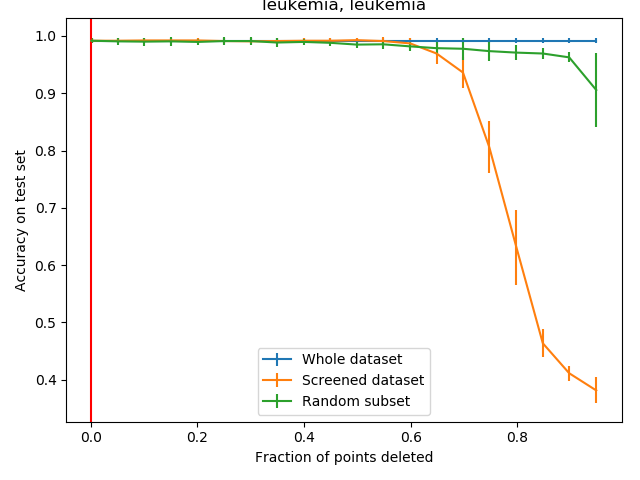

In [66]:
from tools import *
dir = '/home/ROCQ/sierra/gmialon/research/safe_datapoints/results/20newsgroups/'
exp = 'lmbda_0.01_n_ellipsoid_100_intercept_False_mu_1.0_classif_score_True_loss_hinge_penalty_l2.npy'
data = np.load(dir + exp)
plot_experiment(data, 'leukemia', 'leukemia', 768)

<IPython.core.display.Javascript object>


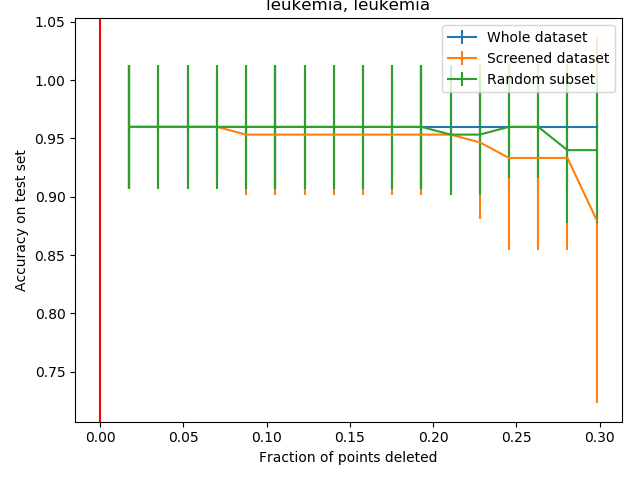

In [68]:
dir_cluster = '/sequoia/data1/gmialon/screening/results/leukemia/'
exp = 'lmbda_0.1_n_ellipsoid_1000_intercept_True_mu_1.0_classif_score_True_loss_truncated_squared_penalty_l1.npy'
data = np.load(dir_cluster + exp)
plot_experiment(data, 'leukemia', 'leukemia', 57)

In [108]:
import scipy.io
PATH = '/nas/home2/g/gmialon/'
mat = scipy.io.loadmat(PATH + 'ckn_mnist.mat')
X = mat['psiTr'][:,:10].T
print(X.shape)
y = mat['Ytr'][:10]
y_ = np.array(y, dtype=int).reshape(y.shape[0])
print(y_.shape)

for i in range(len(y_)):
    if y_[i] != 1:
        y_[i] = - 1
X, y_

(10, 2304)
(10,)


(array([[-0.01872686, -0.00191456, -0.01708402, ..., -0.00903333,
         -0.01956305, -0.01971718],
        [-0.02037215, -0.02008704, -0.01638448, ..., -0.00764308,
         -0.01953134, -0.01748277],
        [-0.0168631 , -0.00982371, -0.00851147, ...,  0.01421643,
         -0.01825515, -0.01583317],
        ..., 
        [-0.01928672, -0.01455382, -0.01473771, ..., -0.00718081,
         -0.01929806, -0.01889716],
        [-0.01234765, -0.01197725, -0.01142529, ...,  0.01698719,
         -0.01263527, -0.01321515],
        [-0.01817888, -0.01626832, -0.01081478, ..., -0.01071567,
         -0.01834714, -0.01838115]], dtype=float32),
 array([-1, -1, -1,  1, -1, -1,  1, -1,  1, -1]))

In [109]:
def balanced_subsample(x,y,subsample_size=1):

    class_xs = []
    min_elems = None

    for yi in np.unique(y):
        elems = x[(y == yi)]
        class_xs.append((yi, elems))
        if min_elems == None or elems.shape[0] < min_elems:
            min_elems = elems.shape[0]

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems*subsample_size)

    xs = []
    ys = []

    for ci,this_xs in class_xs:
        if len(this_xs) > use_elems:
            np.random.shuffle(this_xs)

        x_ = this_xs[:use_elems]
        y_ = np.empty(use_elems)
        y_.fill(ci)

        xs.append(x_)
        ys.append(y_)

    xs = np.concatenate(xs)
    ys = np.concatenate(ys)

    return xs,ys

X_s, y_s = balanced_subsample(X, y_)
X_s, y_s

(array([[-0.01872686, -0.00191456, -0.01708402, ..., -0.00903333,
         -0.01956305, -0.01971718],
        [-0.01817888, -0.01626832, -0.01081478, ..., -0.01071567,
         -0.01834714, -0.01838115],
        [-0.01928672, -0.01455382, -0.01473771, ..., -0.00718081,
         -0.01929806, -0.01889716],
        [-0.01763398, -0.01770368, -0.01768554, ..., -0.01540838,
         -0.01739172, -0.01753177],
        [-0.0136469 , -0.00816242, -0.0102209 , ...,  0.01785455,
         -0.0130263 , -0.01401744],
        [-0.01234765, -0.01197725, -0.01142529, ...,  0.01698719,
         -0.01263527, -0.01321515]], dtype=float32),
 array([-1., -1., -1.,  1.,  1.,  1.]))

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y_)

In [118]:
print(y_test)

[ 1  1 -1]


<IPython.core.display.Javascript object>


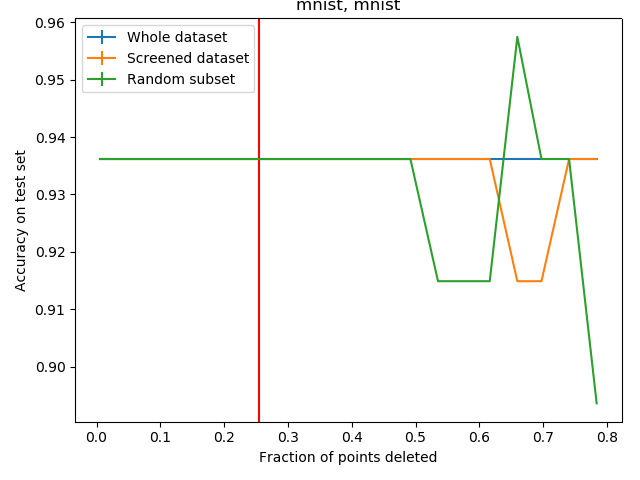

In [124]:
dir = '/nas/home2/g/gmialon/research/safe_datapoints/results/mnist/'
exp = 'lmbda_0.01_n_ellipsoid_10000_intercept_False_mu_1.0_classif_score_True_loss_hinge_penalty_l2.npy'
data = np.load(dir + exp)
plot_experiment(data, 'mnist', 'mnist', 185)

In [1]:
from sklearn.datasets import load_diabetes, load_boston, fetch_20newsgroups
from tools import *
from experiment import *
from screening import *
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from scipy.sparse import rand
import random
import time
from sklearn.model_selection import train_test_split

In [2]:
X, y = load_leukemia(False)
print(find_best_svm(X, y))

(LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=10000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0), 0.95833333333333337)


In [3]:
def make_redundant_data_classification(X, y, nb_points_to_add):
    X_redundant = X
    y_redundant = y
    compt = 0
    X_pos = X[np.where(y == 1)]
    X_neg = X[np.where(y == 1)]

    while compt< nb_points_to_add:
        compt+=1
        random.seed(compt)
        np.random.seed(compt)

        convex_comb = np.random.random(X_pos.shape[0])
        convex_comb /= convex_comb.sum()
        X_redundant_new = (X_pos.T).dot(convex_comb).reshape(-1, X.shape[1])
        X_redundant = np.concatenate((X_redundant, X_redundant_new), axis=0)
        y_redundant = np.append(y_redundant, 1)

        convex_comb = np.random.random(X_neg.shape[0])
        convex_comb /= convex_comb.sum()
        X_redundant_new = (X_neg.T).dot(convex_comb).reshape(-1, X.shape[1])
        X_redundant = np.concatenate((X_redundant, X_redundant_new), axis=0)
        y_redundant = np.append(y_redundant, -1)
    return X_redundant, y_redundant

X_redundant, y_redundant = make_redundant_data_classification(X, y, 100)

In [3]:
experiment('leukemia', redundant=200, nb_delete_steps=10, lmbda=10, mu=100, classification=True, loss='hinge', 
           penalty='l2', intercept=False, classif_score=True, n_ellipsoid_steps=1000, reverse=False, nb_exp=5, nb_test=3,
           cluster=False)

Time to compute z and A: 88.33085107803345
Time to rank the entire dataset: 4.917124509811401
(377, 7128) (376, 7128) (376, 7128)
(377, 7128) (344, 7128) (344, 7128)
(377, 7128) (311, 7128) (311, 7128)
(377, 7128) (278, 7128) (278, 7128)
(377, 7128) (245, 7128) (245, 7128)
(377, 7128) (212, 7128) (212, 7128)
(377, 7128) (179, 7128) (179, 7128)
(377, 7128) (146, 7128) (146, 7128)
(377, 7128) (113, 7128) (113, 7128)
(377, 7128) (80, 7128) (80, 7128)
Time to compute z and A: 68.88112258911133
Time to rank the entire dataset: 7.647845983505249
(377, 7128) (376, 7128) (376, 7128)
(377, 7128) (344, 7128) (344, 7128)
(377, 7128) (311, 7128) (311, 7128)
(377, 7128) (278, 7128) (278, 7128)
(377, 7128) (245, 7128) (245, 7128)
(377, 7128) (212, 7128) (212, 7128)
(377, 7128) (179, 7128) (179, 7128)
(377, 7128) (146, 7128) (146, 7128)
(377, 7128) (113, 7128) (113, 7128)
(377, 7128) (80, 7128) (80, 7128)
Time to compute z and A: 47.643914222717285
Time to rank the entire dataset: 4.6767578125
(377, 

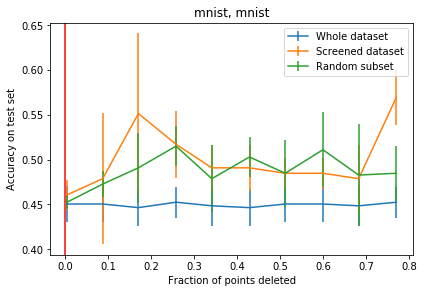

In [7]:
dir = '/nas/home2/g/gmialon/research/safe_datapoints/results/leukemia_redundant/'
exp = 'lmbda_10_n_ellipsoid_1000_reverse_False_intercept_False_mu_100_classif_score_True_loss_hinge_penalty_l2.npy'
data = np.load(dir + exp)
plot_experiment(data, 'mnist', 'mnist', 217)

In [9]:
0.8 * 217
217 - 173

44